In [1]:
# Cell 1:imports

import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap

torch.__version__, models.__version__ if hasattr(models, "__version__") else "tv"


2025-08-27 04:34:58.348607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756269298.561648      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756269298.622226      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('2.6.0+cu124', 'tv')

In [2]:
#Cell 2: Device & Paths

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


In [3]:
#Cell 3: Hyperparameters & Seeding

SEED = 42
BATCH_SIZE_SSL = 64           # for MoCo pretraining
BATCH_SIZE_SUP = 64           # for supervised eval/test
EPOCHS_SSL = 2000             # MoCo pretraining epochs
EPOCHS_LINEAR = 2000        # linear eval epochs

FEATURE_DIM = 512             # ResNet-18 penultimate feature size
PROJ_DIM = 128                # projection dim for MoCo
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

# MoCo-specific
MOMENTUM = 0.999              # momentum for key encoder
QUEUE_SIZE = 1024             # dictionary size
TEMPERATURE = 0.2             # contrastive temperature

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [4]:
#Cell 4: Small Utils

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


In [5]:
# Cell 5: Transforms

# Two random augmentations for MoCo (query & key)
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return q, k

# MoCo augmentations (SimCLR-style are fine for MoCo too)
ssl_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# Supervised (linear eval/test) transform
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])


In [6]:
# Cell 6: Datasets & 20/80 Split + Loaders

# Full supervised dataset (for splits & labels)
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

# 40% train, 60% test
n_total = len(full_dataset_supervised)
n_train = int(0.4 * n_total)
n_test = n_total - n_train

train_sup, test_sup = random_split(
    full_dataset_supervised, [n_train, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# SSL dataset: same images but produces (q,k) pairs
ssl_dataset = ImageFolder(root=DATA_DIR, transform=TwoCropsTransform(ssl_transform))
ssl_train_subset = Subset(ssl_dataset, train_sup.indices)

# DataLoaders
ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True,
                              num_workers=2, drop_last=True)

train_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_sup,  batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

# For visualizations (t-SNE/UMAP) over train portion
vis_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | Train: {len(train_sup)} | Test: {len(test_sup)}")


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | Train: 1276 | Test: 1916


In [7]:
# Cell 7: MoCo Definition (ResNet-18 Backbones)

class MoCo(nn.Module):
    """
    Minimal MoCo v1-style implementation:
    - encoder_q: online (query) encoder
    - encoder_k: momentum (key) encoder
    - queue: negative dictionary
    """
    def __init__(self, base_encoder, feature_dim=128, K=1024, m=0.999, T=0.2):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T

        # Build encoders: output = feature_dim
        self.encoder_q = base_encoder(num_classes=feature_dim)
        self.encoder_k = base_encoder(num_classes=feature_dim)

        # Initialize encoder_k to encoder_q, and set to not require grad
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Create the queue
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update key encoder."""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Enqueue the current keys and dequeue the oldest ones."""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        # For simplicity, require queue size divisible by batch size
        if self.K % batch_size != 0:
            # If not divisible, only fill to the end
            end = min(ptr + batch_size, self.K)
            span = end - ptr
            self.queue[:, ptr:end] = keys[:span].T
            ptr = end % self.K
            self.queue_ptr[0] = ptr
            return

        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # Compute key features with momentum encoder (no grad)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # Positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # Negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Concatenate and apply temperature
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        # Labels: positives are the 0-th
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Update dictionary
        self._dequeue_and_enqueue(k)

        return logits, labels

def resnet18_moco(num_classes=128):
    """ResNet-18 backbone with final fc replaced by projection to num_classes."""
    model = models.resnet18(weights=None)
    dim_mlp = model.fc.in_features
    model.fc = nn.Linear(dim_mlp, num_classes)
    return model


In [8]:
# Cell 8: Train MoCo Pretraining

moco = MoCo(base_encoder=resnet18_moco, feature_dim=PROJ_DIM,
            K=QUEUE_SIZE, m=MOMENTUM, T=TEMPERATURE).to(DEVICE)

opt_moco = torch.optim.Adam(moco.parameters(), lr=LR_SSL)
moco_loss_history = []

print("Starting MoCo pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    moco.train()
    running = 0.0
    for (im_q, im_k), _ in tqdm(ssl_train_loader, desc=f"MoCo Epoch {epoch}/{EPOCHS_SSL}"):
        im_q, im_k = im_q.to(DEVICE), im_k.to(DEVICE)
        logits, labels = moco(im_q, im_k)
        loss = F.cross_entropy(logits, labels)

        opt_moco.zero_grad()
        loss.backward()
        opt_moco.step()

        running += loss.item() * im_q.size(0)

    epoch_loss = running / len(ssl_train_loader.dataset)
    moco_loss_history.append(epoch_loss)
    print(f"MoCo Epoch {epoch}: loss={epoch_loss:.4f}")

# Save the query encoder (backbone+proj) – we will load as backbone and strip fc
torch.save(moco.encoder_q.state_dict(), os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))
print("Saved MoCo encoder to:", os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))


Starting MoCo pretraining...


MoCo Epoch 1/2000: 100%|██████████| 19/19 [00:21<00:00,  1.15s/it]


MoCo Epoch 1: loss=5.5095


MoCo Epoch 2/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 2: loss=6.2306


MoCo Epoch 3/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 3: loss=6.1638


MoCo Epoch 4/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 4: loss=6.1443


MoCo Epoch 5/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 5: loss=6.0842


MoCo Epoch 6/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 6: loss=6.0551


MoCo Epoch 7/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 7: loss=5.9911


MoCo Epoch 8/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 8: loss=5.9785


MoCo Epoch 9/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 9: loss=5.9205


MoCo Epoch 10/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 10: loss=5.9011


MoCo Epoch 11/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 11: loss=5.8546


MoCo Epoch 12/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 12: loss=5.8151


MoCo Epoch 13/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 13: loss=5.8278


MoCo Epoch 14/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 14: loss=5.8076


MoCo Epoch 15/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 15: loss=5.7245


MoCo Epoch 16/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 16: loss=5.7262


MoCo Epoch 17/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 17: loss=5.7067


MoCo Epoch 18/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 18: loss=5.6884


MoCo Epoch 19/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 19: loss=5.6902


MoCo Epoch 20/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 20: loss=5.6525


MoCo Epoch 21/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 21: loss=5.6187


MoCo Epoch 22/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 22: loss=5.5997


MoCo Epoch 23/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 23: loss=5.6022


MoCo Epoch 24/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 24: loss=5.5977


MoCo Epoch 25/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 25: loss=5.5767


MoCo Epoch 26/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 26: loss=5.5561


MoCo Epoch 27/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 27: loss=5.5314


MoCo Epoch 28/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 28: loss=5.5166


MoCo Epoch 29/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 29: loss=5.4645


MoCo Epoch 30/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 30: loss=5.4666


MoCo Epoch 31/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 31: loss=5.4673


MoCo Epoch 32/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 32: loss=5.4658


MoCo Epoch 33/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 33: loss=5.3941


MoCo Epoch 34/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 34: loss=5.4331


MoCo Epoch 35/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 35: loss=5.4148


MoCo Epoch 36/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 36: loss=5.3601


MoCo Epoch 37/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 37: loss=5.3844


MoCo Epoch 38/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 38: loss=5.4097


MoCo Epoch 39/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 39: loss=5.3690


MoCo Epoch 40/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 40: loss=5.3265


MoCo Epoch 41/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 41: loss=5.2645


MoCo Epoch 42/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 42: loss=5.3083


MoCo Epoch 43/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 43: loss=5.2238


MoCo Epoch 44/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 44: loss=5.3036


MoCo Epoch 45/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 45: loss=5.2914


MoCo Epoch 46/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 46: loss=5.2945


MoCo Epoch 47/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 47: loss=5.2658


MoCo Epoch 48/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 48: loss=5.2361


MoCo Epoch 49/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 49: loss=5.1636


MoCo Epoch 50/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 50: loss=5.2033


MoCo Epoch 51/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 51: loss=5.1607


MoCo Epoch 52/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 52: loss=5.1504


MoCo Epoch 53/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 53: loss=5.2183


MoCo Epoch 54/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 54: loss=5.1292


MoCo Epoch 55/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 55: loss=5.1211


MoCo Epoch 56/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 56: loss=5.1211


MoCo Epoch 57/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 57: loss=5.0678


MoCo Epoch 58/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 58: loss=5.0823


MoCo Epoch 59/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 59: loss=5.0792


MoCo Epoch 60/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 60: loss=5.0880


MoCo Epoch 61/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 61: loss=5.0648


MoCo Epoch 62/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 62: loss=4.9919


MoCo Epoch 63/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 63: loss=5.0264


MoCo Epoch 64/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 64: loss=5.0296


MoCo Epoch 65/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 65: loss=4.9950


MoCo Epoch 66/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 66: loss=4.9334


MoCo Epoch 67/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 67: loss=5.0082


MoCo Epoch 68/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 68: loss=4.9262


MoCo Epoch 69/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 69: loss=4.9434


MoCo Epoch 70/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 70: loss=4.8858


MoCo Epoch 71/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 71: loss=4.9350


MoCo Epoch 72/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 72: loss=4.9394


MoCo Epoch 73/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 73: loss=4.8912


MoCo Epoch 74/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 74: loss=4.8641


MoCo Epoch 75/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 75: loss=4.8884


MoCo Epoch 76/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 76: loss=4.8437


MoCo Epoch 77/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 77: loss=4.8035


MoCo Epoch 78/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 78: loss=4.7866


MoCo Epoch 79/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 79: loss=4.7926


MoCo Epoch 80/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 80: loss=4.8551


MoCo Epoch 81/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 81: loss=4.8161


MoCo Epoch 82/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 82: loss=4.8394


MoCo Epoch 83/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 83: loss=4.8345


MoCo Epoch 84/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 84: loss=4.7901


MoCo Epoch 85/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 85: loss=4.8150


MoCo Epoch 86/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 86: loss=4.7601


MoCo Epoch 87/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 87: loss=4.7358


MoCo Epoch 88/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 88: loss=4.7251


MoCo Epoch 89/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 89: loss=4.7034


MoCo Epoch 90/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 90: loss=4.7373


MoCo Epoch 91/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 91: loss=4.7287


MoCo Epoch 92/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 92: loss=4.7066


MoCo Epoch 93/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 93: loss=4.6827


MoCo Epoch 94/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 94: loss=4.7008


MoCo Epoch 95/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 95: loss=4.6906


MoCo Epoch 96/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 96: loss=4.6717


MoCo Epoch 97/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 97: loss=4.6718


MoCo Epoch 98/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 98: loss=4.6228


MoCo Epoch 99/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 99: loss=4.5956


MoCo Epoch 100/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 100: loss=4.6617


MoCo Epoch 101/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 101: loss=4.6343


MoCo Epoch 102/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 102: loss=4.6225


MoCo Epoch 103/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 103: loss=4.6339


MoCo Epoch 104/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 104: loss=4.5716


MoCo Epoch 105/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 105: loss=4.5932


MoCo Epoch 106/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 106: loss=4.5814


MoCo Epoch 107/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 107: loss=4.5574


MoCo Epoch 108/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 108: loss=4.5632


MoCo Epoch 109/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 109: loss=4.5214


MoCo Epoch 110/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 110: loss=4.5608


MoCo Epoch 111/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 111: loss=4.5029


MoCo Epoch 112/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 112: loss=4.5879


MoCo Epoch 113/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 113: loss=4.5319


MoCo Epoch 114/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 114: loss=4.5583


MoCo Epoch 115/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 115: loss=4.5137


MoCo Epoch 116/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 116: loss=4.4933


MoCo Epoch 117/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 117: loss=4.4813


MoCo Epoch 118/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 118: loss=4.4996


MoCo Epoch 119/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 119: loss=4.4491


MoCo Epoch 120/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 120: loss=4.4737


MoCo Epoch 121/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 121: loss=4.4876


MoCo Epoch 122/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 122: loss=4.4221


MoCo Epoch 123/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 123: loss=4.4384


MoCo Epoch 124/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 124: loss=4.3905


MoCo Epoch 125/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 125: loss=4.4204


MoCo Epoch 126/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 126: loss=4.4052


MoCo Epoch 127/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 127: loss=4.4274


MoCo Epoch 128/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 128: loss=4.4414


MoCo Epoch 129/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 129: loss=4.3963


MoCo Epoch 130/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 130: loss=4.4150


MoCo Epoch 131/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 131: loss=4.3882


MoCo Epoch 132/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 132: loss=4.3672


MoCo Epoch 133/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 133: loss=4.3759


MoCo Epoch 134/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 134: loss=4.3385


MoCo Epoch 135/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 135: loss=4.3586


MoCo Epoch 136/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 136: loss=4.3441


MoCo Epoch 137/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 137: loss=4.3272


MoCo Epoch 138/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 138: loss=4.3664


MoCo Epoch 139/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 139: loss=4.3845


MoCo Epoch 140/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 140: loss=4.3389


MoCo Epoch 141/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 141: loss=4.3578


MoCo Epoch 142/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 142: loss=4.2958


MoCo Epoch 143/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 143: loss=4.3151


MoCo Epoch 144/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 144: loss=4.2908


MoCo Epoch 145/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 145: loss=4.2884


MoCo Epoch 146/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 146: loss=4.3050


MoCo Epoch 147/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 147: loss=4.2777


MoCo Epoch 148/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 148: loss=4.3056


MoCo Epoch 149/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 149: loss=4.2741


MoCo Epoch 150/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 150: loss=4.2705


MoCo Epoch 151/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 151: loss=4.2471


MoCo Epoch 152/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 152: loss=4.2398


MoCo Epoch 153/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 153: loss=4.2320


MoCo Epoch 154/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 154: loss=4.2171


MoCo Epoch 155/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 155: loss=4.1759


MoCo Epoch 156/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 156: loss=4.2058


MoCo Epoch 157/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 157: loss=4.2062


MoCo Epoch 158/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 158: loss=4.2525


MoCo Epoch 159/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 159: loss=4.2803


MoCo Epoch 160/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 160: loss=4.1823


MoCo Epoch 161/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 161: loss=4.1973


MoCo Epoch 162/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 162: loss=4.1705


MoCo Epoch 163/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 163: loss=4.1545


MoCo Epoch 164/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 164: loss=4.1556


MoCo Epoch 165/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 165: loss=4.1656


MoCo Epoch 166/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 166: loss=4.1803


MoCo Epoch 167/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 167: loss=4.1859


MoCo Epoch 168/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 168: loss=4.1669


MoCo Epoch 169/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 169: loss=4.1470


MoCo Epoch 170/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 170: loss=4.1499


MoCo Epoch 171/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 171: loss=4.1038


MoCo Epoch 172/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 172: loss=4.1428


MoCo Epoch 173/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 173: loss=4.1443


MoCo Epoch 174/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 174: loss=4.1121


MoCo Epoch 175/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 175: loss=4.1256


MoCo Epoch 176/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 176: loss=4.1029


MoCo Epoch 177/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 177: loss=4.1113


MoCo Epoch 178/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 178: loss=4.0836


MoCo Epoch 179/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 179: loss=4.1175


MoCo Epoch 180/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 180: loss=4.0757


MoCo Epoch 181/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 181: loss=4.0695


MoCo Epoch 182/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 182: loss=4.0755


MoCo Epoch 183/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 183: loss=4.0726


MoCo Epoch 184/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 184: loss=4.1027


MoCo Epoch 185/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 185: loss=4.0802


MoCo Epoch 186/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 186: loss=4.1028


MoCo Epoch 187/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 187: loss=4.0480


MoCo Epoch 188/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 188: loss=4.0541


MoCo Epoch 189/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 189: loss=4.0271


MoCo Epoch 190/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 190: loss=4.0525


MoCo Epoch 191/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 191: loss=4.0525


MoCo Epoch 192/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 192: loss=4.0472


MoCo Epoch 193/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 193: loss=4.0200


MoCo Epoch 194/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 194: loss=4.0701


MoCo Epoch 195/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 195: loss=4.0299


MoCo Epoch 196/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 196: loss=4.0179


MoCo Epoch 197/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 197: loss=4.0346


MoCo Epoch 198/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 198: loss=3.9994


MoCo Epoch 199/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 199: loss=4.0203


MoCo Epoch 200/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 200: loss=3.9839


MoCo Epoch 201/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 201: loss=3.9825


MoCo Epoch 202/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 202: loss=3.9872


MoCo Epoch 203/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 203: loss=3.9802


MoCo Epoch 204/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 204: loss=3.9749


MoCo Epoch 205/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 205: loss=3.9537


MoCo Epoch 206/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 206: loss=3.9728


MoCo Epoch 207/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 207: loss=3.9588


MoCo Epoch 208/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 208: loss=3.9829


MoCo Epoch 209/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 209: loss=3.9128


MoCo Epoch 210/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 210: loss=3.9467


MoCo Epoch 211/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 211: loss=3.9469


MoCo Epoch 212/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 212: loss=3.9529


MoCo Epoch 213/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 213: loss=3.9253


MoCo Epoch 214/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 214: loss=3.9480


MoCo Epoch 215/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 215: loss=3.9428


MoCo Epoch 216/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 216: loss=3.9476


MoCo Epoch 217/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 217: loss=3.9301


MoCo Epoch 218/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 218: loss=3.9234


MoCo Epoch 219/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 219: loss=3.9170


MoCo Epoch 220/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 220: loss=3.9262


MoCo Epoch 221/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 221: loss=3.9039


MoCo Epoch 222/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 222: loss=3.8834


MoCo Epoch 223/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 223: loss=3.9062


MoCo Epoch 224/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 224: loss=3.8903


MoCo Epoch 225/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 225: loss=3.8754


MoCo Epoch 226/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 226: loss=3.8496


MoCo Epoch 227/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 227: loss=3.8597


MoCo Epoch 228/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 228: loss=3.8392


MoCo Epoch 229/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 229: loss=3.8838


MoCo Epoch 230/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 230: loss=3.8765


MoCo Epoch 231/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 231: loss=3.8726


MoCo Epoch 232/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 232: loss=3.8329


MoCo Epoch 233/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 233: loss=3.8274


MoCo Epoch 234/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 234: loss=3.8129


MoCo Epoch 235/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 235: loss=3.8358


MoCo Epoch 236/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 236: loss=3.8066


MoCo Epoch 237/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 237: loss=3.8771


MoCo Epoch 238/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 238: loss=3.8601


MoCo Epoch 239/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 239: loss=3.8254


MoCo Epoch 240/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 240: loss=3.8078


MoCo Epoch 241/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 241: loss=3.8242


MoCo Epoch 242/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 242: loss=3.8270


MoCo Epoch 243/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 243: loss=3.8194


MoCo Epoch 244/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 244: loss=3.8365


MoCo Epoch 245/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 245: loss=3.8077


MoCo Epoch 246/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 246: loss=3.7994


MoCo Epoch 247/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 247: loss=3.8123


MoCo Epoch 248/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 248: loss=3.8011


MoCo Epoch 249/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 249: loss=3.8021


MoCo Epoch 250/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 250: loss=3.8021


MoCo Epoch 251/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 251: loss=3.7936


MoCo Epoch 252/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 252: loss=3.7800


MoCo Epoch 253/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 253: loss=3.7945


MoCo Epoch 254/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 254: loss=3.7685


MoCo Epoch 255/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 255: loss=3.7949


MoCo Epoch 256/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 256: loss=3.7871


MoCo Epoch 257/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 257: loss=3.7482


MoCo Epoch 258/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 258: loss=3.7537


MoCo Epoch 259/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 259: loss=3.7682


MoCo Epoch 260/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 260: loss=3.7340


MoCo Epoch 261/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 261: loss=3.7258


MoCo Epoch 262/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 262: loss=3.7700


MoCo Epoch 263/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 263: loss=3.7473


MoCo Epoch 264/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 264: loss=3.7400


MoCo Epoch 265/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 265: loss=3.7425


MoCo Epoch 266/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 266: loss=3.7374


MoCo Epoch 267/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 267: loss=3.7087


MoCo Epoch 268/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 268: loss=3.7167


MoCo Epoch 269/2000: 100%|██████████| 19/19 [00:19<00:00,  1.01s/it]


MoCo Epoch 269: loss=3.7342


MoCo Epoch 270/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 270: loss=3.7256


MoCo Epoch 271/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 271: loss=3.6760


MoCo Epoch 272/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 272: loss=3.7213


MoCo Epoch 273/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 273: loss=3.7158


MoCo Epoch 274/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 274: loss=3.7157


MoCo Epoch 275/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 275: loss=3.7167


MoCo Epoch 276/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 276: loss=3.7102


MoCo Epoch 277/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 277: loss=3.7258


MoCo Epoch 278/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 278: loss=3.6876


MoCo Epoch 279/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 279: loss=3.6859


MoCo Epoch 280/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 280: loss=3.6822


MoCo Epoch 281/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 281: loss=3.6969


MoCo Epoch 282/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 282: loss=3.7081


MoCo Epoch 283/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 283: loss=3.6912


MoCo Epoch 284/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 284: loss=3.7026


MoCo Epoch 285/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 285: loss=3.6887


MoCo Epoch 286/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 286: loss=3.6666


MoCo Epoch 287/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 287: loss=3.6880


MoCo Epoch 288/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 288: loss=3.6743


MoCo Epoch 289/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 289: loss=3.6862


MoCo Epoch 290/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 290: loss=3.6708


MoCo Epoch 291/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 291: loss=3.6581


MoCo Epoch 292/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 292: loss=3.6434


MoCo Epoch 293/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 293: loss=3.6788


MoCo Epoch 294/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 294: loss=3.6739


MoCo Epoch 295/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 295: loss=3.6220


MoCo Epoch 296/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 296: loss=3.6124


MoCo Epoch 297/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 297: loss=3.6477


MoCo Epoch 298/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 298: loss=3.6399


MoCo Epoch 299/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 299: loss=3.6387


MoCo Epoch 300/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 300: loss=3.6324


MoCo Epoch 301/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 301: loss=3.6562


MoCo Epoch 302/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 302: loss=3.5966


MoCo Epoch 303/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 303: loss=3.6205


MoCo Epoch 304/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 304: loss=3.6220


MoCo Epoch 305/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 305: loss=3.6324


MoCo Epoch 306/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 306: loss=3.6434


MoCo Epoch 307/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 307: loss=3.6087


MoCo Epoch 308/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 308: loss=3.6193


MoCo Epoch 309/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 309: loss=3.6462


MoCo Epoch 310/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 310: loss=3.6262


MoCo Epoch 311/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 311: loss=3.6119


MoCo Epoch 312/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 312: loss=3.6035


MoCo Epoch 313/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 313: loss=3.6612


MoCo Epoch 314/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 314: loss=3.6026


MoCo Epoch 315/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 315: loss=3.5633


MoCo Epoch 316/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 316: loss=3.5751


MoCo Epoch 317/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 317: loss=3.6069


MoCo Epoch 318/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 318: loss=3.5835


MoCo Epoch 319/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 319: loss=3.6098


MoCo Epoch 320/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 320: loss=3.5728


MoCo Epoch 321/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 321: loss=3.6163


MoCo Epoch 322/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 322: loss=3.5642


MoCo Epoch 323/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 323: loss=3.5506


MoCo Epoch 324/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 324: loss=3.5787


MoCo Epoch 325/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 325: loss=3.5702


MoCo Epoch 326/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 326: loss=3.5797


MoCo Epoch 327/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 327: loss=3.5529


MoCo Epoch 328/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 328: loss=3.5747


MoCo Epoch 329/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 329: loss=3.5764


MoCo Epoch 330/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 330: loss=3.5782


MoCo Epoch 331/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 331: loss=3.5824


MoCo Epoch 332/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 332: loss=3.5218


MoCo Epoch 333/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 333: loss=3.5790


MoCo Epoch 334/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 334: loss=3.5656


MoCo Epoch 335/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 335: loss=3.5653


MoCo Epoch 336/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 336: loss=3.5801


MoCo Epoch 337/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 337: loss=3.5310


MoCo Epoch 338/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 338: loss=3.5484


MoCo Epoch 339/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 339: loss=3.5389


MoCo Epoch 340/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 340: loss=3.5194


MoCo Epoch 341/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 341: loss=3.5458


MoCo Epoch 342/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 342: loss=3.5463


MoCo Epoch 343/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 343: loss=3.5304


MoCo Epoch 344/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 344: loss=3.5228


MoCo Epoch 345/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 345: loss=3.5469


MoCo Epoch 346/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 346: loss=3.5328


MoCo Epoch 347/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 347: loss=3.5154


MoCo Epoch 348/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 348: loss=3.5109


MoCo Epoch 349/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 349: loss=3.5371


MoCo Epoch 350/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 350: loss=3.5200


MoCo Epoch 351/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 351: loss=3.4787


MoCo Epoch 352/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 352: loss=3.5072


MoCo Epoch 353/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 353: loss=3.5335


MoCo Epoch 354/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 354: loss=3.5028


MoCo Epoch 355/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 355: loss=3.5093


MoCo Epoch 356/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 356: loss=3.5034


MoCo Epoch 357/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 357: loss=3.4926


MoCo Epoch 358/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 358: loss=3.4631


MoCo Epoch 359/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 359: loss=3.4984


MoCo Epoch 360/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 360: loss=3.4947


MoCo Epoch 361/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 361: loss=3.4764


MoCo Epoch 362/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 362: loss=3.4897


MoCo Epoch 363/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 363: loss=3.4930


MoCo Epoch 364/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 364: loss=3.4804


MoCo Epoch 365/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 365: loss=3.5103


MoCo Epoch 366/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 366: loss=3.5045


MoCo Epoch 367/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 367: loss=3.4903


MoCo Epoch 368/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 368: loss=3.4546


MoCo Epoch 369/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 369: loss=3.4764


MoCo Epoch 370/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 370: loss=3.4896


MoCo Epoch 371/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 371: loss=3.4886


MoCo Epoch 372/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 372: loss=3.5036


MoCo Epoch 373/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 373: loss=3.4556


MoCo Epoch 374/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 374: loss=3.4714


MoCo Epoch 375/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 375: loss=3.4710


MoCo Epoch 376/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 376: loss=3.4314


MoCo Epoch 377/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 377: loss=3.4480


MoCo Epoch 378/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 378: loss=3.4555


MoCo Epoch 379/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 379: loss=3.4751


MoCo Epoch 380/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 380: loss=3.4573


MoCo Epoch 381/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 381: loss=3.4537


MoCo Epoch 382/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 382: loss=3.4636


MoCo Epoch 383/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 383: loss=3.4500


MoCo Epoch 384/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 384: loss=3.4539


MoCo Epoch 385/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 385: loss=3.4551


MoCo Epoch 386/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 386: loss=3.4411


MoCo Epoch 387/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 387: loss=3.4305


MoCo Epoch 388/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 388: loss=3.4266


MoCo Epoch 389/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 389: loss=3.4149


MoCo Epoch 390/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 390: loss=3.3954


MoCo Epoch 391/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 391: loss=3.4306


MoCo Epoch 392/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 392: loss=3.4291


MoCo Epoch 393/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 393: loss=3.4386


MoCo Epoch 394/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 394: loss=3.4342


MoCo Epoch 395/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 395: loss=3.4226


MoCo Epoch 396/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 396: loss=3.4206


MoCo Epoch 397/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 397: loss=3.4127


MoCo Epoch 398/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 398: loss=3.4079


MoCo Epoch 399/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 399: loss=3.4318


MoCo Epoch 400/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 400: loss=3.4128


MoCo Epoch 401/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 401: loss=3.4116


MoCo Epoch 402/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 402: loss=3.4161


MoCo Epoch 403/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 403: loss=3.4359


MoCo Epoch 404/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 404: loss=3.4167


MoCo Epoch 405/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 405: loss=3.3906


MoCo Epoch 406/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 406: loss=3.4049


MoCo Epoch 407/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 407: loss=3.4024


MoCo Epoch 408/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 408: loss=3.3926


MoCo Epoch 409/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 409: loss=3.3946


MoCo Epoch 410/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 410: loss=3.3814


MoCo Epoch 411/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 411: loss=3.3885


MoCo Epoch 412/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 412: loss=3.3626


MoCo Epoch 413/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 413: loss=3.3516


MoCo Epoch 414/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 414: loss=3.3775


MoCo Epoch 415/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 415: loss=3.3743


MoCo Epoch 416/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 416: loss=3.3920


MoCo Epoch 417/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 417: loss=3.4116


MoCo Epoch 418/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 418: loss=3.3762


MoCo Epoch 419/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 419: loss=3.3817


MoCo Epoch 420/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 420: loss=3.3732


MoCo Epoch 421/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 421: loss=3.3847


MoCo Epoch 422/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 422: loss=3.3731


MoCo Epoch 423/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 423: loss=3.3683


MoCo Epoch 424/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 424: loss=3.3951


MoCo Epoch 425/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 425: loss=3.3605


MoCo Epoch 426/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 426: loss=3.3645


MoCo Epoch 427/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 427: loss=3.3714


MoCo Epoch 428/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 428: loss=3.3534


MoCo Epoch 429/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 429: loss=3.3537


MoCo Epoch 430/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 430: loss=3.3790


MoCo Epoch 431/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 431: loss=3.3557


MoCo Epoch 432/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 432: loss=3.3354


MoCo Epoch 433/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 433: loss=3.3459


MoCo Epoch 434/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 434: loss=3.3756


MoCo Epoch 435/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 435: loss=3.3540


MoCo Epoch 436/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 436: loss=3.3342


MoCo Epoch 437/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 437: loss=3.3340


MoCo Epoch 438/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 438: loss=3.3375


MoCo Epoch 439/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 439: loss=3.3338


MoCo Epoch 440/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 440: loss=3.3169


MoCo Epoch 441/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 441: loss=3.3275


MoCo Epoch 442/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 442: loss=3.3199


MoCo Epoch 443/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 443: loss=3.3192


MoCo Epoch 444/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 444: loss=3.3257


MoCo Epoch 445/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 445: loss=3.3302


MoCo Epoch 446/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 446: loss=3.3498


MoCo Epoch 447/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 447: loss=3.3258


MoCo Epoch 448/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 448: loss=3.3103


MoCo Epoch 449/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 449: loss=3.3288


MoCo Epoch 450/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 450: loss=3.3105


MoCo Epoch 451/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 451: loss=3.3135


MoCo Epoch 452/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 452: loss=3.3035


MoCo Epoch 453/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 453: loss=3.3352


MoCo Epoch 454/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 454: loss=3.3178


MoCo Epoch 455/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 455: loss=3.2853


MoCo Epoch 456/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 456: loss=3.2886


MoCo Epoch 457/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 457: loss=3.3059


MoCo Epoch 458/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 458: loss=3.3048


MoCo Epoch 459/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 459: loss=3.2833


MoCo Epoch 460/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 460: loss=3.2772


MoCo Epoch 461/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 461: loss=3.3227


MoCo Epoch 462/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 462: loss=3.3126


MoCo Epoch 463/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 463: loss=3.3093


MoCo Epoch 464/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 464: loss=3.2859


MoCo Epoch 465/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 465: loss=3.2875


MoCo Epoch 466/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 466: loss=3.2922


MoCo Epoch 467/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 467: loss=3.3097


MoCo Epoch 468/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 468: loss=3.2924


MoCo Epoch 469/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 469: loss=3.2680


MoCo Epoch 470/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 470: loss=3.2841


MoCo Epoch 471/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 471: loss=3.2997


MoCo Epoch 472/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 472: loss=3.2798


MoCo Epoch 473/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 473: loss=3.3054


MoCo Epoch 474/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 474: loss=3.2652


MoCo Epoch 475/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 475: loss=3.2828


MoCo Epoch 476/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 476: loss=3.2746


MoCo Epoch 477/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 477: loss=3.2902


MoCo Epoch 478/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 478: loss=3.2717


MoCo Epoch 479/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 479: loss=3.2595


MoCo Epoch 480/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 480: loss=3.2328


MoCo Epoch 481/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 481: loss=3.2578


MoCo Epoch 482/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 482: loss=3.2784


MoCo Epoch 483/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 483: loss=3.2482


MoCo Epoch 484/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 484: loss=3.2607


MoCo Epoch 485/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 485: loss=3.2508


MoCo Epoch 486/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 486: loss=3.2409


MoCo Epoch 487/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 487: loss=3.2794


MoCo Epoch 488/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 488: loss=3.2733


MoCo Epoch 489/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 489: loss=3.2574


MoCo Epoch 490/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 490: loss=3.2641


MoCo Epoch 491/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 491: loss=3.2651


MoCo Epoch 492/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 492: loss=3.2473


MoCo Epoch 493/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 493: loss=3.2314


MoCo Epoch 494/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 494: loss=3.2474


MoCo Epoch 495/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 495: loss=3.2784


MoCo Epoch 496/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 496: loss=3.2123


MoCo Epoch 497/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 497: loss=3.2559


MoCo Epoch 498/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 498: loss=3.2322


MoCo Epoch 499/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 499: loss=3.2343


MoCo Epoch 500/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 500: loss=3.2382


MoCo Epoch 501/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 501: loss=3.2187


MoCo Epoch 502/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 502: loss=3.1990


MoCo Epoch 503/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 503: loss=3.2530


MoCo Epoch 504/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 504: loss=3.2393


MoCo Epoch 505/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 505: loss=3.2276


MoCo Epoch 506/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 506: loss=3.2333


MoCo Epoch 507/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 507: loss=3.2017


MoCo Epoch 508/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 508: loss=3.2533


MoCo Epoch 509/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 509: loss=3.1973


MoCo Epoch 510/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 510: loss=3.2115


MoCo Epoch 511/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 511: loss=3.2142


MoCo Epoch 512/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 512: loss=3.2287


MoCo Epoch 513/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 513: loss=3.2275


MoCo Epoch 514/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 514: loss=3.2054


MoCo Epoch 515/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 515: loss=3.2070


MoCo Epoch 516/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 516: loss=3.2047


MoCo Epoch 517/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 517: loss=3.1898


MoCo Epoch 518/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 518: loss=3.2034


MoCo Epoch 519/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 519: loss=3.2158


MoCo Epoch 520/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 520: loss=3.1939


MoCo Epoch 521/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 521: loss=3.2032


MoCo Epoch 522/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 522: loss=3.1833


MoCo Epoch 523/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 523: loss=3.1947


MoCo Epoch 524/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 524: loss=3.2043


MoCo Epoch 525/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 525: loss=3.2090


MoCo Epoch 526/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 526: loss=3.2043


MoCo Epoch 527/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 527: loss=3.1859


MoCo Epoch 528/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 528: loss=3.1797


MoCo Epoch 529/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 529: loss=3.2072


MoCo Epoch 530/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 530: loss=3.1627


MoCo Epoch 531/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 531: loss=3.1814


MoCo Epoch 532/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 532: loss=3.1802


MoCo Epoch 533/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 533: loss=3.1822


MoCo Epoch 534/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 534: loss=3.2053


MoCo Epoch 535/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 535: loss=3.1852


MoCo Epoch 536/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 536: loss=3.1717


MoCo Epoch 537/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 537: loss=3.1798


MoCo Epoch 538/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 538: loss=3.1639


MoCo Epoch 539/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 539: loss=3.2156


MoCo Epoch 540/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 540: loss=3.1833


MoCo Epoch 541/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 541: loss=3.1727


MoCo Epoch 542/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 542: loss=3.1703


MoCo Epoch 543/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 543: loss=3.1743


MoCo Epoch 544/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 544: loss=3.1493


MoCo Epoch 545/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 545: loss=3.1550


MoCo Epoch 546/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 546: loss=3.1452


MoCo Epoch 547/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 547: loss=3.1440


MoCo Epoch 548/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 548: loss=3.1630


MoCo Epoch 549/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 549: loss=3.1690


MoCo Epoch 550/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 550: loss=3.1658


MoCo Epoch 551/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 551: loss=3.1654


MoCo Epoch 552/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 552: loss=3.1573


MoCo Epoch 553/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 553: loss=3.1444


MoCo Epoch 554/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 554: loss=3.1475


MoCo Epoch 555/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 555: loss=3.1578


MoCo Epoch 556/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 556: loss=3.1672


MoCo Epoch 557/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 557: loss=3.1450


MoCo Epoch 558/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 558: loss=3.1645


MoCo Epoch 559/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 559: loss=3.1260


MoCo Epoch 560/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 560: loss=3.1510


MoCo Epoch 561/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 561: loss=3.1623


MoCo Epoch 562/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 562: loss=3.1606


MoCo Epoch 563/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 563: loss=3.1353


MoCo Epoch 564/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 564: loss=3.1593


MoCo Epoch 565/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 565: loss=3.1465


MoCo Epoch 566/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 566: loss=3.1204


MoCo Epoch 567/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 567: loss=3.1155


MoCo Epoch 568/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 568: loss=3.1206


MoCo Epoch 569/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 569: loss=3.1345


MoCo Epoch 570/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 570: loss=3.1205


MoCo Epoch 571/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 571: loss=3.1402


MoCo Epoch 572/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 572: loss=3.1302


MoCo Epoch 573/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 573: loss=3.1372


MoCo Epoch 574/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 574: loss=3.1239


MoCo Epoch 575/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 575: loss=3.1224


MoCo Epoch 576/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 576: loss=3.1453


MoCo Epoch 577/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 577: loss=3.1178


MoCo Epoch 578/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 578: loss=3.1114


MoCo Epoch 579/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 579: loss=3.1255


MoCo Epoch 580/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 580: loss=3.1321


MoCo Epoch 581/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 581: loss=3.1360


MoCo Epoch 582/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 582: loss=3.1055


MoCo Epoch 583/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 583: loss=3.1042


MoCo Epoch 584/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 584: loss=3.1157


MoCo Epoch 585/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 585: loss=3.0935


MoCo Epoch 586/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 586: loss=3.0952


MoCo Epoch 587/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 587: loss=3.1049


MoCo Epoch 588/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 588: loss=3.1279


MoCo Epoch 589/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 589: loss=3.1010


MoCo Epoch 590/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 590: loss=3.1018


MoCo Epoch 591/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 591: loss=3.1097


MoCo Epoch 592/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 592: loss=3.1182


MoCo Epoch 593/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 593: loss=3.1106


MoCo Epoch 594/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 594: loss=3.1048


MoCo Epoch 595/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 595: loss=3.0895


MoCo Epoch 596/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 596: loss=3.1023


MoCo Epoch 597/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 597: loss=3.0885


MoCo Epoch 598/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 598: loss=3.0881


MoCo Epoch 599/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 599: loss=3.1026


MoCo Epoch 600/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 600: loss=3.0875


MoCo Epoch 601/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 601: loss=3.0940


MoCo Epoch 602/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 602: loss=3.0874


MoCo Epoch 603/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 603: loss=3.1022


MoCo Epoch 604/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 604: loss=3.0914


MoCo Epoch 605/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 605: loss=3.1047


MoCo Epoch 606/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 606: loss=3.0913


MoCo Epoch 607/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 607: loss=3.0893


MoCo Epoch 608/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 608: loss=3.0818


MoCo Epoch 609/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 609: loss=3.0777


MoCo Epoch 610/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 610: loss=3.0741


MoCo Epoch 611/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 611: loss=3.0786


MoCo Epoch 612/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 612: loss=3.0697


MoCo Epoch 613/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 613: loss=3.0630


MoCo Epoch 614/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 614: loss=3.0848


MoCo Epoch 615/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 615: loss=3.0746


MoCo Epoch 616/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 616: loss=3.0778


MoCo Epoch 617/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 617: loss=3.0663


MoCo Epoch 618/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 618: loss=3.0714


MoCo Epoch 619/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 619: loss=3.0653


MoCo Epoch 620/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 620: loss=3.0611


MoCo Epoch 621/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 621: loss=3.0571


MoCo Epoch 622/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 622: loss=3.0551


MoCo Epoch 623/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 623: loss=3.0415


MoCo Epoch 624/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 624: loss=3.0583


MoCo Epoch 625/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 625: loss=3.0755


MoCo Epoch 626/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 626: loss=3.0638


MoCo Epoch 627/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 627: loss=3.0589


MoCo Epoch 628/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 628: loss=3.0635


MoCo Epoch 629/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 629: loss=3.0907


MoCo Epoch 630/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 630: loss=3.0400


MoCo Epoch 631/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 631: loss=3.0535


MoCo Epoch 632/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 632: loss=3.0614


MoCo Epoch 633/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 633: loss=3.0625


MoCo Epoch 634/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 634: loss=3.0372


MoCo Epoch 635/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 635: loss=3.0466


MoCo Epoch 636/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 636: loss=3.0399


MoCo Epoch 637/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 637: loss=3.0393


MoCo Epoch 638/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 638: loss=3.0543


MoCo Epoch 639/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 639: loss=3.0444


MoCo Epoch 640/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 640: loss=3.0490


MoCo Epoch 641/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 641: loss=3.0458


MoCo Epoch 642/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 642: loss=3.0612


MoCo Epoch 643/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 643: loss=3.0331


MoCo Epoch 644/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 644: loss=3.0407


MoCo Epoch 645/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 645: loss=3.0281


MoCo Epoch 646/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 646: loss=3.0414


MoCo Epoch 647/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 647: loss=3.0279


MoCo Epoch 648/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 648: loss=3.0258


MoCo Epoch 649/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 649: loss=3.0281


MoCo Epoch 650/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 650: loss=3.0424


MoCo Epoch 651/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 651: loss=3.0238


MoCo Epoch 652/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 652: loss=3.0306


MoCo Epoch 653/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 653: loss=3.0263


MoCo Epoch 654/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 654: loss=3.0046


MoCo Epoch 655/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 655: loss=3.0190


MoCo Epoch 656/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 656: loss=3.0013


MoCo Epoch 657/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 657: loss=3.0040


MoCo Epoch 658/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 658: loss=3.0167


MoCo Epoch 659/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 659: loss=2.9999


MoCo Epoch 660/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 660: loss=3.0279


MoCo Epoch 661/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 661: loss=3.0029


MoCo Epoch 662/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 662: loss=2.9999


MoCo Epoch 663/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 663: loss=3.0115


MoCo Epoch 664/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 664: loss=3.0109


MoCo Epoch 665/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 665: loss=3.0251


MoCo Epoch 666/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 666: loss=3.0178


MoCo Epoch 667/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 667: loss=3.0010


MoCo Epoch 668/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 668: loss=3.0013


MoCo Epoch 669/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 669: loss=3.0290


MoCo Epoch 670/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 670: loss=3.0112


MoCo Epoch 671/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 671: loss=3.0003


MoCo Epoch 672/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 672: loss=3.0240


MoCo Epoch 673/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 673: loss=3.0059


MoCo Epoch 674/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 674: loss=2.9945


MoCo Epoch 675/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 675: loss=2.9977


MoCo Epoch 676/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 676: loss=3.0150


MoCo Epoch 677/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 677: loss=2.9985


MoCo Epoch 678/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 678: loss=2.9933


MoCo Epoch 679/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 679: loss=2.9918


MoCo Epoch 680/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 680: loss=2.9772


MoCo Epoch 681/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 681: loss=3.0075


MoCo Epoch 682/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 682: loss=3.0039


MoCo Epoch 683/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 683: loss=2.9915


MoCo Epoch 684/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 684: loss=2.9986


MoCo Epoch 685/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 685: loss=2.9948


MoCo Epoch 686/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 686: loss=2.9933


MoCo Epoch 687/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 687: loss=2.9597


MoCo Epoch 688/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 688: loss=3.0187


MoCo Epoch 689/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 689: loss=3.0038


MoCo Epoch 690/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 690: loss=2.9719


MoCo Epoch 691/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 691: loss=2.9804


MoCo Epoch 692/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 692: loss=2.9676


MoCo Epoch 693/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 693: loss=2.9828


MoCo Epoch 694/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 694: loss=2.9907


MoCo Epoch 695/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 695: loss=2.9805


MoCo Epoch 696/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 696: loss=2.9930


MoCo Epoch 697/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 697: loss=2.9891


MoCo Epoch 698/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 698: loss=2.9872


MoCo Epoch 699/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 699: loss=2.9708


MoCo Epoch 700/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 700: loss=3.0007


MoCo Epoch 701/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 701: loss=2.9694


MoCo Epoch 702/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 702: loss=2.9494


MoCo Epoch 703/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 703: loss=2.9688


MoCo Epoch 704/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 704: loss=2.9608


MoCo Epoch 705/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 705: loss=2.9670


MoCo Epoch 706/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 706: loss=2.9847


MoCo Epoch 707/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 707: loss=2.9542


MoCo Epoch 708/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 708: loss=2.9611


MoCo Epoch 709/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 709: loss=2.9477


MoCo Epoch 710/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 710: loss=2.9588


MoCo Epoch 711/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 711: loss=2.9587


MoCo Epoch 712/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 712: loss=2.9735


MoCo Epoch 713/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 713: loss=2.9441


MoCo Epoch 714/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 714: loss=2.9434


MoCo Epoch 715/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 715: loss=2.9641


MoCo Epoch 716/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 716: loss=2.9481


MoCo Epoch 717/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 717: loss=2.9565


MoCo Epoch 718/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 718: loss=2.9431


MoCo Epoch 719/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 719: loss=2.9570


MoCo Epoch 720/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 720: loss=2.9516


MoCo Epoch 721/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 721: loss=2.9518


MoCo Epoch 722/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 722: loss=2.9514


MoCo Epoch 723/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 723: loss=2.9416


MoCo Epoch 724/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 724: loss=2.9360


MoCo Epoch 725/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 725: loss=2.9547


MoCo Epoch 726/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 726: loss=2.9376


MoCo Epoch 727/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 727: loss=2.9393


MoCo Epoch 728/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 728: loss=2.9603


MoCo Epoch 729/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 729: loss=2.9397


MoCo Epoch 730/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 730: loss=2.9345


MoCo Epoch 731/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 731: loss=2.9567


MoCo Epoch 732/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 732: loss=2.9416


MoCo Epoch 733/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 733: loss=2.9445


MoCo Epoch 734/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 734: loss=2.9315


MoCo Epoch 735/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 735: loss=2.9354


MoCo Epoch 736/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 736: loss=2.9349


MoCo Epoch 737/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 737: loss=2.9267


MoCo Epoch 738/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 738: loss=2.9215


MoCo Epoch 739/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 739: loss=2.9362


MoCo Epoch 740/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 740: loss=2.9327


MoCo Epoch 741/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 741: loss=2.9369


MoCo Epoch 742/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 742: loss=2.9190


MoCo Epoch 743/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 743: loss=2.9247


MoCo Epoch 744/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 744: loss=2.9267


MoCo Epoch 745/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 745: loss=2.9275


MoCo Epoch 746/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 746: loss=2.9144


MoCo Epoch 747/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 747: loss=2.9164


MoCo Epoch 748/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 748: loss=2.9239


MoCo Epoch 749/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 749: loss=2.9105


MoCo Epoch 750/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 750: loss=2.9029


MoCo Epoch 751/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 751: loss=2.9360


MoCo Epoch 752/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 752: loss=2.9266


MoCo Epoch 753/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 753: loss=2.9062


MoCo Epoch 754/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 754: loss=2.9027


MoCo Epoch 755/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 755: loss=2.9130


MoCo Epoch 756/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 756: loss=2.9021


MoCo Epoch 757/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 757: loss=2.9080


MoCo Epoch 758/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 758: loss=2.8911


MoCo Epoch 759/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 759: loss=2.9145


MoCo Epoch 760/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 760: loss=2.8984


MoCo Epoch 761/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 761: loss=2.9174


MoCo Epoch 762/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 762: loss=2.9002


MoCo Epoch 763/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 763: loss=2.9096


MoCo Epoch 764/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 764: loss=2.9111


MoCo Epoch 765/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 765: loss=2.9033


MoCo Epoch 766/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 766: loss=2.9188


MoCo Epoch 767/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 767: loss=2.9066


MoCo Epoch 768/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 768: loss=2.9050


MoCo Epoch 769/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 769: loss=2.9007


MoCo Epoch 770/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 770: loss=2.9096


MoCo Epoch 771/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 771: loss=2.9077


MoCo Epoch 772/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 772: loss=2.9015


MoCo Epoch 773/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 773: loss=2.8973


MoCo Epoch 774/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 774: loss=2.8872


MoCo Epoch 775/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 775: loss=2.8942


MoCo Epoch 776/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 776: loss=2.8951


MoCo Epoch 777/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 777: loss=2.8979


MoCo Epoch 778/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 778: loss=2.8798


MoCo Epoch 779/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 779: loss=2.8792


MoCo Epoch 780/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 780: loss=2.8953


MoCo Epoch 781/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 781: loss=2.8890


MoCo Epoch 782/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 782: loss=2.8966


MoCo Epoch 783/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 783: loss=2.8847


MoCo Epoch 784/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 784: loss=2.8861


MoCo Epoch 785/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 785: loss=2.8820


MoCo Epoch 786/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 786: loss=2.8906


MoCo Epoch 787/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 787: loss=2.8799


MoCo Epoch 788/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 788: loss=2.8816


MoCo Epoch 789/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 789: loss=2.8993


MoCo Epoch 790/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 790: loss=2.8908


MoCo Epoch 791/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 791: loss=2.8818


MoCo Epoch 792/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 792: loss=2.8776


MoCo Epoch 793/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 793: loss=2.8862


MoCo Epoch 794/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 794: loss=2.8800


MoCo Epoch 795/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 795: loss=2.8778


MoCo Epoch 796/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 796: loss=2.8804


MoCo Epoch 797/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 797: loss=2.8855


MoCo Epoch 798/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 798: loss=2.8745


MoCo Epoch 799/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 799: loss=2.8547


MoCo Epoch 800/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 800: loss=2.8514


MoCo Epoch 801/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 801: loss=2.8716


MoCo Epoch 802/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 802: loss=2.8887


MoCo Epoch 803/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 803: loss=2.8665


MoCo Epoch 804/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 804: loss=2.8719


MoCo Epoch 805/2000: 100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


MoCo Epoch 805: loss=2.8670


MoCo Epoch 806/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 806: loss=2.8555


MoCo Epoch 807/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 807: loss=2.8649


MoCo Epoch 808/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 808: loss=2.8680


MoCo Epoch 809/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 809: loss=2.8755


MoCo Epoch 810/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 810: loss=2.8626


MoCo Epoch 811/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 811: loss=2.8574


MoCo Epoch 812/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 812: loss=2.8542


MoCo Epoch 813/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 813: loss=2.8796


MoCo Epoch 814/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 814: loss=2.8533


MoCo Epoch 815/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 815: loss=2.8627


MoCo Epoch 816/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 816: loss=2.8552


MoCo Epoch 817/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 817: loss=2.8469


MoCo Epoch 818/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 818: loss=2.8549


MoCo Epoch 819/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 819: loss=2.8523


MoCo Epoch 820/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 820: loss=2.8663


MoCo Epoch 821/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 821: loss=2.8669


MoCo Epoch 822/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 822: loss=2.8571


MoCo Epoch 823/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 823: loss=2.8389


MoCo Epoch 824/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 824: loss=2.8590


MoCo Epoch 825/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 825: loss=2.8571


MoCo Epoch 826/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 826: loss=2.8453


MoCo Epoch 827/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 827: loss=2.8511


MoCo Epoch 828/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 828: loss=2.8404


MoCo Epoch 829/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 829: loss=2.8319


MoCo Epoch 830/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 830: loss=2.8539


MoCo Epoch 831/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 831: loss=2.8543


MoCo Epoch 832/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 832: loss=2.8539


MoCo Epoch 833/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 833: loss=2.8491


MoCo Epoch 834/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 834: loss=2.8497


MoCo Epoch 835/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 835: loss=2.8546


MoCo Epoch 836/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 836: loss=2.8359


MoCo Epoch 837/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 837: loss=2.8476


MoCo Epoch 838/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 838: loss=2.8442


MoCo Epoch 839/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 839: loss=2.8292


MoCo Epoch 840/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 840: loss=2.8411


MoCo Epoch 841/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 841: loss=2.8224


MoCo Epoch 842/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 842: loss=2.8379


MoCo Epoch 843/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 843: loss=2.8411


MoCo Epoch 844/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 844: loss=2.8533


MoCo Epoch 845/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 845: loss=2.8261


MoCo Epoch 846/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 846: loss=2.8230


MoCo Epoch 847/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 847: loss=2.8184


MoCo Epoch 848/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 848: loss=2.8420


MoCo Epoch 849/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 849: loss=2.8197


MoCo Epoch 850/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 850: loss=2.8163


MoCo Epoch 851/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 851: loss=2.8391


MoCo Epoch 852/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 852: loss=2.8297


MoCo Epoch 853/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 853: loss=2.8186


MoCo Epoch 854/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 854: loss=2.8270


MoCo Epoch 855/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 855: loss=2.8224


MoCo Epoch 856/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 856: loss=2.8291


MoCo Epoch 857/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 857: loss=2.8343


MoCo Epoch 858/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 858: loss=2.8268


MoCo Epoch 859/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 859: loss=2.8327


MoCo Epoch 860/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 860: loss=2.8184


MoCo Epoch 861/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 861: loss=2.8171


MoCo Epoch 862/2000: 100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


MoCo Epoch 862: loss=2.8132


MoCo Epoch 863/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 863: loss=2.8037


MoCo Epoch 864/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 864: loss=2.8152


MoCo Epoch 865/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 865: loss=2.8176


MoCo Epoch 866/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 866: loss=2.7916


MoCo Epoch 867/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 867: loss=2.8108


MoCo Epoch 868/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 868: loss=2.8071


MoCo Epoch 869/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 869: loss=2.8201


MoCo Epoch 870/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 870: loss=2.8185


MoCo Epoch 871/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 871: loss=2.8287


MoCo Epoch 872/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 872: loss=2.8023


MoCo Epoch 873/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 873: loss=2.8306


MoCo Epoch 874/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 874: loss=2.8083


MoCo Epoch 875/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 875: loss=2.8064


MoCo Epoch 876/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 876: loss=2.8039


MoCo Epoch 877/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 877: loss=2.8218


MoCo Epoch 878/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 878: loss=2.8114


MoCo Epoch 879/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 879: loss=2.8006


MoCo Epoch 880/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 880: loss=2.8036


MoCo Epoch 881/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 881: loss=2.7937


MoCo Epoch 882/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 882: loss=2.7934


MoCo Epoch 883/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 883: loss=2.8051


MoCo Epoch 884/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 884: loss=2.7925


MoCo Epoch 885/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 885: loss=2.8051


MoCo Epoch 886/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 886: loss=2.8012


MoCo Epoch 887/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 887: loss=2.8064


MoCo Epoch 888/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 888: loss=2.8060


MoCo Epoch 889/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 889: loss=2.8015


MoCo Epoch 890/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 890: loss=2.7867


MoCo Epoch 891/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 891: loss=2.7915


MoCo Epoch 892/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 892: loss=2.8144


MoCo Epoch 893/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 893: loss=2.8035


MoCo Epoch 894/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 894: loss=2.7984


MoCo Epoch 895/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 895: loss=2.7982


MoCo Epoch 896/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 896: loss=2.8010


MoCo Epoch 897/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 897: loss=2.8000


MoCo Epoch 898/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 898: loss=2.7941


MoCo Epoch 899/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 899: loss=2.7949


MoCo Epoch 900/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 900: loss=2.7992


MoCo Epoch 901/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 901: loss=2.7883


MoCo Epoch 902/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 902: loss=2.7958


MoCo Epoch 903/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 903: loss=2.7792


MoCo Epoch 904/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 904: loss=2.7942


MoCo Epoch 905/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 905: loss=2.7854


MoCo Epoch 906/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 906: loss=2.7870


MoCo Epoch 907/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 907: loss=2.7891


MoCo Epoch 908/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 908: loss=2.7841


MoCo Epoch 909/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 909: loss=2.7815


MoCo Epoch 910/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 910: loss=2.7939


MoCo Epoch 911/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 911: loss=2.7819


MoCo Epoch 912/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 912: loss=2.7796


MoCo Epoch 913/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 913: loss=2.7821


MoCo Epoch 914/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 914: loss=2.7808


MoCo Epoch 915/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 915: loss=2.7815


MoCo Epoch 916/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 916: loss=2.7703


MoCo Epoch 917/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 917: loss=2.7814


MoCo Epoch 918/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 918: loss=2.7856


MoCo Epoch 919/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 919: loss=2.7720


MoCo Epoch 920/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 920: loss=2.7786


MoCo Epoch 921/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 921: loss=2.7849


MoCo Epoch 922/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 922: loss=2.7732


MoCo Epoch 923/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 923: loss=2.7788


MoCo Epoch 924/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 924: loss=2.7619


MoCo Epoch 925/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 925: loss=2.7722


MoCo Epoch 926/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 926: loss=2.7733


MoCo Epoch 927/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 927: loss=2.7642


MoCo Epoch 928/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 928: loss=2.7553


MoCo Epoch 929/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 929: loss=2.7818


MoCo Epoch 930/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 930: loss=2.7804


MoCo Epoch 931/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 931: loss=2.7646


MoCo Epoch 932/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 932: loss=2.7564


MoCo Epoch 933/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 933: loss=2.7791


MoCo Epoch 934/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 934: loss=2.7617


MoCo Epoch 935/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 935: loss=2.7594


MoCo Epoch 936/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 936: loss=2.7809


MoCo Epoch 937/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 937: loss=2.7481


MoCo Epoch 938/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 938: loss=2.7576


MoCo Epoch 939/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 939: loss=2.7670


MoCo Epoch 940/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 940: loss=2.7613


MoCo Epoch 941/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 941: loss=2.7566


MoCo Epoch 942/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 942: loss=2.7538


MoCo Epoch 943/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 943: loss=2.7659


MoCo Epoch 944/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 944: loss=2.7589


MoCo Epoch 945/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 945: loss=2.7516


MoCo Epoch 946/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 946: loss=2.7644


MoCo Epoch 947/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 947: loss=2.7588


MoCo Epoch 948/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 948: loss=2.7636


MoCo Epoch 949/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 949: loss=2.7572


MoCo Epoch 950/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 950: loss=2.7708


MoCo Epoch 951/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 951: loss=2.7672


MoCo Epoch 952/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 952: loss=2.7603


MoCo Epoch 953/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 953: loss=2.7482


MoCo Epoch 954/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 954: loss=2.7574


MoCo Epoch 955/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 955: loss=2.7585


MoCo Epoch 956/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 956: loss=2.7351


MoCo Epoch 957/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 957: loss=2.7423


MoCo Epoch 958/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 958: loss=2.7471


MoCo Epoch 959/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 959: loss=2.7550


MoCo Epoch 960/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 960: loss=2.7487


MoCo Epoch 961/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 961: loss=2.7538


MoCo Epoch 962/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 962: loss=2.7596


MoCo Epoch 963/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 963: loss=2.7365


MoCo Epoch 964/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 964: loss=2.7686


MoCo Epoch 965/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 965: loss=2.7533


MoCo Epoch 966/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 966: loss=2.7456


MoCo Epoch 967/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 967: loss=2.7413


MoCo Epoch 968/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 968: loss=2.7505


MoCo Epoch 969/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 969: loss=2.7505


MoCo Epoch 970/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 970: loss=2.7510


MoCo Epoch 971/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 971: loss=2.7340


MoCo Epoch 972/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 972: loss=2.7291


MoCo Epoch 973/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 973: loss=2.7594


MoCo Epoch 974/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 974: loss=2.7405


MoCo Epoch 975/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 975: loss=2.7593


MoCo Epoch 976/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 976: loss=2.7656


MoCo Epoch 977/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 977: loss=2.7433


MoCo Epoch 978/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 978: loss=2.7349


MoCo Epoch 979/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 979: loss=2.7435


MoCo Epoch 980/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 980: loss=2.7293


MoCo Epoch 981/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 981: loss=2.7177


MoCo Epoch 982/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 982: loss=2.7545


MoCo Epoch 983/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 983: loss=2.7272


MoCo Epoch 984/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 984: loss=2.7254


MoCo Epoch 985/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 985: loss=2.7228


MoCo Epoch 986/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 986: loss=2.7200


MoCo Epoch 987/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 987: loss=2.7423


MoCo Epoch 988/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 988: loss=2.7317


MoCo Epoch 989/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 989: loss=2.7274


MoCo Epoch 990/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 990: loss=2.7201


MoCo Epoch 991/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 991: loss=2.7275


MoCo Epoch 992/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 992: loss=2.7283


MoCo Epoch 993/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 993: loss=2.7158


MoCo Epoch 994/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 994: loss=2.7296


MoCo Epoch 995/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 995: loss=2.7299


MoCo Epoch 996/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 996: loss=2.7235


MoCo Epoch 997/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 997: loss=2.7267


MoCo Epoch 998/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 998: loss=2.7312


MoCo Epoch 999/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 999: loss=2.7316


MoCo Epoch 1000/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1000: loss=2.7102


MoCo Epoch 1001/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1001: loss=2.7203


MoCo Epoch 1002/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1002: loss=2.7126


MoCo Epoch 1003/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1003: loss=2.7128


MoCo Epoch 1004/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1004: loss=2.7197


MoCo Epoch 1005/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1005: loss=2.7324


MoCo Epoch 1006/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1006: loss=2.7119


MoCo Epoch 1007/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1007: loss=2.7110


MoCo Epoch 1008/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1008: loss=2.7267


MoCo Epoch 1009/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1009: loss=2.7132


MoCo Epoch 1010/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1010: loss=2.7159


MoCo Epoch 1011/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1011: loss=2.7040


MoCo Epoch 1012/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1012: loss=2.7212


MoCo Epoch 1013/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1013: loss=2.7141


MoCo Epoch 1014/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1014: loss=2.7122


MoCo Epoch 1015/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1015: loss=2.7270


MoCo Epoch 1016/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1016: loss=2.7136


MoCo Epoch 1017/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1017: loss=2.7145


MoCo Epoch 1018/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1018: loss=2.7085


MoCo Epoch 1019/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1019: loss=2.6976


MoCo Epoch 1020/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1020: loss=2.7043


MoCo Epoch 1021/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1021: loss=2.7015


MoCo Epoch 1022/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1022: loss=2.7156


MoCo Epoch 1023/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1023: loss=2.7195


MoCo Epoch 1024/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1024: loss=2.7139


MoCo Epoch 1025/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1025: loss=2.7119


MoCo Epoch 1026/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1026: loss=2.7106


MoCo Epoch 1027/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1027: loss=2.7020


MoCo Epoch 1028/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1028: loss=2.6914


MoCo Epoch 1029/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1029: loss=2.7056


MoCo Epoch 1030/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1030: loss=2.6996


MoCo Epoch 1031/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1031: loss=2.6958


MoCo Epoch 1032/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1032: loss=2.6926


MoCo Epoch 1033/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1033: loss=2.6948


MoCo Epoch 1034/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1034: loss=2.7063


MoCo Epoch 1035/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1035: loss=2.6935


MoCo Epoch 1036/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1036: loss=2.6906


MoCo Epoch 1037/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1037: loss=2.6984


MoCo Epoch 1038/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1038: loss=2.7075


MoCo Epoch 1039/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1039: loss=2.6991


MoCo Epoch 1040/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1040: loss=2.6958


MoCo Epoch 1041/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1041: loss=2.7049


MoCo Epoch 1042/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1042: loss=2.7039


MoCo Epoch 1043/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1043: loss=2.6836


MoCo Epoch 1044/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1044: loss=2.7030


MoCo Epoch 1045/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1045: loss=2.6794


MoCo Epoch 1046/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1046: loss=2.7118


MoCo Epoch 1047/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1047: loss=2.6961


MoCo Epoch 1048/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 1048: loss=2.6828


MoCo Epoch 1049/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1049: loss=2.6961


MoCo Epoch 1050/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1050: loss=2.7018


MoCo Epoch 1051/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1051: loss=2.6945


MoCo Epoch 1052/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1052: loss=2.6924


MoCo Epoch 1053/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1053: loss=2.6889


MoCo Epoch 1054/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1054: loss=2.6876


MoCo Epoch 1055/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1055: loss=2.6843


MoCo Epoch 1056/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1056: loss=2.6936


MoCo Epoch 1057/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1057: loss=2.6895


MoCo Epoch 1058/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1058: loss=2.6860


MoCo Epoch 1059/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1059: loss=2.6791


MoCo Epoch 1060/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1060: loss=2.7121


MoCo Epoch 1061/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1061: loss=2.6887


MoCo Epoch 1062/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1062: loss=2.6896


MoCo Epoch 1063/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1063: loss=2.6839


MoCo Epoch 1064/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1064: loss=2.6797


MoCo Epoch 1065/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1065: loss=2.6846


MoCo Epoch 1066/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1066: loss=2.6651


MoCo Epoch 1067/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1067: loss=2.6621


MoCo Epoch 1068/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1068: loss=2.6756


MoCo Epoch 1069/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1069: loss=2.6818


MoCo Epoch 1070/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1070: loss=2.6751


MoCo Epoch 1071/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1071: loss=2.6943


MoCo Epoch 1072/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1072: loss=2.6891


MoCo Epoch 1073/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1073: loss=2.6906


MoCo Epoch 1074/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1074: loss=2.6754


MoCo Epoch 1075/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1075: loss=2.6684


MoCo Epoch 1076/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1076: loss=2.6734


MoCo Epoch 1077/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1077: loss=2.6815


MoCo Epoch 1078/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1078: loss=2.6680


MoCo Epoch 1079/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1079: loss=2.6787


MoCo Epoch 1080/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1080: loss=2.6902


MoCo Epoch 1081/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1081: loss=2.6794


MoCo Epoch 1082/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1082: loss=2.6782


MoCo Epoch 1083/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1083: loss=2.6826


MoCo Epoch 1084/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1084: loss=2.6777


MoCo Epoch 1085/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1085: loss=2.6630


MoCo Epoch 1086/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1086: loss=2.6633


MoCo Epoch 1087/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1087: loss=2.6887


MoCo Epoch 1088/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1088: loss=2.6747


MoCo Epoch 1089/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1089: loss=2.6669


MoCo Epoch 1090/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1090: loss=2.6596


MoCo Epoch 1091/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1091: loss=2.6849


MoCo Epoch 1092/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1092: loss=2.6760


MoCo Epoch 1093/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1093: loss=2.6767


MoCo Epoch 1094/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1094: loss=2.6689


MoCo Epoch 1095/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1095: loss=2.6666


MoCo Epoch 1096/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1096: loss=2.6559


MoCo Epoch 1097/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1097: loss=2.6744


MoCo Epoch 1098/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1098: loss=2.6656


MoCo Epoch 1099/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1099: loss=2.6722


MoCo Epoch 1100/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1100: loss=2.6698


MoCo Epoch 1101/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1101: loss=2.6664


MoCo Epoch 1102/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1102: loss=2.6647


MoCo Epoch 1103/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1103: loss=2.6675


MoCo Epoch 1104/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1104: loss=2.6723


MoCo Epoch 1105/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1105: loss=2.6700


MoCo Epoch 1106/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1106: loss=2.6561


MoCo Epoch 1107/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1107: loss=2.6558


MoCo Epoch 1108/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1108: loss=2.6588


MoCo Epoch 1109/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1109: loss=2.6514


MoCo Epoch 1110/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1110: loss=2.6533


MoCo Epoch 1111/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1111: loss=2.6654


MoCo Epoch 1112/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1112: loss=2.6646


MoCo Epoch 1113/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1113: loss=2.6624


MoCo Epoch 1114/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1114: loss=2.6691


MoCo Epoch 1115/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1115: loss=2.6735


MoCo Epoch 1116/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1116: loss=2.6563


MoCo Epoch 1117/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1117: loss=2.6560


MoCo Epoch 1118/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1118: loss=2.6478


MoCo Epoch 1119/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1119: loss=2.6560


MoCo Epoch 1120/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1120: loss=2.6417


MoCo Epoch 1121/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1121: loss=2.6523


MoCo Epoch 1122/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1122: loss=2.6592


MoCo Epoch 1123/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1123: loss=2.6559


MoCo Epoch 1124/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1124: loss=2.6626


MoCo Epoch 1125/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1125: loss=2.6495


MoCo Epoch 1126/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1126: loss=2.6496


MoCo Epoch 1127/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1127: loss=2.6568


MoCo Epoch 1128/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1128: loss=2.6613


MoCo Epoch 1129/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1129: loss=2.6459


MoCo Epoch 1130/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1130: loss=2.6509


MoCo Epoch 1131/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1131: loss=2.6477


MoCo Epoch 1132/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1132: loss=2.6427


MoCo Epoch 1133/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1133: loss=2.6592


MoCo Epoch 1134/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1134: loss=2.6393


MoCo Epoch 1135/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1135: loss=2.6541


MoCo Epoch 1136/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1136: loss=2.6377


MoCo Epoch 1137/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1137: loss=2.6312


MoCo Epoch 1138/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1138: loss=2.6435


MoCo Epoch 1139/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1139: loss=2.6473


MoCo Epoch 1140/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1140: loss=2.6428


MoCo Epoch 1141/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1141: loss=2.6484


MoCo Epoch 1142/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1142: loss=2.6427


MoCo Epoch 1143/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1143: loss=2.6465


MoCo Epoch 1144/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1144: loss=2.6448


MoCo Epoch 1145/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1145: loss=2.6241


MoCo Epoch 1146/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1146: loss=2.6459


MoCo Epoch 1147/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1147: loss=2.6429


MoCo Epoch 1148/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1148: loss=2.6444


MoCo Epoch 1149/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1149: loss=2.6400


MoCo Epoch 1150/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1150: loss=2.6459


MoCo Epoch 1151/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1151: loss=2.6438


MoCo Epoch 1152/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1152: loss=2.6434


MoCo Epoch 1153/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1153: loss=2.6325


MoCo Epoch 1154/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1154: loss=2.6426


MoCo Epoch 1155/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1155: loss=2.6462


MoCo Epoch 1156/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1156: loss=2.6437


MoCo Epoch 1157/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1157: loss=2.6432


MoCo Epoch 1158/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1158: loss=2.6342


MoCo Epoch 1159/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1159: loss=2.6378


MoCo Epoch 1160/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1160: loss=2.6446


MoCo Epoch 1161/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1161: loss=2.6404


MoCo Epoch 1162/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1162: loss=2.6468


MoCo Epoch 1163/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1163: loss=2.6449


MoCo Epoch 1164/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1164: loss=2.6456


MoCo Epoch 1165/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1165: loss=2.6392


MoCo Epoch 1166/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1166: loss=2.6325


MoCo Epoch 1167/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1167: loss=2.6342


MoCo Epoch 1168/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1168: loss=2.6237


MoCo Epoch 1169/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1169: loss=2.6297


MoCo Epoch 1170/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1170: loss=2.6277


MoCo Epoch 1171/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1171: loss=2.6341


MoCo Epoch 1172/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1172: loss=2.6278


MoCo Epoch 1173/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1173: loss=2.6237


MoCo Epoch 1174/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1174: loss=2.6238


MoCo Epoch 1175/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1175: loss=2.6312


MoCo Epoch 1176/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1176: loss=2.6272


MoCo Epoch 1177/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1177: loss=2.6376


MoCo Epoch 1178/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1178: loss=2.6212


MoCo Epoch 1179/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1179: loss=2.6257


MoCo Epoch 1180/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1180: loss=2.6240


MoCo Epoch 1181/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1181: loss=2.6245


MoCo Epoch 1182/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1182: loss=2.6205


MoCo Epoch 1183/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1183: loss=2.6248


MoCo Epoch 1184/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1184: loss=2.6234


MoCo Epoch 1185/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1185: loss=2.6284


MoCo Epoch 1186/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 1186: loss=2.6289


MoCo Epoch 1187/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1187: loss=2.6189


MoCo Epoch 1188/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1188: loss=2.6246


MoCo Epoch 1189/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1189: loss=2.6198


MoCo Epoch 1190/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1190: loss=2.6297


MoCo Epoch 1191/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1191: loss=2.6173


MoCo Epoch 1192/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1192: loss=2.6292


MoCo Epoch 1193/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1193: loss=2.6180


MoCo Epoch 1194/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1194: loss=2.6309


MoCo Epoch 1195/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1195: loss=2.6333


MoCo Epoch 1196/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1196: loss=2.6280


MoCo Epoch 1197/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1197: loss=2.6214


MoCo Epoch 1198/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1198: loss=2.6253


MoCo Epoch 1199/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1199: loss=2.6240


MoCo Epoch 1200/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1200: loss=2.6064


MoCo Epoch 1201/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1201: loss=2.6199


MoCo Epoch 1202/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1202: loss=2.6066


MoCo Epoch 1203/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1203: loss=2.6144


MoCo Epoch 1204/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1204: loss=2.6136


MoCo Epoch 1205/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1205: loss=2.6039


MoCo Epoch 1206/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1206: loss=2.6123


MoCo Epoch 1207/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1207: loss=2.6308


MoCo Epoch 1208/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1208: loss=2.6117


MoCo Epoch 1209/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1209: loss=2.6030


MoCo Epoch 1210/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1210: loss=2.5954


MoCo Epoch 1211/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1211: loss=2.6072


MoCo Epoch 1212/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1212: loss=2.6127


MoCo Epoch 1213/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1213: loss=2.6002


MoCo Epoch 1214/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1214: loss=2.6187


MoCo Epoch 1215/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1215: loss=2.6205


MoCo Epoch 1216/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1216: loss=2.6261


MoCo Epoch 1217/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1217: loss=2.6171


MoCo Epoch 1218/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1218: loss=2.6039


MoCo Epoch 1219/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1219: loss=2.6101


MoCo Epoch 1220/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1220: loss=2.6179


MoCo Epoch 1221/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1221: loss=2.6161


MoCo Epoch 1222/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1222: loss=2.6181


MoCo Epoch 1223/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1223: loss=2.6053


MoCo Epoch 1224/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1224: loss=2.6025


MoCo Epoch 1225/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1225: loss=2.6175


MoCo Epoch 1226/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1226: loss=2.6137


MoCo Epoch 1227/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1227: loss=2.5956


MoCo Epoch 1228/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1228: loss=2.6131


MoCo Epoch 1229/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1229: loss=2.6037


MoCo Epoch 1230/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1230: loss=2.6087


MoCo Epoch 1231/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1231: loss=2.6179


MoCo Epoch 1232/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1232: loss=2.6168


MoCo Epoch 1233/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1233: loss=2.6049


MoCo Epoch 1234/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1234: loss=2.5910


MoCo Epoch 1235/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1235: loss=2.6129


MoCo Epoch 1236/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1236: loss=2.6071


MoCo Epoch 1237/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1237: loss=2.6192


MoCo Epoch 1238/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1238: loss=2.6032


MoCo Epoch 1239/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1239: loss=2.5996


MoCo Epoch 1240/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1240: loss=2.6037


MoCo Epoch 1241/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1241: loss=2.6050


MoCo Epoch 1242/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1242: loss=2.6008


MoCo Epoch 1243/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1243: loss=2.6079


MoCo Epoch 1244/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1244: loss=2.6017


MoCo Epoch 1245/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1245: loss=2.6144


MoCo Epoch 1246/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1246: loss=2.5936


MoCo Epoch 1247/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1247: loss=2.5922


MoCo Epoch 1248/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1248: loss=2.5947


MoCo Epoch 1249/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1249: loss=2.5958


MoCo Epoch 1250/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1250: loss=2.5928


MoCo Epoch 1251/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1251: loss=2.6001


MoCo Epoch 1252/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1252: loss=2.5954


MoCo Epoch 1253/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1253: loss=2.5971


MoCo Epoch 1254/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1254: loss=2.6070


MoCo Epoch 1255/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1255: loss=2.6004


MoCo Epoch 1256/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1256: loss=2.5983


MoCo Epoch 1257/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1257: loss=2.5938


MoCo Epoch 1258/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1258: loss=2.5914


MoCo Epoch 1259/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1259: loss=2.5944


MoCo Epoch 1260/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1260: loss=2.5871


MoCo Epoch 1261/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1261: loss=2.5929


MoCo Epoch 1262/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1262: loss=2.5773


MoCo Epoch 1263/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1263: loss=2.5937


MoCo Epoch 1264/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1264: loss=2.5931


MoCo Epoch 1265/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1265: loss=2.5973


MoCo Epoch 1266/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1266: loss=2.5886


MoCo Epoch 1267/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1267: loss=2.5877


MoCo Epoch 1268/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1268: loss=2.5842


MoCo Epoch 1269/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1269: loss=2.5896


MoCo Epoch 1270/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1270: loss=2.5894


MoCo Epoch 1271/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1271: loss=2.5698


MoCo Epoch 1272/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1272: loss=2.5913


MoCo Epoch 1273/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1273: loss=2.5840


MoCo Epoch 1274/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1274: loss=2.5910


MoCo Epoch 1275/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1275: loss=2.5885


MoCo Epoch 1276/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1276: loss=2.5818


MoCo Epoch 1277/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1277: loss=2.5897


MoCo Epoch 1278/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1278: loss=2.5889


MoCo Epoch 1279/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1279: loss=2.5929


MoCo Epoch 1280/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1280: loss=2.5948


MoCo Epoch 1281/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1281: loss=2.5759


MoCo Epoch 1282/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1282: loss=2.5725


MoCo Epoch 1283/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1283: loss=2.5788


MoCo Epoch 1284/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1284: loss=2.5811


MoCo Epoch 1285/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1285: loss=2.5781


MoCo Epoch 1286/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1286: loss=2.5816


MoCo Epoch 1287/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1287: loss=2.5872


MoCo Epoch 1288/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1288: loss=2.5725


MoCo Epoch 1289/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1289: loss=2.5698


MoCo Epoch 1290/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1290: loss=2.5846


MoCo Epoch 1291/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1291: loss=2.5830


MoCo Epoch 1292/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1292: loss=2.5980


MoCo Epoch 1293/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1293: loss=2.5782


MoCo Epoch 1294/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1294: loss=2.5904


MoCo Epoch 1295/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1295: loss=2.5866


MoCo Epoch 1296/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1296: loss=2.5773


MoCo Epoch 1297/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1297: loss=2.5766


MoCo Epoch 1298/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1298: loss=2.5888


MoCo Epoch 1299/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1299: loss=2.5654


MoCo Epoch 1300/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1300: loss=2.5699


MoCo Epoch 1301/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1301: loss=2.5769


MoCo Epoch 1302/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1302: loss=2.5716


MoCo Epoch 1303/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1303: loss=2.5703


MoCo Epoch 1304/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1304: loss=2.5762


MoCo Epoch 1305/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1305: loss=2.5845


MoCo Epoch 1306/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1306: loss=2.5769


MoCo Epoch 1307/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1307: loss=2.5726


MoCo Epoch 1308/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1308: loss=2.5754


MoCo Epoch 1309/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 1309: loss=2.5823


MoCo Epoch 1310/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1310: loss=2.5679


MoCo Epoch 1311/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1311: loss=2.5820


MoCo Epoch 1312/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1312: loss=2.5670


MoCo Epoch 1313/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1313: loss=2.5705


MoCo Epoch 1314/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1314: loss=2.5659


MoCo Epoch 1315/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1315: loss=2.5819


MoCo Epoch 1316/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1316: loss=2.5799


MoCo Epoch 1317/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1317: loss=2.5844


MoCo Epoch 1318/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1318: loss=2.5749


MoCo Epoch 1319/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1319: loss=2.5679


MoCo Epoch 1320/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1320: loss=2.5721


MoCo Epoch 1321/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1321: loss=2.5640


MoCo Epoch 1322/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1322: loss=2.5721


MoCo Epoch 1323/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1323: loss=2.5719


MoCo Epoch 1324/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1324: loss=2.5685


MoCo Epoch 1325/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1325: loss=2.5621


MoCo Epoch 1326/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1326: loss=2.5664


MoCo Epoch 1327/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1327: loss=2.5612


MoCo Epoch 1328/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1328: loss=2.5690


MoCo Epoch 1329/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1329: loss=2.5695


MoCo Epoch 1330/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1330: loss=2.5639


MoCo Epoch 1331/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1331: loss=2.5734


MoCo Epoch 1332/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1332: loss=2.5601


MoCo Epoch 1333/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1333: loss=2.5628


MoCo Epoch 1334/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1334: loss=2.5590


MoCo Epoch 1335/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1335: loss=2.5651


MoCo Epoch 1336/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1336: loss=2.5634


MoCo Epoch 1337/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1337: loss=2.5622


MoCo Epoch 1338/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1338: loss=2.5472


MoCo Epoch 1339/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1339: loss=2.5630


MoCo Epoch 1340/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1340: loss=2.5644


MoCo Epoch 1341/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1341: loss=2.5591


MoCo Epoch 1342/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1342: loss=2.5639


MoCo Epoch 1343/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1343: loss=2.5718


MoCo Epoch 1344/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1344: loss=2.5658


MoCo Epoch 1345/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1345: loss=2.5596


MoCo Epoch 1346/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1346: loss=2.5601


MoCo Epoch 1347/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1347: loss=2.5735


MoCo Epoch 1348/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1348: loss=2.5785


MoCo Epoch 1349/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1349: loss=2.5707


MoCo Epoch 1350/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1350: loss=2.5507


MoCo Epoch 1351/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1351: loss=2.5571


MoCo Epoch 1352/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1352: loss=2.5534


MoCo Epoch 1353/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1353: loss=2.5525


MoCo Epoch 1354/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1354: loss=2.5685


MoCo Epoch 1355/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1355: loss=2.5681


MoCo Epoch 1356/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1356: loss=2.5548


MoCo Epoch 1357/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1357: loss=2.5563


MoCo Epoch 1358/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1358: loss=2.5560


MoCo Epoch 1359/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1359: loss=2.5615


MoCo Epoch 1360/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1360: loss=2.5547


MoCo Epoch 1361/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1361: loss=2.5628


MoCo Epoch 1362/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1362: loss=2.5576


MoCo Epoch 1363/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1363: loss=2.5493


MoCo Epoch 1364/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1364: loss=2.5547


MoCo Epoch 1365/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1365: loss=2.5525


MoCo Epoch 1366/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1366: loss=2.5533


MoCo Epoch 1367/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1367: loss=2.5446


MoCo Epoch 1368/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1368: loss=2.5511


MoCo Epoch 1369/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1369: loss=2.5614


MoCo Epoch 1370/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1370: loss=2.5522


MoCo Epoch 1371/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1371: loss=2.5494


MoCo Epoch 1372/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1372: loss=2.5559


MoCo Epoch 1373/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1373: loss=2.5586


MoCo Epoch 1374/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1374: loss=2.5546


MoCo Epoch 1375/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1375: loss=2.5478


MoCo Epoch 1376/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1376: loss=2.5497


MoCo Epoch 1377/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1377: loss=2.5584


MoCo Epoch 1378/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1378: loss=2.5485


MoCo Epoch 1379/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1379: loss=2.5587


MoCo Epoch 1380/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1380: loss=2.5642


MoCo Epoch 1381/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1381: loss=2.5545


MoCo Epoch 1382/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1382: loss=2.5578


MoCo Epoch 1383/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1383: loss=2.5327


MoCo Epoch 1384/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1384: loss=2.5464


MoCo Epoch 1385/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1385: loss=2.5351


MoCo Epoch 1386/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1386: loss=2.5471


MoCo Epoch 1387/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1387: loss=2.5486


MoCo Epoch 1388/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1388: loss=2.5386


MoCo Epoch 1389/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1389: loss=2.5383


MoCo Epoch 1390/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1390: loss=2.5449


MoCo Epoch 1391/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1391: loss=2.5382


MoCo Epoch 1392/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1392: loss=2.5446


MoCo Epoch 1393/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1393: loss=2.5669


MoCo Epoch 1394/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1394: loss=2.5424


MoCo Epoch 1395/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1395: loss=2.5422


MoCo Epoch 1396/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1396: loss=2.5415


MoCo Epoch 1397/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1397: loss=2.5344


MoCo Epoch 1398/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1398: loss=2.5369


MoCo Epoch 1399/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1399: loss=2.5344


MoCo Epoch 1400/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1400: loss=2.5400


MoCo Epoch 1401/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1401: loss=2.5383


MoCo Epoch 1402/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1402: loss=2.5417


MoCo Epoch 1403/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1403: loss=2.5439


MoCo Epoch 1404/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1404: loss=2.5414


MoCo Epoch 1405/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1405: loss=2.5513


MoCo Epoch 1406/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1406: loss=2.5412


MoCo Epoch 1407/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1407: loss=2.5353


MoCo Epoch 1408/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1408: loss=2.5429


MoCo Epoch 1409/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1409: loss=2.5370


MoCo Epoch 1410/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1410: loss=2.5294


MoCo Epoch 1411/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1411: loss=2.5298


MoCo Epoch 1412/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1412: loss=2.5341


MoCo Epoch 1413/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1413: loss=2.5303


MoCo Epoch 1414/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1414: loss=2.5362


MoCo Epoch 1415/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1415: loss=2.5375


MoCo Epoch 1416/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1416: loss=2.5452


MoCo Epoch 1417/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1417: loss=2.5376


MoCo Epoch 1418/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1418: loss=2.5249


MoCo Epoch 1419/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1419: loss=2.5291


MoCo Epoch 1420/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1420: loss=2.5473


MoCo Epoch 1421/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1421: loss=2.5306


MoCo Epoch 1422/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1422: loss=2.5400


MoCo Epoch 1423/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1423: loss=2.5358


MoCo Epoch 1424/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1424: loss=2.5376


MoCo Epoch 1425/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1425: loss=2.5183


MoCo Epoch 1426/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1426: loss=2.5356


MoCo Epoch 1427/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1427: loss=2.5362


MoCo Epoch 1428/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1428: loss=2.5334


MoCo Epoch 1429/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1429: loss=2.5259


MoCo Epoch 1430/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1430: loss=2.5392


MoCo Epoch 1431/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1431: loss=2.5266


MoCo Epoch 1432/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1432: loss=2.5318


MoCo Epoch 1433/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1433: loss=2.5386


MoCo Epoch 1434/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1434: loss=2.5270


MoCo Epoch 1435/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1435: loss=2.5468


MoCo Epoch 1436/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1436: loss=2.5374


MoCo Epoch 1437/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1437: loss=2.5462


MoCo Epoch 1438/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1438: loss=2.5368


MoCo Epoch 1439/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1439: loss=2.5327


MoCo Epoch 1440/2000: 100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


MoCo Epoch 1440: loss=2.5283


MoCo Epoch 1441/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1441: loss=2.5229


MoCo Epoch 1442/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1442: loss=2.5374


MoCo Epoch 1443/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1443: loss=2.5412


MoCo Epoch 1444/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1444: loss=2.5308


MoCo Epoch 1445/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1445: loss=2.5275


MoCo Epoch 1446/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1446: loss=2.5216


MoCo Epoch 1447/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1447: loss=2.5261


MoCo Epoch 1448/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1448: loss=2.5231


MoCo Epoch 1449/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1449: loss=2.5179


MoCo Epoch 1450/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1450: loss=2.5217


MoCo Epoch 1451/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1451: loss=2.5133


MoCo Epoch 1452/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1452: loss=2.5195


MoCo Epoch 1453/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1453: loss=2.5191


MoCo Epoch 1454/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1454: loss=2.5385


MoCo Epoch 1455/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1455: loss=2.5464


MoCo Epoch 1456/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1456: loss=2.5331


MoCo Epoch 1457/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1457: loss=2.5368


MoCo Epoch 1458/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1458: loss=2.5275


MoCo Epoch 1459/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1459: loss=2.5211


MoCo Epoch 1460/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1460: loss=2.5203


MoCo Epoch 1461/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1461: loss=2.5430


MoCo Epoch 1462/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1462: loss=2.5301


MoCo Epoch 1463/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1463: loss=2.5198


MoCo Epoch 1464/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1464: loss=2.5176


MoCo Epoch 1465/2000: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


MoCo Epoch 1465: loss=2.5162


MoCo Epoch 1466/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1466: loss=2.5172


MoCo Epoch 1467/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1467: loss=2.5259


MoCo Epoch 1468/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1468: loss=2.5270


MoCo Epoch 1469/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1469: loss=2.5317


MoCo Epoch 1470/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1470: loss=2.5223


MoCo Epoch 1471/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1471: loss=2.5219


MoCo Epoch 1472/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1472: loss=2.5234


MoCo Epoch 1473/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1473: loss=2.5141


MoCo Epoch 1474/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1474: loss=2.5190


MoCo Epoch 1475/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1475: loss=2.5118


MoCo Epoch 1476/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1476: loss=2.5224


MoCo Epoch 1477/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1477: loss=2.5159


MoCo Epoch 1478/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1478: loss=2.5200


MoCo Epoch 1479/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1479: loss=2.5248


MoCo Epoch 1480/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1480: loss=2.5090


MoCo Epoch 1481/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1481: loss=2.5280


MoCo Epoch 1482/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1482: loss=2.5141


MoCo Epoch 1483/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1483: loss=2.5313


MoCo Epoch 1484/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1484: loss=2.5273


MoCo Epoch 1485/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1485: loss=2.5269


MoCo Epoch 1486/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1486: loss=2.5189


MoCo Epoch 1487/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1487: loss=2.5127


MoCo Epoch 1488/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1488: loss=2.5082


MoCo Epoch 1489/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1489: loss=2.5121


MoCo Epoch 1490/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1490: loss=2.5111


MoCo Epoch 1491/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1491: loss=2.5112


MoCo Epoch 1492/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1492: loss=2.5270


MoCo Epoch 1493/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1493: loss=2.5309


MoCo Epoch 1494/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1494: loss=2.5039


MoCo Epoch 1495/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1495: loss=2.5216


MoCo Epoch 1496/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1496: loss=2.5242


MoCo Epoch 1497/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1497: loss=2.5077


MoCo Epoch 1498/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1498: loss=2.5271


MoCo Epoch 1499/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1499: loss=2.5016


MoCo Epoch 1500/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1500: loss=2.5068


MoCo Epoch 1501/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1501: loss=2.5005


MoCo Epoch 1502/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1502: loss=2.5157


MoCo Epoch 1503/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1503: loss=2.5059


MoCo Epoch 1504/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1504: loss=2.5154


MoCo Epoch 1505/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1505: loss=2.5034


MoCo Epoch 1506/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1506: loss=2.5231


MoCo Epoch 1507/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1507: loss=2.5110


MoCo Epoch 1508/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1508: loss=2.5015


MoCo Epoch 1509/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1509: loss=2.5058


MoCo Epoch 1510/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1510: loss=2.4953


MoCo Epoch 1511/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1511: loss=2.5134


MoCo Epoch 1512/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1512: loss=2.5016


MoCo Epoch 1513/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1513: loss=2.5068


MoCo Epoch 1514/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1514: loss=2.5042


MoCo Epoch 1515/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1515: loss=2.5007


MoCo Epoch 1516/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1516: loss=2.5095


MoCo Epoch 1517/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1517: loss=2.5266


MoCo Epoch 1518/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1518: loss=2.5132


MoCo Epoch 1519/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1519: loss=2.4975


MoCo Epoch 1520/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1520: loss=2.4958


MoCo Epoch 1521/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1521: loss=2.5006


MoCo Epoch 1522/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1522: loss=2.5034


MoCo Epoch 1523/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1523: loss=2.5012


MoCo Epoch 1524/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1524: loss=2.4949


MoCo Epoch 1525/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1525: loss=2.5178


MoCo Epoch 1526/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1526: loss=2.5062


MoCo Epoch 1527/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1527: loss=2.4992


MoCo Epoch 1528/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1528: loss=2.4946


MoCo Epoch 1529/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1529: loss=2.5009


MoCo Epoch 1530/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1530: loss=2.4916


MoCo Epoch 1531/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1531: loss=2.5030


MoCo Epoch 1532/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1532: loss=2.4975


MoCo Epoch 1533/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1533: loss=2.5044


MoCo Epoch 1534/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1534: loss=2.4908


MoCo Epoch 1535/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1535: loss=2.4998


MoCo Epoch 1536/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1536: loss=2.4981


MoCo Epoch 1537/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1537: loss=2.5145


MoCo Epoch 1538/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1538: loss=2.5045


MoCo Epoch 1539/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1539: loss=2.5034


MoCo Epoch 1540/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1540: loss=2.5108


MoCo Epoch 1541/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1541: loss=2.5024


MoCo Epoch 1542/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1542: loss=2.5036


MoCo Epoch 1543/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1543: loss=2.5001


MoCo Epoch 1544/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1544: loss=2.5013


MoCo Epoch 1545/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1545: loss=2.5012


MoCo Epoch 1546/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1546: loss=2.5063


MoCo Epoch 1547/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1547: loss=2.5001


MoCo Epoch 1548/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1548: loss=2.5006


MoCo Epoch 1549/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1549: loss=2.4966


MoCo Epoch 1550/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1550: loss=2.5125


MoCo Epoch 1551/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1551: loss=2.5015


MoCo Epoch 1552/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1552: loss=2.4984


MoCo Epoch 1553/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1553: loss=2.4925


MoCo Epoch 1554/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1554: loss=2.4931


MoCo Epoch 1555/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1555: loss=2.5016


MoCo Epoch 1556/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1556: loss=2.4979


MoCo Epoch 1557/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1557: loss=2.4850


MoCo Epoch 1558/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1558: loss=2.4973


MoCo Epoch 1559/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1559: loss=2.4991


MoCo Epoch 1560/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1560: loss=2.5136


MoCo Epoch 1561/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1561: loss=2.5050


MoCo Epoch 1562/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1562: loss=2.5059


MoCo Epoch 1563/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1563: loss=2.4875


MoCo Epoch 1564/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1564: loss=2.4903


MoCo Epoch 1565/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1565: loss=2.5043


MoCo Epoch 1566/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1566: loss=2.4923


MoCo Epoch 1567/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1567: loss=2.4804


MoCo Epoch 1568/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1568: loss=2.4834


MoCo Epoch 1569/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1569: loss=2.4779


MoCo Epoch 1570/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1570: loss=2.4802


MoCo Epoch 1571/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1571: loss=2.4852


MoCo Epoch 1572/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1572: loss=2.5016


MoCo Epoch 1573/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1573: loss=2.4902


MoCo Epoch 1574/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1574: loss=2.4789


MoCo Epoch 1575/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1575: loss=2.4906


MoCo Epoch 1576/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1576: loss=2.4932


MoCo Epoch 1577/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1577: loss=2.4944


MoCo Epoch 1578/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1578: loss=2.4956


MoCo Epoch 1579/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1579: loss=2.4941


MoCo Epoch 1580/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1580: loss=2.4827


MoCo Epoch 1581/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1581: loss=2.4914


MoCo Epoch 1582/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1582: loss=2.4990


MoCo Epoch 1583/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1583: loss=2.4902


MoCo Epoch 1584/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1584: loss=2.4902


MoCo Epoch 1585/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1585: loss=2.4960


MoCo Epoch 1586/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1586: loss=2.4821


MoCo Epoch 1587/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1587: loss=2.4829


MoCo Epoch 1588/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1588: loss=2.4939


MoCo Epoch 1589/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1589: loss=2.4869


MoCo Epoch 1590/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1590: loss=2.4963


MoCo Epoch 1591/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1591: loss=2.4825


MoCo Epoch 1592/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1592: loss=2.4892


MoCo Epoch 1593/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1593: loss=2.4910


MoCo Epoch 1594/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1594: loss=2.4940


MoCo Epoch 1595/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1595: loss=2.4821


MoCo Epoch 1596/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1596: loss=2.4814


MoCo Epoch 1597/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1597: loss=2.4827


MoCo Epoch 1598/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1598: loss=2.4714


MoCo Epoch 1599/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1599: loss=2.4956


MoCo Epoch 1600/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1600: loss=2.4833


MoCo Epoch 1601/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1601: loss=2.4886


MoCo Epoch 1602/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1602: loss=2.4769


MoCo Epoch 1603/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1603: loss=2.4898


MoCo Epoch 1604/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1604: loss=2.4813


MoCo Epoch 1605/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1605: loss=2.4852


MoCo Epoch 1606/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1606: loss=2.4702


MoCo Epoch 1607/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1607: loss=2.4870


MoCo Epoch 1608/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1608: loss=2.4857


MoCo Epoch 1609/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1609: loss=2.4686


MoCo Epoch 1610/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1610: loss=2.4876


MoCo Epoch 1611/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1611: loss=2.4764


MoCo Epoch 1612/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1612: loss=2.5026


MoCo Epoch 1613/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1613: loss=2.4977


MoCo Epoch 1614/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1614: loss=2.4837


MoCo Epoch 1615/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1615: loss=2.4896


MoCo Epoch 1616/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1616: loss=2.4994


MoCo Epoch 1617/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1617: loss=2.4923


MoCo Epoch 1618/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1618: loss=2.4950


MoCo Epoch 1619/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1619: loss=2.4908


MoCo Epoch 1620/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1620: loss=2.4903


MoCo Epoch 1621/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1621: loss=2.4819


MoCo Epoch 1622/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1622: loss=2.4789


MoCo Epoch 1623/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1623: loss=2.4694


MoCo Epoch 1624/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1624: loss=2.4705


MoCo Epoch 1625/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1625: loss=2.4785


MoCo Epoch 1626/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1626: loss=2.4703


MoCo Epoch 1627/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1627: loss=2.4730


MoCo Epoch 1628/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1628: loss=2.4906


MoCo Epoch 1629/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1629: loss=2.4763


MoCo Epoch 1630/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1630: loss=2.4701


MoCo Epoch 1631/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1631: loss=2.4688


MoCo Epoch 1632/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1632: loss=2.4741


MoCo Epoch 1633/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1633: loss=2.4721


MoCo Epoch 1634/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1634: loss=2.4731


MoCo Epoch 1635/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1635: loss=2.4767


MoCo Epoch 1636/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1636: loss=2.4674


MoCo Epoch 1637/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1637: loss=2.4768


MoCo Epoch 1638/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1638: loss=2.4725


MoCo Epoch 1639/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1639: loss=2.4657


MoCo Epoch 1640/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1640: loss=2.4716


MoCo Epoch 1641/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1641: loss=2.4686


MoCo Epoch 1642/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1642: loss=2.4851


MoCo Epoch 1643/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1643: loss=2.4713


MoCo Epoch 1644/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1644: loss=2.4849


MoCo Epoch 1645/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1645: loss=2.4698


MoCo Epoch 1646/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1646: loss=2.4676


MoCo Epoch 1647/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1647: loss=2.4559


MoCo Epoch 1648/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1648: loss=2.4629


MoCo Epoch 1649/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1649: loss=2.4672


MoCo Epoch 1650/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1650: loss=2.4645


MoCo Epoch 1651/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1651: loss=2.4560


MoCo Epoch 1652/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1652: loss=2.4734


MoCo Epoch 1653/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1653: loss=2.4724


MoCo Epoch 1654/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1654: loss=2.4724


MoCo Epoch 1655/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1655: loss=2.4783


MoCo Epoch 1656/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1656: loss=2.4666


MoCo Epoch 1657/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1657: loss=2.4648


MoCo Epoch 1658/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1658: loss=2.4618


MoCo Epoch 1659/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1659: loss=2.4588


MoCo Epoch 1660/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1660: loss=2.4699


MoCo Epoch 1661/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1661: loss=2.4761


MoCo Epoch 1662/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1662: loss=2.4727


MoCo Epoch 1663/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1663: loss=2.4744


MoCo Epoch 1664/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1664: loss=2.4721


MoCo Epoch 1665/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1665: loss=2.4785


MoCo Epoch 1666/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1666: loss=2.4596


MoCo Epoch 1667/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1667: loss=2.4650


MoCo Epoch 1668/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1668: loss=2.4807


MoCo Epoch 1669/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1669: loss=2.4652


MoCo Epoch 1670/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1670: loss=2.4811


MoCo Epoch 1671/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1671: loss=2.4761


MoCo Epoch 1672/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1672: loss=2.4683


MoCo Epoch 1673/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1673: loss=2.4672


MoCo Epoch 1674/2000: 100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


MoCo Epoch 1674: loss=2.4646


MoCo Epoch 1675/2000: 100%|██████████| 19/19 [00:16<00:00,  1.14it/s]


MoCo Epoch 1675: loss=2.4622


MoCo Epoch 1676/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1676: loss=2.4687


MoCo Epoch 1677/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1677: loss=2.4594


MoCo Epoch 1678/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1678: loss=2.4836


MoCo Epoch 1679/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1679: loss=2.4666


MoCo Epoch 1680/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1680: loss=2.4651


MoCo Epoch 1681/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1681: loss=2.4677


MoCo Epoch 1682/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1682: loss=2.4498


MoCo Epoch 1683/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1683: loss=2.4577


MoCo Epoch 1684/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1684: loss=2.4520


MoCo Epoch 1685/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1685: loss=2.4603


MoCo Epoch 1686/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1686: loss=2.4559


MoCo Epoch 1687/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1687: loss=2.4585


MoCo Epoch 1688/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1688: loss=2.4622


MoCo Epoch 1689/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1689: loss=2.4648


MoCo Epoch 1690/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1690: loss=2.4691


MoCo Epoch 1691/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1691: loss=2.4678


MoCo Epoch 1692/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1692: loss=2.4675


MoCo Epoch 1693/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1693: loss=2.4592


MoCo Epoch 1694/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1694: loss=2.4526


MoCo Epoch 1695/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1695: loss=2.4519


MoCo Epoch 1696/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1696: loss=2.4557


MoCo Epoch 1697/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1697: loss=2.4466


MoCo Epoch 1698/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1698: loss=2.4441


MoCo Epoch 1699/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1699: loss=2.4516


MoCo Epoch 1700/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1700: loss=2.4398


MoCo Epoch 1701/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1701: loss=2.4521


MoCo Epoch 1702/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1702: loss=2.4441


MoCo Epoch 1703/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1703: loss=2.4468


MoCo Epoch 1704/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1704: loss=2.4476


MoCo Epoch 1705/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1705: loss=2.4484


MoCo Epoch 1706/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1706: loss=2.4592


MoCo Epoch 1707/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1707: loss=2.4422


MoCo Epoch 1708/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1708: loss=2.4521


MoCo Epoch 1709/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1709: loss=2.4561


MoCo Epoch 1710/2000: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


MoCo Epoch 1710: loss=2.4555


MoCo Epoch 1711/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1711: loss=2.4441


MoCo Epoch 1712/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1712: loss=2.4599


MoCo Epoch 1713/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1713: loss=2.4504


MoCo Epoch 1714/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1714: loss=2.4564


MoCo Epoch 1715/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1715: loss=2.4516


MoCo Epoch 1716/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1716: loss=2.4464


MoCo Epoch 1717/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1717: loss=2.4516


MoCo Epoch 1718/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1718: loss=2.4467


MoCo Epoch 1719/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1719: loss=2.4492


MoCo Epoch 1720/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1720: loss=2.4546


MoCo Epoch 1721/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1721: loss=2.4343


MoCo Epoch 1722/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1722: loss=2.4344


MoCo Epoch 1723/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1723: loss=2.4452


MoCo Epoch 1724/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1724: loss=2.4467


MoCo Epoch 1725/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1725: loss=2.4508


MoCo Epoch 1726/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1726: loss=2.4509


MoCo Epoch 1727/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1727: loss=2.4701


MoCo Epoch 1728/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1728: loss=2.4742


MoCo Epoch 1729/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1729: loss=2.4521


MoCo Epoch 1730/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1730: loss=2.4527


MoCo Epoch 1731/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1731: loss=2.4503


MoCo Epoch 1732/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1732: loss=2.4568


MoCo Epoch 1733/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1733: loss=2.4582


MoCo Epoch 1734/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1734: loss=2.4551


MoCo Epoch 1735/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1735: loss=2.4381


MoCo Epoch 1736/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1736: loss=2.4445


MoCo Epoch 1737/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1737: loss=2.4465


MoCo Epoch 1738/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1738: loss=2.4498


MoCo Epoch 1739/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1739: loss=2.4449


MoCo Epoch 1740/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1740: loss=2.4434


MoCo Epoch 1741/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1741: loss=2.4434


MoCo Epoch 1742/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1742: loss=2.4557


MoCo Epoch 1743/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1743: loss=2.4372


MoCo Epoch 1744/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1744: loss=2.4436


MoCo Epoch 1745/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1745: loss=2.4497


MoCo Epoch 1746/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1746: loss=2.4487


MoCo Epoch 1747/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1747: loss=2.4443


MoCo Epoch 1748/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1748: loss=2.4522


MoCo Epoch 1749/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1749: loss=2.4644


MoCo Epoch 1750/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1750: loss=2.4473


MoCo Epoch 1751/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1751: loss=2.4486


MoCo Epoch 1752/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1752: loss=2.4437


MoCo Epoch 1753/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1753: loss=2.4328


MoCo Epoch 1754/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1754: loss=2.4366


MoCo Epoch 1755/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1755: loss=2.4410


MoCo Epoch 1756/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1756: loss=2.4359


MoCo Epoch 1757/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1757: loss=2.4505


MoCo Epoch 1758/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1758: loss=2.4430


MoCo Epoch 1759/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1759: loss=2.4331


MoCo Epoch 1760/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1760: loss=2.4391


MoCo Epoch 1761/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1761: loss=2.4330


MoCo Epoch 1762/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1762: loss=2.4443


MoCo Epoch 1763/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1763: loss=2.4647


MoCo Epoch 1764/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1764: loss=2.4509


MoCo Epoch 1765/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1765: loss=2.4471


MoCo Epoch 1766/2000: 100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


MoCo Epoch 1766: loss=2.4441


MoCo Epoch 1767/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1767: loss=2.4412


MoCo Epoch 1768/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1768: loss=2.4419


MoCo Epoch 1769/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1769: loss=2.4388


MoCo Epoch 1770/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1770: loss=2.4450


MoCo Epoch 1771/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1771: loss=2.4304


MoCo Epoch 1772/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1772: loss=2.4374


MoCo Epoch 1773/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1773: loss=2.4360


MoCo Epoch 1774/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1774: loss=2.4421


MoCo Epoch 1775/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1775: loss=2.4355


MoCo Epoch 1776/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1776: loss=2.4298


MoCo Epoch 1777/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1777: loss=2.4347


MoCo Epoch 1778/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1778: loss=2.4329


MoCo Epoch 1779/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1779: loss=2.4269


MoCo Epoch 1780/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1780: loss=2.4351


MoCo Epoch 1781/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1781: loss=2.4414


MoCo Epoch 1782/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1782: loss=2.4414


MoCo Epoch 1783/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1783: loss=2.4256


MoCo Epoch 1784/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1784: loss=2.4399


MoCo Epoch 1785/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1785: loss=2.4293


MoCo Epoch 1786/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1786: loss=2.4318


MoCo Epoch 1787/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1787: loss=2.4227


MoCo Epoch 1788/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1788: loss=2.4369


MoCo Epoch 1789/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1789: loss=2.4195


MoCo Epoch 1790/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1790: loss=2.4338


MoCo Epoch 1791/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1791: loss=2.4251


MoCo Epoch 1792/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1792: loss=2.4304


MoCo Epoch 1793/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1793: loss=2.4175


MoCo Epoch 1794/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1794: loss=2.4329


MoCo Epoch 1795/2000: 100%|██████████| 19/19 [00:18<00:00,  1.00it/s]


MoCo Epoch 1795: loss=2.4281


MoCo Epoch 1796/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1796: loss=2.4380


MoCo Epoch 1797/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1797: loss=2.4289


MoCo Epoch 1798/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1798: loss=2.4362


MoCo Epoch 1799/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1799: loss=2.4397


MoCo Epoch 1800/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1800: loss=2.4303


MoCo Epoch 1801/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1801: loss=2.4318


MoCo Epoch 1802/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1802: loss=2.4218


MoCo Epoch 1803/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1803: loss=2.4193


MoCo Epoch 1804/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1804: loss=2.4267


MoCo Epoch 1805/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1805: loss=2.4209


MoCo Epoch 1806/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1806: loss=2.4271


MoCo Epoch 1807/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1807: loss=2.4294


MoCo Epoch 1808/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1808: loss=2.4279


MoCo Epoch 1809/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1809: loss=2.4226


MoCo Epoch 1810/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1810: loss=2.4197


MoCo Epoch 1811/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1811: loss=2.4393


MoCo Epoch 1812/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1812: loss=2.4295


MoCo Epoch 1813/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1813: loss=2.4145


MoCo Epoch 1814/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1814: loss=2.4273


MoCo Epoch 1815/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1815: loss=2.4246


MoCo Epoch 1816/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1816: loss=2.4244


MoCo Epoch 1817/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1817: loss=2.4391


MoCo Epoch 1818/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1818: loss=2.4374


MoCo Epoch 1819/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1819: loss=2.4399


MoCo Epoch 1820/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1820: loss=2.4396


MoCo Epoch 1821/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1821: loss=2.4252


MoCo Epoch 1822/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1822: loss=2.4225


MoCo Epoch 1823/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1823: loss=2.4304


MoCo Epoch 1824/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1824: loss=2.4266


MoCo Epoch 1825/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1825: loss=2.4229


MoCo Epoch 1826/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1826: loss=2.4225


MoCo Epoch 1827/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1827: loss=2.4349


MoCo Epoch 1828/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1828: loss=2.4325


MoCo Epoch 1829/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1829: loss=2.4246


MoCo Epoch 1830/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1830: loss=2.4247


MoCo Epoch 1831/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1831: loss=2.4263


MoCo Epoch 1832/2000: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


MoCo Epoch 1832: loss=2.4229


MoCo Epoch 1833/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1833: loss=2.4241


MoCo Epoch 1834/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1834: loss=2.4199


MoCo Epoch 1835/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1835: loss=2.4160


MoCo Epoch 1836/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1836: loss=2.4246


MoCo Epoch 1837/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1837: loss=2.4183


MoCo Epoch 1838/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1838: loss=2.4124


MoCo Epoch 1839/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1839: loss=2.4279


MoCo Epoch 1840/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1840: loss=2.4173


MoCo Epoch 1841/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1841: loss=2.4178


MoCo Epoch 1842/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1842: loss=2.4033


MoCo Epoch 1843/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1843: loss=2.4087


MoCo Epoch 1844/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1844: loss=2.4373


MoCo Epoch 1845/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1845: loss=2.4230


MoCo Epoch 1846/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1846: loss=2.4108


MoCo Epoch 1847/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1847: loss=2.4148


MoCo Epoch 1848/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1848: loss=2.4199


MoCo Epoch 1849/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1849: loss=2.4127


MoCo Epoch 1850/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1850: loss=2.4172


MoCo Epoch 1851/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1851: loss=2.4119


MoCo Epoch 1852/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1852: loss=2.4203


MoCo Epoch 1853/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1853: loss=2.4172


MoCo Epoch 1854/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1854: loss=2.4219


MoCo Epoch 1855/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1855: loss=2.4207


MoCo Epoch 1856/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1856: loss=2.4157


MoCo Epoch 1857/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1857: loss=2.4211


MoCo Epoch 1858/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1858: loss=2.4097


MoCo Epoch 1859/2000: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


MoCo Epoch 1859: loss=2.4252


MoCo Epoch 1860/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1860: loss=2.4109


MoCo Epoch 1861/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1861: loss=2.4169


MoCo Epoch 1862/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1862: loss=2.4125


MoCo Epoch 1863/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1863: loss=2.4306


MoCo Epoch 1864/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1864: loss=2.4162


MoCo Epoch 1865/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1865: loss=2.4137


MoCo Epoch 1866/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1866: loss=2.4192


MoCo Epoch 1867/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1867: loss=2.4093


MoCo Epoch 1868/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1868: loss=2.4223


MoCo Epoch 1869/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1869: loss=2.4222


MoCo Epoch 1870/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1870: loss=2.4181


MoCo Epoch 1871/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1871: loss=2.4093


MoCo Epoch 1872/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1872: loss=2.4091


MoCo Epoch 1873/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1873: loss=2.4015


MoCo Epoch 1874/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1874: loss=2.3987


MoCo Epoch 1875/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1875: loss=2.4070


MoCo Epoch 1876/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1876: loss=2.4113


MoCo Epoch 1877/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1877: loss=2.4231


MoCo Epoch 1878/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1878: loss=2.4131


MoCo Epoch 1879/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1879: loss=2.4118


MoCo Epoch 1880/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1880: loss=2.4149


MoCo Epoch 1881/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1881: loss=2.4013


MoCo Epoch 1882/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1882: loss=2.4018


MoCo Epoch 1883/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1883: loss=2.4008


MoCo Epoch 1884/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1884: loss=2.3999


MoCo Epoch 1885/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1885: loss=2.4169


MoCo Epoch 1886/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1886: loss=2.4075


MoCo Epoch 1887/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1887: loss=2.4159


MoCo Epoch 1888/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1888: loss=2.4097


MoCo Epoch 1889/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1889: loss=2.4092


MoCo Epoch 1890/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1890: loss=2.4220


MoCo Epoch 1891/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1891: loss=2.4243


MoCo Epoch 1892/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1892: loss=2.4180


MoCo Epoch 1893/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1893: loss=2.4066


MoCo Epoch 1894/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1894: loss=2.4015


MoCo Epoch 1895/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1895: loss=2.4065


MoCo Epoch 1896/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1896: loss=2.4018


MoCo Epoch 1897/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1897: loss=2.3949


MoCo Epoch 1898/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1898: loss=2.3975


MoCo Epoch 1899/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1899: loss=2.4010


MoCo Epoch 1900/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1900: loss=2.4234


MoCo Epoch 1901/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1901: loss=2.3970


MoCo Epoch 1902/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1902: loss=2.3959


MoCo Epoch 1903/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1903: loss=2.4039


MoCo Epoch 1904/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1904: loss=2.4128


MoCo Epoch 1905/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1905: loss=2.4212


MoCo Epoch 1906/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1906: loss=2.4002


MoCo Epoch 1907/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1907: loss=2.3901


MoCo Epoch 1908/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1908: loss=2.4079


MoCo Epoch 1909/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1909: loss=2.4080


MoCo Epoch 1910/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1910: loss=2.4169


MoCo Epoch 1911/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1911: loss=2.3938


MoCo Epoch 1912/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1912: loss=2.3990


MoCo Epoch 1913/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1913: loss=2.3928


MoCo Epoch 1914/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1914: loss=2.3953


MoCo Epoch 1915/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1915: loss=2.3914


MoCo Epoch 1916/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1916: loss=2.3881


MoCo Epoch 1917/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1917: loss=2.3835


MoCo Epoch 1918/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1918: loss=2.3898


MoCo Epoch 1919/2000: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


MoCo Epoch 1919: loss=2.3965


MoCo Epoch 1920/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1920: loss=2.3917


MoCo Epoch 1921/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1921: loss=2.3974


MoCo Epoch 1922/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1922: loss=2.4076


MoCo Epoch 1923/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1923: loss=2.3992


MoCo Epoch 1924/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1924: loss=2.3967


MoCo Epoch 1925/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1925: loss=2.4146


MoCo Epoch 1926/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1926: loss=2.4050


MoCo Epoch 1927/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1927: loss=2.4025


MoCo Epoch 1928/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1928: loss=2.4031


MoCo Epoch 1929/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1929: loss=2.3932


MoCo Epoch 1930/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1930: loss=2.3944


MoCo Epoch 1931/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1931: loss=2.3893


MoCo Epoch 1932/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1932: loss=2.3902


MoCo Epoch 1933/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1933: loss=2.4156


MoCo Epoch 1934/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1934: loss=2.4080


MoCo Epoch 1935/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1935: loss=2.3998


MoCo Epoch 1936/2000: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


MoCo Epoch 1936: loss=2.3947


MoCo Epoch 1937/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1937: loss=2.3892


MoCo Epoch 1938/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1938: loss=2.3924


MoCo Epoch 1939/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1939: loss=2.3919


MoCo Epoch 1940/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1940: loss=2.3847


MoCo Epoch 1941/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1941: loss=2.3999


MoCo Epoch 1942/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1942: loss=2.3864


MoCo Epoch 1943/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1943: loss=2.3922


MoCo Epoch 1944/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1944: loss=2.3985


MoCo Epoch 1945/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1945: loss=2.3998


MoCo Epoch 1946/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1946: loss=2.3919


MoCo Epoch 1947/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1947: loss=2.3916


MoCo Epoch 1948/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1948: loss=2.3900


MoCo Epoch 1949/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1949: loss=2.3869


MoCo Epoch 1950/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1950: loss=2.3951


MoCo Epoch 1951/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1951: loss=2.4045


MoCo Epoch 1952/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1952: loss=2.3977


MoCo Epoch 1953/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1953: loss=2.3917


MoCo Epoch 1954/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1954: loss=2.3893


MoCo Epoch 1955/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1955: loss=2.3935


MoCo Epoch 1956/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1956: loss=2.3851


MoCo Epoch 1957/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1957: loss=2.3928


MoCo Epoch 1958/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1958: loss=2.3901


MoCo Epoch 1959/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1959: loss=2.3869


MoCo Epoch 1960/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1960: loss=2.3909


MoCo Epoch 1961/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1961: loss=2.3930


MoCo Epoch 1962/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1962: loss=2.3860


MoCo Epoch 1963/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1963: loss=2.3934


MoCo Epoch 1964/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1964: loss=2.3913


MoCo Epoch 1965/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1965: loss=2.3694


MoCo Epoch 1966/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1966: loss=2.3874


MoCo Epoch 1967/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1967: loss=2.3909


MoCo Epoch 1968/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1968: loss=2.3881


MoCo Epoch 1969/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1969: loss=2.3849


MoCo Epoch 1970/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1970: loss=2.3863


MoCo Epoch 1971/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1971: loss=2.3858


MoCo Epoch 1972/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1972: loss=2.3934


MoCo Epoch 1973/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1973: loss=2.4004


MoCo Epoch 1974/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1974: loss=2.3883


MoCo Epoch 1975/2000: 100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


MoCo Epoch 1975: loss=2.3948


MoCo Epoch 1976/2000: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


MoCo Epoch 1976: loss=2.3898


MoCo Epoch 1977/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1977: loss=2.4042


MoCo Epoch 1978/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1978: loss=2.3814


MoCo Epoch 1979/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1979: loss=2.3894


MoCo Epoch 1980/2000: 100%|██████████| 19/19 [00:18<00:00,  1.06it/s]


MoCo Epoch 1980: loss=2.3832


MoCo Epoch 1981/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1981: loss=2.3861


MoCo Epoch 1982/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1982: loss=2.3759


MoCo Epoch 1983/2000: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


MoCo Epoch 1983: loss=2.3810


MoCo Epoch 1984/2000: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]


MoCo Epoch 1984: loss=2.3844


MoCo Epoch 1985/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1985: loss=2.3790


MoCo Epoch 1986/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1986: loss=2.3920


MoCo Epoch 1987/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1987: loss=2.3910


MoCo Epoch 1988/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1988: loss=2.3882


MoCo Epoch 1989/2000: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


MoCo Epoch 1989: loss=2.3975


MoCo Epoch 1990/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


MoCo Epoch 1990: loss=2.3869


MoCo Epoch 1991/2000: 100%|██████████| 19/19 [00:17<00:00,  1.11it/s]


MoCo Epoch 1991: loss=2.3869


MoCo Epoch 1992/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1992: loss=2.3934


MoCo Epoch 1993/2000: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]


MoCo Epoch 1993: loss=2.3852


MoCo Epoch 1994/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1994: loss=2.3736


MoCo Epoch 1995/2000: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]


MoCo Epoch 1995: loss=2.3841


MoCo Epoch 1996/2000: 100%|██████████| 19/19 [00:19<00:00,  1.00s/it]


MoCo Epoch 1996: loss=2.3708


MoCo Epoch 1997/2000: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]


MoCo Epoch 1997: loss=2.3752


MoCo Epoch 1998/2000: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]


MoCo Epoch 1998: loss=2.3793


MoCo Epoch 1999/2000: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


MoCo Epoch 1999: loss=2.3731


MoCo Epoch 2000/2000: 100%|██████████| 19/19 [00:17<00:00,  1.09it/s]

MoCo Epoch 2000: loss=2.3679
Saved MoCo encoder to: /kaggle/working/moco_resnet18_encoder.pth


In [9]:
# Cell 9: Helper – Feature Extraction (No Grad)

@torch.no_grad()
def extract_features(loader, encoder_backbone):
    encoder_backbone.eval()
    feats_all, labels_all = [], []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        feats = encoder_backbone(imgs)  # expects encoder with Identity fc
        feats_all.append(feats.cpu().numpy())
        labels_all.append(labels.numpy())
    feats_all = np.concatenate(feats_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    return feats_all, labels_all


Computing t-SNE on TRAIN features...


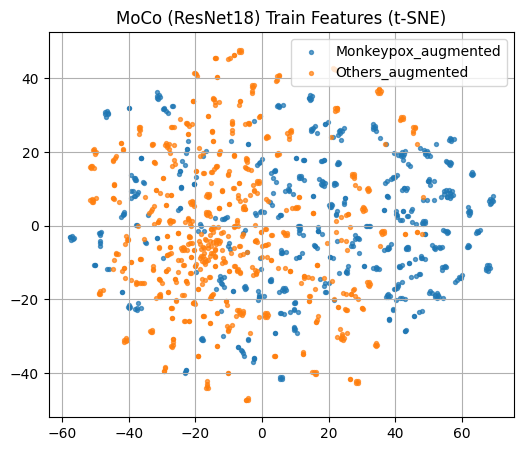

In [10]:
# Cell 10: Build a Plain ResNet-18 Encoder for Visualization + Train Feature t-SNE

# Load encoder for visualization with Identity head (no projection)
encoder_vis = models.resnet18(weights=None)
encoder_vis.fc = nn.Identity()
state = torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"), map_location=DEVICE)

# The saved weights include a projection head (fc) sized PROJ_DIM.
# We load them into a model with Identity fc; only matching layers will load.
missing, unexpected = encoder_vis.load_state_dict(state, strict=False)
# It's normal that 'fc.weight'/'fc.bias' are missing due to Identity.
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

print("Computing t-SNE on TRAIN features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (t-SNE)")
plt.grid(True)
plt.show()


Computing UMAP on TRAIN features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


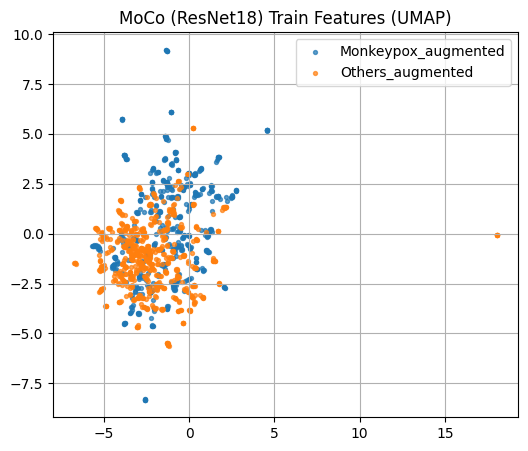

In [11]:
# Cell 11: UMAP on Train Features

print("Computing UMAP on TRAIN features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (UMAP)")
plt.grid(True)
plt.show()


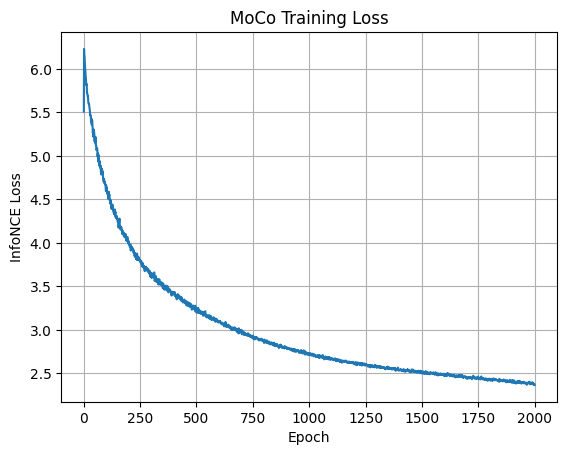

In [12]:
# Cell 12: SSL Loss Curve

plot_curve(moco_loss_history, "MoCo Training Loss", "Epoch", "InfoNCE Loss")


In [13]:
# Cell 13: Linear Evaluation (Train on 20% Train Split)

# Freeze encoder backbone (no projection) for linear eval
encoder_linear = models.resnet18(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"),
                                          map_location=DEVICE), strict=False)
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []   # (we don't have a separate val split here)
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation (training on 20% train split)...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)

        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f}")


Starting linear evaluation (training on 20% train split)...


Linear Epoch 1/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1: TrainLoss=0.6656 Acc=0.560


Linear Epoch 2/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 2: TrainLoss=0.6260 Acc=0.635


Linear Epoch 3/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 3: TrainLoss=0.6010 Acc=0.711


Linear Epoch 4/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 4: TrainLoss=0.5789 Acc=0.746


Linear Epoch 5/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 5: TrainLoss=0.5614 Acc=0.773


Linear Epoch 6/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 6: TrainLoss=0.5466 Acc=0.787


Linear Epoch 7/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 7: TrainLoss=0.5328 Acc=0.791


Linear Epoch 8/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 8: TrainLoss=0.5213 Acc=0.801


Linear Epoch 9/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 9: TrainLoss=0.5094 Acc=0.822


Linear Epoch 10/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 10: TrainLoss=0.4992 Acc=0.829


Linear Epoch 11/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 11: TrainLoss=0.4895 Acc=0.834


Linear Epoch 12/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 12: TrainLoss=0.4803 Acc=0.840


Linear Epoch 13/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 13: TrainLoss=0.4717 Acc=0.843


Linear Epoch 14/2000: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


Linear Epoch 14: TrainLoss=0.4635 Acc=0.846


Linear Epoch 15/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 15: TrainLoss=0.4564 Acc=0.846


Linear Epoch 16/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 16: TrainLoss=0.4488 Acc=0.852


Linear Epoch 17/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 17: TrainLoss=0.4419 Acc=0.851


Linear Epoch 18/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 18: TrainLoss=0.4352 Acc=0.850


Linear Epoch 19/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 19: TrainLoss=0.4290 Acc=0.852


Linear Epoch 20/2000: 100%|██████████| 20/20 [00:02<00:00,  9.20it/s]


Linear Epoch 20: TrainLoss=0.4230 Acc=0.850


Linear Epoch 21/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 21: TrainLoss=0.4171 Acc=0.850


Linear Epoch 22/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 22: TrainLoss=0.4117 Acc=0.851


Linear Epoch 23/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 23: TrainLoss=0.4064 Acc=0.854


Linear Epoch 24/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 24: TrainLoss=0.4011 Acc=0.858


Linear Epoch 25/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 25: TrainLoss=0.3964 Acc=0.859


Linear Epoch 26/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 26: TrainLoss=0.3913 Acc=0.864


Linear Epoch 27/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 27: TrainLoss=0.3868 Acc=0.868


Linear Epoch 28/2000: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


Linear Epoch 28: TrainLoss=0.3823 Acc=0.868


Linear Epoch 29/2000: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Linear Epoch 29: TrainLoss=0.3781 Acc=0.871


Linear Epoch 30/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 30: TrainLoss=0.3740 Acc=0.875


Linear Epoch 31/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 31: TrainLoss=0.3698 Acc=0.875


Linear Epoch 32/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 32: TrainLoss=0.3658 Acc=0.875


Linear Epoch 33/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 33: TrainLoss=0.3620 Acc=0.877


Linear Epoch 34/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 34: TrainLoss=0.3581 Acc=0.878


Linear Epoch 35/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 35: TrainLoss=0.3547 Acc=0.878


Linear Epoch 36/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 36: TrainLoss=0.3509 Acc=0.880


Linear Epoch 37/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 37: TrainLoss=0.3477 Acc=0.884


Linear Epoch 38/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 38: TrainLoss=0.3442 Acc=0.882


Linear Epoch 39/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 39: TrainLoss=0.3409 Acc=0.882


Linear Epoch 40/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 40: TrainLoss=0.3377 Acc=0.895


Linear Epoch 41/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 41: TrainLoss=0.3347 Acc=0.896


Linear Epoch 42/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 42: TrainLoss=0.3317 Acc=0.898


Linear Epoch 43/2000: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Linear Epoch 43: TrainLoss=0.3285 Acc=0.900


Linear Epoch 44/2000: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Linear Epoch 44: TrainLoss=0.3257 Acc=0.902


Linear Epoch 45/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 45: TrainLoss=0.3227 Acc=0.902


Linear Epoch 46/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 46: TrainLoss=0.3199 Acc=0.904


Linear Epoch 47/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 47: TrainLoss=0.3173 Acc=0.907


Linear Epoch 48/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 48: TrainLoss=0.3146 Acc=0.908


Linear Epoch 49/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 49: TrainLoss=0.3119 Acc=0.908


Linear Epoch 50/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 50: TrainLoss=0.3093 Acc=0.908


Linear Epoch 51/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 51: TrainLoss=0.3067 Acc=0.911


Linear Epoch 52/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 52: TrainLoss=0.3041 Acc=0.910


Linear Epoch 53/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 53: TrainLoss=0.3017 Acc=0.912


Linear Epoch 54/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 54: TrainLoss=0.2994 Acc=0.915


Linear Epoch 55/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 55: TrainLoss=0.2971 Acc=0.914


Linear Epoch 56/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 56: TrainLoss=0.2946 Acc=0.915


Linear Epoch 57/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 57: TrainLoss=0.2924 Acc=0.917


Linear Epoch 58/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 58: TrainLoss=0.2902 Acc=0.921


Linear Epoch 59/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 59: TrainLoss=0.2880 Acc=0.920


Linear Epoch 60/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 60: TrainLoss=0.2859 Acc=0.921


Linear Epoch 61/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 61: TrainLoss=0.2837 Acc=0.920


Linear Epoch 62/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 62: TrainLoss=0.2817 Acc=0.923


Linear Epoch 63/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 63: TrainLoss=0.2795 Acc=0.922


Linear Epoch 64/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 64: TrainLoss=0.2775 Acc=0.923


Linear Epoch 65/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 65: TrainLoss=0.2755 Acc=0.923


Linear Epoch 66/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 66: TrainLoss=0.2736 Acc=0.923


Linear Epoch 67/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 67: TrainLoss=0.2718 Acc=0.925


Linear Epoch 68/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 68: TrainLoss=0.2700 Acc=0.923


Linear Epoch 69/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 69: TrainLoss=0.2679 Acc=0.925


Linear Epoch 70/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 70: TrainLoss=0.2660 Acc=0.926


Linear Epoch 71/2000: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


Linear Epoch 71: TrainLoss=0.2643 Acc=0.925


Linear Epoch 72/2000: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Linear Epoch 72: TrainLoss=0.2624 Acc=0.926


Linear Epoch 73/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 73: TrainLoss=0.2606 Acc=0.926


Linear Epoch 74/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 74: TrainLoss=0.2590 Acc=0.927


Linear Epoch 75/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 75: TrainLoss=0.2572 Acc=0.927


Linear Epoch 76/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 76: TrainLoss=0.2557 Acc=0.927


Linear Epoch 77/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 77: TrainLoss=0.2538 Acc=0.928


Linear Epoch 78/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 78: TrainLoss=0.2522 Acc=0.929


Linear Epoch 79/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 79: TrainLoss=0.2505 Acc=0.931


Linear Epoch 80/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 80: TrainLoss=0.2489 Acc=0.930


Linear Epoch 81/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 81: TrainLoss=0.2474 Acc=0.930


Linear Epoch 82/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 82: TrainLoss=0.2459 Acc=0.931


Linear Epoch 83/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 83: TrainLoss=0.2444 Acc=0.931


Linear Epoch 84/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 84: TrainLoss=0.2428 Acc=0.932


Linear Epoch 85/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 85: TrainLoss=0.2412 Acc=0.933


Linear Epoch 86/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 86: TrainLoss=0.2398 Acc=0.933


Linear Epoch 87/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 87: TrainLoss=0.2382 Acc=0.933


Linear Epoch 88/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 88: TrainLoss=0.2368 Acc=0.933


Linear Epoch 89/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 89: TrainLoss=0.2354 Acc=0.934


Linear Epoch 90/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 90: TrainLoss=0.2340 Acc=0.934


Linear Epoch 91/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 91: TrainLoss=0.2326 Acc=0.937


Linear Epoch 92/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 92: TrainLoss=0.2313 Acc=0.936


Linear Epoch 93/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 93: TrainLoss=0.2299 Acc=0.937


Linear Epoch 94/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 94: TrainLoss=0.2285 Acc=0.937


Linear Epoch 95/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 95: TrainLoss=0.2271 Acc=0.938


Linear Epoch 96/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 96: TrainLoss=0.2259 Acc=0.939


Linear Epoch 97/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 97: TrainLoss=0.2246 Acc=0.938


Linear Epoch 98/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 98: TrainLoss=0.2234 Acc=0.939


Linear Epoch 99/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 99: TrainLoss=0.2224 Acc=0.939


Linear Epoch 100/2000: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


Linear Epoch 100: TrainLoss=0.2208 Acc=0.939


Linear Epoch 101/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 101: TrainLoss=0.2195 Acc=0.939


Linear Epoch 102/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 102: TrainLoss=0.2183 Acc=0.940


Linear Epoch 103/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 103: TrainLoss=0.2171 Acc=0.940


Linear Epoch 104/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 104: TrainLoss=0.2158 Acc=0.940


Linear Epoch 105/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 105: TrainLoss=0.2148 Acc=0.940


Linear Epoch 106/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 106: TrainLoss=0.2135 Acc=0.940


Linear Epoch 107/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 107: TrainLoss=0.2124 Acc=0.940


Linear Epoch 108/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 108: TrainLoss=0.2112 Acc=0.941


Linear Epoch 109/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 109: TrainLoss=0.2101 Acc=0.941


Linear Epoch 110/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 110: TrainLoss=0.2090 Acc=0.940


Linear Epoch 111/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 111: TrainLoss=0.2078 Acc=0.941


Linear Epoch 112/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 112: TrainLoss=0.2067 Acc=0.942


Linear Epoch 113/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 113: TrainLoss=0.2057 Acc=0.943


Linear Epoch 114/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 114: TrainLoss=0.2046 Acc=0.944


Linear Epoch 115/2000: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Linear Epoch 115: TrainLoss=0.2035 Acc=0.943


Linear Epoch 116/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 116: TrainLoss=0.2024 Acc=0.944


Linear Epoch 117/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 117: TrainLoss=0.2014 Acc=0.944


Linear Epoch 118/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 118: TrainLoss=0.2003 Acc=0.945


Linear Epoch 119/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 119: TrainLoss=0.1993 Acc=0.945


Linear Epoch 120/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 120: TrainLoss=0.1983 Acc=0.948


Linear Epoch 121/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 121: TrainLoss=0.1973 Acc=0.946


Linear Epoch 122/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 122: TrainLoss=0.1965 Acc=0.948


Linear Epoch 123/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 123: TrainLoss=0.1953 Acc=0.948


Linear Epoch 124/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 124: TrainLoss=0.1944 Acc=0.948


Linear Epoch 125/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 125: TrainLoss=0.1934 Acc=0.949


Linear Epoch 126/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 126: TrainLoss=0.1924 Acc=0.949


Linear Epoch 127/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 127: TrainLoss=0.1914 Acc=0.949


Linear Epoch 128/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 128: TrainLoss=0.1906 Acc=0.948


Linear Epoch 129/2000: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


Linear Epoch 129: TrainLoss=0.1896 Acc=0.949


Linear Epoch 130/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 130: TrainLoss=0.1888 Acc=0.949


Linear Epoch 131/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 131: TrainLoss=0.1877 Acc=0.949


Linear Epoch 132/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 132: TrainLoss=0.1868 Acc=0.949


Linear Epoch 133/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 133: TrainLoss=0.1859 Acc=0.950


Linear Epoch 134/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 134: TrainLoss=0.1852 Acc=0.949


Linear Epoch 135/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 135: TrainLoss=0.1842 Acc=0.950


Linear Epoch 136/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 136: TrainLoss=0.1834 Acc=0.950


Linear Epoch 137/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 137: TrainLoss=0.1826 Acc=0.950


Linear Epoch 138/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 138: TrainLoss=0.1816 Acc=0.950


Linear Epoch 139/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 139: TrainLoss=0.1808 Acc=0.951


Linear Epoch 140/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 140: TrainLoss=0.1799 Acc=0.952


Linear Epoch 141/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 141: TrainLoss=0.1791 Acc=0.951


Linear Epoch 142/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 142: TrainLoss=0.1782 Acc=0.953


Linear Epoch 143/2000: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Linear Epoch 143: TrainLoss=0.1773 Acc=0.953


Linear Epoch 144/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 144: TrainLoss=0.1766 Acc=0.953


Linear Epoch 145/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 145: TrainLoss=0.1758 Acc=0.955


Linear Epoch 146/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 146: TrainLoss=0.1751 Acc=0.954


Linear Epoch 147/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 147: TrainLoss=0.1742 Acc=0.954


Linear Epoch 148/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 148: TrainLoss=0.1734 Acc=0.955


Linear Epoch 149/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 149: TrainLoss=0.1726 Acc=0.955


Linear Epoch 150/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 150: TrainLoss=0.1718 Acc=0.955


Linear Epoch 151/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 151: TrainLoss=0.1710 Acc=0.957


Linear Epoch 152/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 152: TrainLoss=0.1703 Acc=0.956


Linear Epoch 153/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 153: TrainLoss=0.1695 Acc=0.957


Linear Epoch 154/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 154: TrainLoss=0.1687 Acc=0.958


Linear Epoch 155/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 155: TrainLoss=0.1680 Acc=0.959


Linear Epoch 156/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 156: TrainLoss=0.1673 Acc=0.959


Linear Epoch 157/2000: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


Linear Epoch 157: TrainLoss=0.1666 Acc=0.958


Linear Epoch 158/2000: 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Linear Epoch 158: TrainLoss=0.1658 Acc=0.959


Linear Epoch 159/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 159: TrainLoss=0.1651 Acc=0.959


Linear Epoch 160/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 160: TrainLoss=0.1644 Acc=0.959


Linear Epoch 161/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 161: TrainLoss=0.1637 Acc=0.959


Linear Epoch 162/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 162: TrainLoss=0.1630 Acc=0.960


Linear Epoch 163/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 163: TrainLoss=0.1623 Acc=0.962


Linear Epoch 164/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 164: TrainLoss=0.1616 Acc=0.960


Linear Epoch 165/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 165: TrainLoss=0.1609 Acc=0.960


Linear Epoch 166/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 166: TrainLoss=0.1602 Acc=0.962


Linear Epoch 167/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 167: TrainLoss=0.1595 Acc=0.962


Linear Epoch 168/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 168: TrainLoss=0.1588 Acc=0.962


Linear Epoch 169/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 169: TrainLoss=0.1582 Acc=0.962


Linear Epoch 170/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 170: TrainLoss=0.1575 Acc=0.962


Linear Epoch 171/2000: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Linear Epoch 171: TrainLoss=0.1569 Acc=0.962


Linear Epoch 172/2000: 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


Linear Epoch 172: TrainLoss=0.1563 Acc=0.962


Linear Epoch 173/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 173: TrainLoss=0.1556 Acc=0.962


Linear Epoch 174/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 174: TrainLoss=0.1550 Acc=0.963


Linear Epoch 175/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 175: TrainLoss=0.1543 Acc=0.964


Linear Epoch 176/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 176: TrainLoss=0.1537 Acc=0.965


Linear Epoch 177/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 177: TrainLoss=0.1530 Acc=0.965


Linear Epoch 178/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 178: TrainLoss=0.1524 Acc=0.964


Linear Epoch 179/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 179: TrainLoss=0.1517 Acc=0.964


Linear Epoch 180/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 180: TrainLoss=0.1512 Acc=0.963


Linear Epoch 181/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 181: TrainLoss=0.1505 Acc=0.964


Linear Epoch 182/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 182: TrainLoss=0.1499 Acc=0.963


Linear Epoch 183/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 183: TrainLoss=0.1493 Acc=0.964


Linear Epoch 184/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 184: TrainLoss=0.1487 Acc=0.965


Linear Epoch 185/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 185: TrainLoss=0.1481 Acc=0.965


Linear Epoch 186/2000: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Linear Epoch 186: TrainLoss=0.1476 Acc=0.966


Linear Epoch 187/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 187: TrainLoss=0.1469 Acc=0.965


Linear Epoch 188/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 188: TrainLoss=0.1463 Acc=0.966


Linear Epoch 189/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 189: TrainLoss=0.1458 Acc=0.965


Linear Epoch 190/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 190: TrainLoss=0.1453 Acc=0.966


Linear Epoch 191/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 191: TrainLoss=0.1448 Acc=0.967


Linear Epoch 192/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 192: TrainLoss=0.1441 Acc=0.967


Linear Epoch 193/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 193: TrainLoss=0.1435 Acc=0.967


Linear Epoch 194/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 194: TrainLoss=0.1430 Acc=0.967


Linear Epoch 195/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 195: TrainLoss=0.1424 Acc=0.967


Linear Epoch 196/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 196: TrainLoss=0.1419 Acc=0.967


Linear Epoch 197/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 197: TrainLoss=0.1413 Acc=0.967


Linear Epoch 198/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 198: TrainLoss=0.1408 Acc=0.967


Linear Epoch 199/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 199: TrainLoss=0.1402 Acc=0.967


Linear Epoch 200/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 200: TrainLoss=0.1396 Acc=0.967


Linear Epoch 201/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 201: TrainLoss=0.1391 Acc=0.967


Linear Epoch 202/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 202: TrainLoss=0.1386 Acc=0.967


Linear Epoch 203/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 203: TrainLoss=0.1381 Acc=0.968


Linear Epoch 204/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 204: TrainLoss=0.1376 Acc=0.968


Linear Epoch 205/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 205: TrainLoss=0.1370 Acc=0.968


Linear Epoch 206/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 206: TrainLoss=0.1367 Acc=0.968


Linear Epoch 207/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 207: TrainLoss=0.1360 Acc=0.968


Linear Epoch 208/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 208: TrainLoss=0.1355 Acc=0.968


Linear Epoch 209/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 209: TrainLoss=0.1350 Acc=0.968


Linear Epoch 210/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 210: TrainLoss=0.1346 Acc=0.968


Linear Epoch 211/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 211: TrainLoss=0.1340 Acc=0.968


Linear Epoch 212/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 212: TrainLoss=0.1335 Acc=0.968


Linear Epoch 213/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 213: TrainLoss=0.1331 Acc=0.968


Linear Epoch 214/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 214: TrainLoss=0.1325 Acc=0.968


Linear Epoch 215/2000: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Linear Epoch 215: TrainLoss=0.1320 Acc=0.969


Linear Epoch 216/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 216: TrainLoss=0.1317 Acc=0.969


Linear Epoch 217/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 217: TrainLoss=0.1311 Acc=0.968


Linear Epoch 218/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 218: TrainLoss=0.1307 Acc=0.968


Linear Epoch 219/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 219: TrainLoss=0.1301 Acc=0.969


Linear Epoch 220/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 220: TrainLoss=0.1298 Acc=0.969


Linear Epoch 221/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 221: TrainLoss=0.1292 Acc=0.969


Linear Epoch 222/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 222: TrainLoss=0.1289 Acc=0.969


Linear Epoch 223/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 223: TrainLoss=0.1282 Acc=0.969


Linear Epoch 224/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 224: TrainLoss=0.1278 Acc=0.969


Linear Epoch 225/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 225: TrainLoss=0.1275 Acc=0.969


Linear Epoch 226/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 226: TrainLoss=0.1269 Acc=0.969


Linear Epoch 227/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 227: TrainLoss=0.1265 Acc=0.969


Linear Epoch 228/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 228: TrainLoss=0.1260 Acc=0.969


Linear Epoch 229/2000: 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


Linear Epoch 229: TrainLoss=0.1255 Acc=0.969


Linear Epoch 230/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 230: TrainLoss=0.1250 Acc=0.970


Linear Epoch 231/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 231: TrainLoss=0.1248 Acc=0.970


Linear Epoch 232/2000: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Linear Epoch 232: TrainLoss=0.1241 Acc=0.970


Linear Epoch 233/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 233: TrainLoss=0.1238 Acc=0.971


Linear Epoch 234/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 234: TrainLoss=0.1233 Acc=0.971


Linear Epoch 235/2000: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


Linear Epoch 235: TrainLoss=0.1229 Acc=0.971


Linear Epoch 236/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 236: TrainLoss=0.1225 Acc=0.970


Linear Epoch 237/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 237: TrainLoss=0.1221 Acc=0.972


Linear Epoch 238/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 238: TrainLoss=0.1217 Acc=0.971


Linear Epoch 239/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 239: TrainLoss=0.1212 Acc=0.970


Linear Epoch 240/2000: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Linear Epoch 240: TrainLoss=0.1209 Acc=0.970


Linear Epoch 241/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 241: TrainLoss=0.1203 Acc=0.972


Linear Epoch 242/2000: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Linear Epoch 242: TrainLoss=0.1200 Acc=0.972


Linear Epoch 243/2000: 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


Linear Epoch 243: TrainLoss=0.1195 Acc=0.971


Linear Epoch 244/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 244: TrainLoss=0.1191 Acc=0.971


Linear Epoch 245/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 245: TrainLoss=0.1187 Acc=0.971


Linear Epoch 246/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 246: TrainLoss=0.1183 Acc=0.971


Linear Epoch 247/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 247: TrainLoss=0.1179 Acc=0.972


Linear Epoch 248/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 248: TrainLoss=0.1175 Acc=0.971


Linear Epoch 249/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 249: TrainLoss=0.1171 Acc=0.972


Linear Epoch 250/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 250: TrainLoss=0.1167 Acc=0.972


Linear Epoch 251/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 251: TrainLoss=0.1164 Acc=0.973


Linear Epoch 252/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 252: TrainLoss=0.1159 Acc=0.973


Linear Epoch 253/2000: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Linear Epoch 253: TrainLoss=0.1156 Acc=0.973


Linear Epoch 254/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 254: TrainLoss=0.1152 Acc=0.973


Linear Epoch 255/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 255: TrainLoss=0.1148 Acc=0.973


Linear Epoch 256/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 256: TrainLoss=0.1144 Acc=0.973


Linear Epoch 257/2000: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Linear Epoch 257: TrainLoss=0.1140 Acc=0.973


Linear Epoch 258/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 258: TrainLoss=0.1136 Acc=0.973


Linear Epoch 259/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 259: TrainLoss=0.1133 Acc=0.974


Linear Epoch 260/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 260: TrainLoss=0.1129 Acc=0.974


Linear Epoch 261/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 261: TrainLoss=0.1125 Acc=0.974


Linear Epoch 262/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 262: TrainLoss=0.1121 Acc=0.974


Linear Epoch 263/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 263: TrainLoss=0.1118 Acc=0.974


Linear Epoch 264/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 264: TrainLoss=0.1114 Acc=0.974


Linear Epoch 265/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 265: TrainLoss=0.1111 Acc=0.974


Linear Epoch 266/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 266: TrainLoss=0.1108 Acc=0.975


Linear Epoch 267/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 267: TrainLoss=0.1103 Acc=0.975


Linear Epoch 268/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 268: TrainLoss=0.1100 Acc=0.974


Linear Epoch 269/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 269: TrainLoss=0.1096 Acc=0.976


Linear Epoch 270/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 270: TrainLoss=0.1092 Acc=0.976


Linear Epoch 271/2000: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Linear Epoch 271: TrainLoss=0.1089 Acc=0.976


Linear Epoch 272/2000: 100%|██████████| 20/20 [00:02<00:00,  7.56it/s]


Linear Epoch 272: TrainLoss=0.1086 Acc=0.976


Linear Epoch 273/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 273: TrainLoss=0.1082 Acc=0.976


Linear Epoch 274/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 274: TrainLoss=0.1079 Acc=0.976


Linear Epoch 275/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 275: TrainLoss=0.1075 Acc=0.976


Linear Epoch 276/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 276: TrainLoss=0.1072 Acc=0.976


Linear Epoch 277/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 277: TrainLoss=0.1068 Acc=0.976


Linear Epoch 278/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 278: TrainLoss=0.1065 Acc=0.977


Linear Epoch 279/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 279: TrainLoss=0.1062 Acc=0.978


Linear Epoch 280/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 280: TrainLoss=0.1058 Acc=0.977


Linear Epoch 281/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 281: TrainLoss=0.1055 Acc=0.979


Linear Epoch 282/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 282: TrainLoss=0.1052 Acc=0.978


Linear Epoch 283/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 283: TrainLoss=0.1048 Acc=0.979


Linear Epoch 284/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 284: TrainLoss=0.1045 Acc=0.980


Linear Epoch 285/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 285: TrainLoss=0.1042 Acc=0.980


Linear Epoch 286/2000: 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


Linear Epoch 286: TrainLoss=0.1039 Acc=0.980


Linear Epoch 287/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 287: TrainLoss=0.1035 Acc=0.980


Linear Epoch 288/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 288: TrainLoss=0.1032 Acc=0.980


Linear Epoch 289/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 289: TrainLoss=0.1029 Acc=0.980


Linear Epoch 290/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 290: TrainLoss=0.1026 Acc=0.980


Linear Epoch 291/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 291: TrainLoss=0.1023 Acc=0.980


Linear Epoch 292/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 292: TrainLoss=0.1019 Acc=0.980


Linear Epoch 293/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 293: TrainLoss=0.1016 Acc=0.980


Linear Epoch 294/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 294: TrainLoss=0.1014 Acc=0.980


Linear Epoch 295/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 295: TrainLoss=0.1010 Acc=0.980


Linear Epoch 296/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 296: TrainLoss=0.1006 Acc=0.980


Linear Epoch 297/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 297: TrainLoss=0.1004 Acc=0.980


Linear Epoch 298/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 298: TrainLoss=0.1000 Acc=0.980


Linear Epoch 299/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 299: TrainLoss=0.0998 Acc=0.980


Linear Epoch 300/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 300: TrainLoss=0.0994 Acc=0.980


Linear Epoch 301/2000: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Linear Epoch 301: TrainLoss=0.0991 Acc=0.980


Linear Epoch 302/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 302: TrainLoss=0.0988 Acc=0.980


Linear Epoch 303/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 303: TrainLoss=0.0985 Acc=0.980


Linear Epoch 304/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 304: TrainLoss=0.0982 Acc=0.980


Linear Epoch 305/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 305: TrainLoss=0.0980 Acc=0.980


Linear Epoch 306/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 306: TrainLoss=0.0977 Acc=0.980


Linear Epoch 307/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 307: TrainLoss=0.0973 Acc=0.980


Linear Epoch 308/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 308: TrainLoss=0.0971 Acc=0.980


Linear Epoch 309/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 309: TrainLoss=0.0968 Acc=0.980


Linear Epoch 310/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 310: TrainLoss=0.0965 Acc=0.980


Linear Epoch 311/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 311: TrainLoss=0.0962 Acc=0.980


Linear Epoch 312/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 312: TrainLoss=0.0959 Acc=0.980


Linear Epoch 313/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 313: TrainLoss=0.0956 Acc=0.980


Linear Epoch 314/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 314: TrainLoss=0.0953 Acc=0.980


Linear Epoch 315/2000: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Linear Epoch 315: TrainLoss=0.0951 Acc=0.980


Linear Epoch 316/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 316: TrainLoss=0.0947 Acc=0.980


Linear Epoch 317/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 317: TrainLoss=0.0945 Acc=0.980


Linear Epoch 318/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 318: TrainLoss=0.0942 Acc=0.980


Linear Epoch 319/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 319: TrainLoss=0.0939 Acc=0.980


Linear Epoch 320/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 320: TrainLoss=0.0937 Acc=0.980


Linear Epoch 321/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 321: TrainLoss=0.0934 Acc=0.980


Linear Epoch 322/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 322: TrainLoss=0.0931 Acc=0.980


Linear Epoch 323/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 323: TrainLoss=0.0928 Acc=0.980


Linear Epoch 324/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 324: TrainLoss=0.0926 Acc=0.980


Linear Epoch 325/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 325: TrainLoss=0.0923 Acc=0.980


Linear Epoch 326/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 326: TrainLoss=0.0920 Acc=0.982


Linear Epoch 327/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 327: TrainLoss=0.0917 Acc=0.982


Linear Epoch 328/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 328: TrainLoss=0.0915 Acc=0.981


Linear Epoch 329/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 329: TrainLoss=0.0912 Acc=0.981


Linear Epoch 330/2000: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Linear Epoch 330: TrainLoss=0.0910 Acc=0.981


Linear Epoch 331/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 331: TrainLoss=0.0907 Acc=0.981


Linear Epoch 332/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 332: TrainLoss=0.0906 Acc=0.982


Linear Epoch 333/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 333: TrainLoss=0.0902 Acc=0.982


Linear Epoch 334/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 334: TrainLoss=0.0899 Acc=0.981


Linear Epoch 335/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 335: TrainLoss=0.0897 Acc=0.981


Linear Epoch 336/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 336: TrainLoss=0.0894 Acc=0.982


Linear Epoch 337/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 337: TrainLoss=0.0891 Acc=0.982


Linear Epoch 338/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 338: TrainLoss=0.0889 Acc=0.982


Linear Epoch 339/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 339: TrainLoss=0.0886 Acc=0.982


Linear Epoch 340/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 340: TrainLoss=0.0884 Acc=0.982


Linear Epoch 341/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 341: TrainLoss=0.0882 Acc=0.981


Linear Epoch 342/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 342: TrainLoss=0.0879 Acc=0.982


Linear Epoch 343/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 343: TrainLoss=0.0876 Acc=0.982


Linear Epoch 344/2000: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Linear Epoch 344: TrainLoss=0.0874 Acc=0.982


Linear Epoch 345/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 345: TrainLoss=0.0873 Acc=0.981


Linear Epoch 346/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 346: TrainLoss=0.0870 Acc=0.982


Linear Epoch 347/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 347: TrainLoss=0.0867 Acc=0.982


Linear Epoch 348/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 348: TrainLoss=0.0864 Acc=0.982


Linear Epoch 349/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 349: TrainLoss=0.0862 Acc=0.982


Linear Epoch 350/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 350: TrainLoss=0.0859 Acc=0.982


Linear Epoch 351/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 351: TrainLoss=0.0857 Acc=0.982


Linear Epoch 352/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 352: TrainLoss=0.0854 Acc=0.982


Linear Epoch 353/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 353: TrainLoss=0.0852 Acc=0.982


Linear Epoch 354/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 354: TrainLoss=0.0850 Acc=0.982


Linear Epoch 355/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 355: TrainLoss=0.0848 Acc=0.982


Linear Epoch 356/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 356: TrainLoss=0.0845 Acc=0.982


Linear Epoch 357/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 357: TrainLoss=0.0843 Acc=0.982


Linear Epoch 358/2000: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


Linear Epoch 358: TrainLoss=0.0841 Acc=0.983


Linear Epoch 359/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 359: TrainLoss=0.0838 Acc=0.982


Linear Epoch 360/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 360: TrainLoss=0.0836 Acc=0.982


Linear Epoch 361/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 361: TrainLoss=0.0834 Acc=0.983


Linear Epoch 362/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 362: TrainLoss=0.0831 Acc=0.983


Linear Epoch 363/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 363: TrainLoss=0.0829 Acc=0.984


Linear Epoch 364/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 364: TrainLoss=0.0827 Acc=0.984


Linear Epoch 365/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 365: TrainLoss=0.0825 Acc=0.984


Linear Epoch 366/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 366: TrainLoss=0.0822 Acc=0.984


Linear Epoch 367/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 367: TrainLoss=0.0820 Acc=0.984


Linear Epoch 368/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 368: TrainLoss=0.0818 Acc=0.984


Linear Epoch 369/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 369: TrainLoss=0.0816 Acc=0.984


Linear Epoch 370/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 370: TrainLoss=0.0813 Acc=0.984


Linear Epoch 371/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 371: TrainLoss=0.0812 Acc=0.984


Linear Epoch 372/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 372: TrainLoss=0.0809 Acc=0.984


Linear Epoch 373/2000: 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


Linear Epoch 373: TrainLoss=0.0807 Acc=0.984


Linear Epoch 374/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 374: TrainLoss=0.0804 Acc=0.984


Linear Epoch 375/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 375: TrainLoss=0.0803 Acc=0.984


Linear Epoch 376/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 376: TrainLoss=0.0800 Acc=0.984


Linear Epoch 377/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 377: TrainLoss=0.0798 Acc=0.984


Linear Epoch 378/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 378: TrainLoss=0.0797 Acc=0.984


Linear Epoch 379/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 379: TrainLoss=0.0795 Acc=0.984


Linear Epoch 380/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 380: TrainLoss=0.0793 Acc=0.984


Linear Epoch 381/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 381: TrainLoss=0.0791 Acc=0.984


Linear Epoch 382/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 382: TrainLoss=0.0788 Acc=0.984


Linear Epoch 383/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 383: TrainLoss=0.0786 Acc=0.984


Linear Epoch 384/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 384: TrainLoss=0.0783 Acc=0.984


Linear Epoch 385/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 385: TrainLoss=0.0782 Acc=0.984


Linear Epoch 386/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 386: TrainLoss=0.0779 Acc=0.984


Linear Epoch 387/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 387: TrainLoss=0.0778 Acc=0.984


Linear Epoch 388/2000: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


Linear Epoch 388: TrainLoss=0.0775 Acc=0.984


Linear Epoch 389/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 389: TrainLoss=0.0773 Acc=0.984


Linear Epoch 390/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 390: TrainLoss=0.0771 Acc=0.984


Linear Epoch 391/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 391: TrainLoss=0.0769 Acc=0.984


Linear Epoch 392/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 392: TrainLoss=0.0767 Acc=0.985


Linear Epoch 393/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 393: TrainLoss=0.0765 Acc=0.984


Linear Epoch 394/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 394: TrainLoss=0.0763 Acc=0.984


Linear Epoch 395/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 395: TrainLoss=0.0761 Acc=0.985


Linear Epoch 396/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 396: TrainLoss=0.0759 Acc=0.984


Linear Epoch 397/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 397: TrainLoss=0.0757 Acc=0.984


Linear Epoch 398/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 398: TrainLoss=0.0755 Acc=0.984


Linear Epoch 399/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 399: TrainLoss=0.0753 Acc=0.985


Linear Epoch 400/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 400: TrainLoss=0.0751 Acc=0.985


Linear Epoch 401/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 401: TrainLoss=0.0750 Acc=0.984


Linear Epoch 402/2000: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Linear Epoch 402: TrainLoss=0.0748 Acc=0.985


Linear Epoch 403/2000: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Linear Epoch 403: TrainLoss=0.0746 Acc=0.985


Linear Epoch 404/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 404: TrainLoss=0.0743 Acc=0.985


Linear Epoch 405/2000: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Linear Epoch 405: TrainLoss=0.0742 Acc=0.985


Linear Epoch 406/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 406: TrainLoss=0.0740 Acc=0.985


Linear Epoch 407/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 407: TrainLoss=0.0738 Acc=0.985


Linear Epoch 408/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 408: TrainLoss=0.0736 Acc=0.985


Linear Epoch 409/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 409: TrainLoss=0.0734 Acc=0.985


Linear Epoch 410/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 410: TrainLoss=0.0733 Acc=0.985


Linear Epoch 411/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 411: TrainLoss=0.0730 Acc=0.985


Linear Epoch 412/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 412: TrainLoss=0.0728 Acc=0.985


Linear Epoch 413/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 413: TrainLoss=0.0727 Acc=0.985


Linear Epoch 414/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 414: TrainLoss=0.0725 Acc=0.985


Linear Epoch 415/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 415: TrainLoss=0.0723 Acc=0.985


Linear Epoch 416/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 416: TrainLoss=0.0721 Acc=0.985


Linear Epoch 417/2000: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Linear Epoch 417: TrainLoss=0.0720 Acc=0.986


Linear Epoch 418/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 418: TrainLoss=0.0717 Acc=0.986


Linear Epoch 419/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 419: TrainLoss=0.0716 Acc=0.986


Linear Epoch 420/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 420: TrainLoss=0.0714 Acc=0.986


Linear Epoch 421/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 421: TrainLoss=0.0713 Acc=0.987


Linear Epoch 422/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 422: TrainLoss=0.0710 Acc=0.986


Linear Epoch 423/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 423: TrainLoss=0.0709 Acc=0.986


Linear Epoch 424/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 424: TrainLoss=0.0707 Acc=0.987


Linear Epoch 425/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 425: TrainLoss=0.0705 Acc=0.987


Linear Epoch 426/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 426: TrainLoss=0.0704 Acc=0.986


Linear Epoch 427/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 427: TrainLoss=0.0702 Acc=0.987


Linear Epoch 428/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 428: TrainLoss=0.0700 Acc=0.987


Linear Epoch 429/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 429: TrainLoss=0.0698 Acc=0.987


Linear Epoch 430/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 430: TrainLoss=0.0697 Acc=0.987


Linear Epoch 431/2000: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


Linear Epoch 431: TrainLoss=0.0694 Acc=0.987


Linear Epoch 432/2000: 100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


Linear Epoch 432: TrainLoss=0.0693 Acc=0.986


Linear Epoch 433/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 433: TrainLoss=0.0691 Acc=0.987


Linear Epoch 434/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 434: TrainLoss=0.0690 Acc=0.987


Linear Epoch 435/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 435: TrainLoss=0.0688 Acc=0.987


Linear Epoch 436/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 436: TrainLoss=0.0686 Acc=0.987


Linear Epoch 437/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 437: TrainLoss=0.0684 Acc=0.987


Linear Epoch 438/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 438: TrainLoss=0.0683 Acc=0.987


Linear Epoch 439/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 439: TrainLoss=0.0682 Acc=0.987


Linear Epoch 440/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 440: TrainLoss=0.0679 Acc=0.988


Linear Epoch 441/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 441: TrainLoss=0.0677 Acc=0.987


Linear Epoch 442/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 442: TrainLoss=0.0676 Acc=0.988


Linear Epoch 443/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 443: TrainLoss=0.0675 Acc=0.988


Linear Epoch 444/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 444: TrainLoss=0.0673 Acc=0.988


Linear Epoch 445/2000: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Linear Epoch 445: TrainLoss=0.0671 Acc=0.987


Linear Epoch 446/2000: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Linear Epoch 446: TrainLoss=0.0669 Acc=0.988


Linear Epoch 447/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 447: TrainLoss=0.0668 Acc=0.988


Linear Epoch 448/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 448: TrainLoss=0.0666 Acc=0.989


Linear Epoch 449/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 449: TrainLoss=0.0665 Acc=0.988


Linear Epoch 450/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 450: TrainLoss=0.0663 Acc=0.988


Linear Epoch 451/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 451: TrainLoss=0.0661 Acc=0.988


Linear Epoch 452/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 452: TrainLoss=0.0660 Acc=0.988


Linear Epoch 453/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 453: TrainLoss=0.0658 Acc=0.989


Linear Epoch 454/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 454: TrainLoss=0.0656 Acc=0.989


Linear Epoch 455/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 455: TrainLoss=0.0655 Acc=0.989


Linear Epoch 456/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 456: TrainLoss=0.0653 Acc=0.989


Linear Epoch 457/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 457: TrainLoss=0.0652 Acc=0.989


Linear Epoch 458/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 458: TrainLoss=0.0650 Acc=0.989


Linear Epoch 459/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 459: TrainLoss=0.0649 Acc=0.989


Linear Epoch 460/2000: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Linear Epoch 460: TrainLoss=0.0647 Acc=0.991


Linear Epoch 461/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 461: TrainLoss=0.0645 Acc=0.990


Linear Epoch 462/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 462: TrainLoss=0.0644 Acc=0.990


Linear Epoch 463/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 463: TrainLoss=0.0643 Acc=0.989


Linear Epoch 464/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 464: TrainLoss=0.0641 Acc=0.989


Linear Epoch 465/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 465: TrainLoss=0.0639 Acc=0.990


Linear Epoch 466/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 466: TrainLoss=0.0638 Acc=0.990


Linear Epoch 467/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 467: TrainLoss=0.0636 Acc=0.991


Linear Epoch 468/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 468: TrainLoss=0.0635 Acc=0.989


Linear Epoch 469/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 469: TrainLoss=0.0634 Acc=0.990


Linear Epoch 470/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 470: TrainLoss=0.0633 Acc=0.990


Linear Epoch 471/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 471: TrainLoss=0.0630 Acc=0.991


Linear Epoch 472/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 472: TrainLoss=0.0629 Acc=0.990


Linear Epoch 473/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 473: TrainLoss=0.0628 Acc=0.990


Linear Epoch 474/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 474: TrainLoss=0.0626 Acc=0.991


Linear Epoch 475/2000: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Linear Epoch 475: TrainLoss=0.0625 Acc=0.990


Linear Epoch 476/2000: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Linear Epoch 476: TrainLoss=0.0623 Acc=0.990


Linear Epoch 477/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 477: TrainLoss=0.0622 Acc=0.990


Linear Epoch 478/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 478: TrainLoss=0.0620 Acc=0.990


Linear Epoch 479/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 479: TrainLoss=0.0619 Acc=0.991


Linear Epoch 480/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 480: TrainLoss=0.0617 Acc=0.991


Linear Epoch 481/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 481: TrainLoss=0.0615 Acc=0.991


Linear Epoch 482/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 482: TrainLoss=0.0615 Acc=0.991


Linear Epoch 483/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 483: TrainLoss=0.0612 Acc=0.991


Linear Epoch 484/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 484: TrainLoss=0.0612 Acc=0.990


Linear Epoch 485/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 485: TrainLoss=0.0610 Acc=0.991


Linear Epoch 486/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 486: TrainLoss=0.0609 Acc=0.991


Linear Epoch 487/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 487: TrainLoss=0.0607 Acc=0.991


Linear Epoch 488/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 488: TrainLoss=0.0605 Acc=0.991


Linear Epoch 489/2000: 100%|██████████| 20/20 [00:02<00:00,  7.60it/s]


Linear Epoch 489: TrainLoss=0.0604 Acc=0.991


Linear Epoch 490/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 490: TrainLoss=0.0603 Acc=0.991


Linear Epoch 491/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 491: TrainLoss=0.0601 Acc=0.991


Linear Epoch 492/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 492: TrainLoss=0.0600 Acc=0.991


Linear Epoch 493/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 493: TrainLoss=0.0598 Acc=0.991


Linear Epoch 494/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 494: TrainLoss=0.0597 Acc=0.991


Linear Epoch 495/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 495: TrainLoss=0.0596 Acc=0.991


Linear Epoch 496/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 496: TrainLoss=0.0594 Acc=0.991


Linear Epoch 497/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 497: TrainLoss=0.0593 Acc=0.991


Linear Epoch 498/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 498: TrainLoss=0.0591 Acc=0.991


Linear Epoch 499/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 499: TrainLoss=0.0591 Acc=0.991


Linear Epoch 500/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 500: TrainLoss=0.0589 Acc=0.991


Linear Epoch 501/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 501: TrainLoss=0.0588 Acc=0.991


Linear Epoch 502/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 502: TrainLoss=0.0587 Acc=0.991


Linear Epoch 503/2000: 100%|██████████| 20/20 [00:02<00:00,  7.79it/s]


Linear Epoch 503: TrainLoss=0.0585 Acc=0.991


Linear Epoch 504/2000: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


Linear Epoch 504: TrainLoss=0.0584 Acc=0.991


Linear Epoch 505/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 505: TrainLoss=0.0583 Acc=0.991


Linear Epoch 506/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 506: TrainLoss=0.0581 Acc=0.991


Linear Epoch 507/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 507: TrainLoss=0.0580 Acc=0.991


Linear Epoch 508/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 508: TrainLoss=0.0578 Acc=0.991


Linear Epoch 509/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 509: TrainLoss=0.0577 Acc=0.991


Linear Epoch 510/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 510: TrainLoss=0.0575 Acc=0.992


Linear Epoch 511/2000: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Linear Epoch 511: TrainLoss=0.0574 Acc=0.992


Linear Epoch 512/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 512: TrainLoss=0.0573 Acc=0.991


Linear Epoch 513/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 513: TrainLoss=0.0572 Acc=0.992


Linear Epoch 514/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 514: TrainLoss=0.0571 Acc=0.992


Linear Epoch 515/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 515: TrainLoss=0.0569 Acc=0.992


Linear Epoch 516/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 516: TrainLoss=0.0569 Acc=0.992


Linear Epoch 517/2000: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


Linear Epoch 517: TrainLoss=0.0567 Acc=0.992


Linear Epoch 518/2000: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Linear Epoch 518: TrainLoss=0.0566 Acc=0.992


Linear Epoch 519/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 519: TrainLoss=0.0564 Acc=0.992


Linear Epoch 520/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 520: TrainLoss=0.0563 Acc=0.992


Linear Epoch 521/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 521: TrainLoss=0.0562 Acc=0.992


Linear Epoch 522/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 522: TrainLoss=0.0561 Acc=0.992


Linear Epoch 523/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 523: TrainLoss=0.0560 Acc=0.992


Linear Epoch 524/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 524: TrainLoss=0.0558 Acc=0.992


Linear Epoch 525/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 525: TrainLoss=0.0557 Acc=0.992


Linear Epoch 526/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 526: TrainLoss=0.0555 Acc=0.992


Linear Epoch 527/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 527: TrainLoss=0.0554 Acc=0.992


Linear Epoch 528/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 528: TrainLoss=0.0553 Acc=0.992


Linear Epoch 529/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 529: TrainLoss=0.0551 Acc=0.992


Linear Epoch 530/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 530: TrainLoss=0.0550 Acc=0.992


Linear Epoch 531/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 531: TrainLoss=0.0549 Acc=0.992


Linear Epoch 532/2000: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]


Linear Epoch 532: TrainLoss=0.0548 Acc=0.992


Linear Epoch 533/2000: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


Linear Epoch 533: TrainLoss=0.0547 Acc=0.992


Linear Epoch 534/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 534: TrainLoss=0.0545 Acc=0.992


Linear Epoch 535/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 535: TrainLoss=0.0544 Acc=0.992


Linear Epoch 536/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 536: TrainLoss=0.0543 Acc=0.992


Linear Epoch 537/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 537: TrainLoss=0.0542 Acc=0.992


Linear Epoch 538/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 538: TrainLoss=0.0541 Acc=0.992


Linear Epoch 539/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 539: TrainLoss=0.0539 Acc=0.992


Linear Epoch 540/2000: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Linear Epoch 540: TrainLoss=0.0538 Acc=0.993


Linear Epoch 541/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 541: TrainLoss=0.0537 Acc=0.992


Linear Epoch 542/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 542: TrainLoss=0.0535 Acc=0.992


Linear Epoch 543/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 543: TrainLoss=0.0534 Acc=0.992


Linear Epoch 544/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 544: TrainLoss=0.0534 Acc=0.992


Linear Epoch 545/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 545: TrainLoss=0.0532 Acc=0.992


Linear Epoch 546/2000: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


Linear Epoch 546: TrainLoss=0.0531 Acc=0.992


Linear Epoch 547/2000: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Linear Epoch 547: TrainLoss=0.0530 Acc=0.992


Linear Epoch 548/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 548: TrainLoss=0.0529 Acc=0.993


Linear Epoch 549/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 549: TrainLoss=0.0528 Acc=0.993


Linear Epoch 550/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 550: TrainLoss=0.0527 Acc=0.992


Linear Epoch 551/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 551: TrainLoss=0.0525 Acc=0.993


Linear Epoch 552/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 552: TrainLoss=0.0524 Acc=0.993


Linear Epoch 553/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 553: TrainLoss=0.0523 Acc=0.993


Linear Epoch 554/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 554: TrainLoss=0.0522 Acc=0.993


Linear Epoch 555/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 555: TrainLoss=0.0521 Acc=0.993


Linear Epoch 556/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 556: TrainLoss=0.0520 Acc=0.993


Linear Epoch 557/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 557: TrainLoss=0.0518 Acc=0.993


Linear Epoch 558/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 558: TrainLoss=0.0517 Acc=0.993


Linear Epoch 559/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 559: TrainLoss=0.0516 Acc=0.993


Linear Epoch 560/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 560: TrainLoss=0.0515 Acc=0.993


Linear Epoch 561/2000: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Linear Epoch 561: TrainLoss=0.0514 Acc=0.993


Linear Epoch 562/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 562: TrainLoss=0.0513 Acc=0.993


Linear Epoch 563/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 563: TrainLoss=0.0512 Acc=0.993


Linear Epoch 564/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 564: TrainLoss=0.0511 Acc=0.993


Linear Epoch 565/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 565: TrainLoss=0.0509 Acc=0.993


Linear Epoch 566/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 566: TrainLoss=0.0509 Acc=0.993


Linear Epoch 567/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 567: TrainLoss=0.0507 Acc=0.993


Linear Epoch 568/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 568: TrainLoss=0.0506 Acc=0.993


Linear Epoch 569/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 569: TrainLoss=0.0506 Acc=0.993


Linear Epoch 570/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 570: TrainLoss=0.0504 Acc=0.993


Linear Epoch 571/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 571: TrainLoss=0.0503 Acc=0.993


Linear Epoch 572/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 572: TrainLoss=0.0502 Acc=0.993


Linear Epoch 573/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 573: TrainLoss=0.0501 Acc=0.993


Linear Epoch 574/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 574: TrainLoss=0.0500 Acc=0.993


Linear Epoch 575/2000: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


Linear Epoch 575: TrainLoss=0.0498 Acc=0.993


Linear Epoch 576/2000: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


Linear Epoch 576: TrainLoss=0.0498 Acc=0.993


Linear Epoch 577/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 577: TrainLoss=0.0496 Acc=0.993


Linear Epoch 578/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 578: TrainLoss=0.0496 Acc=0.993


Linear Epoch 579/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 579: TrainLoss=0.0494 Acc=0.993


Linear Epoch 580/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 580: TrainLoss=0.0494 Acc=0.993


Linear Epoch 581/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 581: TrainLoss=0.0492 Acc=0.993


Linear Epoch 582/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 582: TrainLoss=0.0491 Acc=0.993


Linear Epoch 583/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 583: TrainLoss=0.0491 Acc=0.993


Linear Epoch 584/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 584: TrainLoss=0.0489 Acc=0.993


Linear Epoch 585/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 585: TrainLoss=0.0488 Acc=0.993


Linear Epoch 586/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 586: TrainLoss=0.0487 Acc=0.993


Linear Epoch 587/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 587: TrainLoss=0.0487 Acc=0.993


Linear Epoch 588/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 588: TrainLoss=0.0485 Acc=0.993


Linear Epoch 589/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 589: TrainLoss=0.0484 Acc=0.993


Linear Epoch 590/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 590: TrainLoss=0.0483 Acc=0.993


Linear Epoch 591/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 591: TrainLoss=0.0482 Acc=0.993


Linear Epoch 592/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 592: TrainLoss=0.0481 Acc=0.993


Linear Epoch 593/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 593: TrainLoss=0.0480 Acc=0.993


Linear Epoch 594/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 594: TrainLoss=0.0479 Acc=0.993


Linear Epoch 595/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 595: TrainLoss=0.0478 Acc=0.993


Linear Epoch 596/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 596: TrainLoss=0.0477 Acc=0.993


Linear Epoch 597/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 597: TrainLoss=0.0476 Acc=0.993


Linear Epoch 598/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 598: TrainLoss=0.0475 Acc=0.993


Linear Epoch 599/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 599: TrainLoss=0.0475 Acc=0.993


Linear Epoch 600/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 600: TrainLoss=0.0473 Acc=0.993


Linear Epoch 601/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 601: TrainLoss=0.0472 Acc=0.993


Linear Epoch 602/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 602: TrainLoss=0.0471 Acc=0.993


Linear Epoch 603/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 603: TrainLoss=0.0471 Acc=0.993


Linear Epoch 604/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 604: TrainLoss=0.0468 Acc=0.993


Linear Epoch 605/2000: 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


Linear Epoch 605: TrainLoss=0.0468 Acc=0.993


Linear Epoch 606/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 606: TrainLoss=0.0467 Acc=0.993


Linear Epoch 607/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 607: TrainLoss=0.0466 Acc=0.993


Linear Epoch 608/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 608: TrainLoss=0.0465 Acc=0.993


Linear Epoch 609/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 609: TrainLoss=0.0464 Acc=0.993


Linear Epoch 610/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 610: TrainLoss=0.0463 Acc=0.993


Linear Epoch 611/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 611: TrainLoss=0.0462 Acc=0.993


Linear Epoch 612/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 612: TrainLoss=0.0461 Acc=0.993


Linear Epoch 613/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 613: TrainLoss=0.0460 Acc=0.993


Linear Epoch 614/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 614: TrainLoss=0.0459 Acc=0.993


Linear Epoch 615/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 615: TrainLoss=0.0458 Acc=0.993


Linear Epoch 616/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 616: TrainLoss=0.0457 Acc=0.993


Linear Epoch 617/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 617: TrainLoss=0.0456 Acc=0.993


Linear Epoch 618/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 618: TrainLoss=0.0455 Acc=0.993


Linear Epoch 619/2000: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Linear Epoch 619: TrainLoss=0.0454 Acc=0.993


Linear Epoch 620/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 620: TrainLoss=0.0453 Acc=0.993


Linear Epoch 621/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 621: TrainLoss=0.0452 Acc=0.993


Linear Epoch 622/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 622: TrainLoss=0.0451 Acc=0.993


Linear Epoch 623/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 623: TrainLoss=0.0450 Acc=0.993


Linear Epoch 624/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 624: TrainLoss=0.0449 Acc=0.993


Linear Epoch 625/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 625: TrainLoss=0.0449 Acc=0.993


Linear Epoch 626/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 626: TrainLoss=0.0448 Acc=0.993


Linear Epoch 627/2000: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Linear Epoch 627: TrainLoss=0.0447 Acc=0.993


Linear Epoch 628/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 628: TrainLoss=0.0446 Acc=0.993


Linear Epoch 629/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 629: TrainLoss=0.0445 Acc=0.993


Linear Epoch 630/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 630: TrainLoss=0.0444 Acc=0.993


Linear Epoch 631/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 631: TrainLoss=0.0443 Acc=0.993


Linear Epoch 632/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 632: TrainLoss=0.0442 Acc=0.993


Linear Epoch 633/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 633: TrainLoss=0.0441 Acc=0.993


Linear Epoch 634/2000: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Linear Epoch 634: TrainLoss=0.0440 Acc=0.993


Linear Epoch 635/2000: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Linear Epoch 635: TrainLoss=0.0440 Acc=0.993


Linear Epoch 636/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 636: TrainLoss=0.0438 Acc=0.993


Linear Epoch 637/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 637: TrainLoss=0.0438 Acc=0.993


Linear Epoch 638/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 638: TrainLoss=0.0437 Acc=0.993


Linear Epoch 639/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 639: TrainLoss=0.0436 Acc=0.993


Linear Epoch 640/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 640: TrainLoss=0.0435 Acc=0.993


Linear Epoch 641/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 641: TrainLoss=0.0434 Acc=0.993


Linear Epoch 642/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 642: TrainLoss=0.0433 Acc=0.993


Linear Epoch 643/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 643: TrainLoss=0.0432 Acc=0.993


Linear Epoch 644/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 644: TrainLoss=0.0431 Acc=0.993


Linear Epoch 645/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 645: TrainLoss=0.0430 Acc=0.993


Linear Epoch 646/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 646: TrainLoss=0.0429 Acc=0.993


Linear Epoch 647/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 647: TrainLoss=0.0429 Acc=0.993


Linear Epoch 648/2000: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Linear Epoch 648: TrainLoss=0.0428 Acc=0.993


Linear Epoch 649/2000: 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


Linear Epoch 649: TrainLoss=0.0427 Acc=0.993


Linear Epoch 650/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 650: TrainLoss=0.0426 Acc=0.993


Linear Epoch 651/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 651: TrainLoss=0.0425 Acc=0.993


Linear Epoch 652/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 652: TrainLoss=0.0424 Acc=0.993


Linear Epoch 653/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 653: TrainLoss=0.0424 Acc=0.993


Linear Epoch 654/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 654: TrainLoss=0.0423 Acc=0.993


Linear Epoch 655/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 655: TrainLoss=0.0422 Acc=0.993


Linear Epoch 656/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 656: TrainLoss=0.0421 Acc=0.993


Linear Epoch 657/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 657: TrainLoss=0.0420 Acc=0.993


Linear Epoch 658/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 658: TrainLoss=0.0419 Acc=0.993


Linear Epoch 659/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 659: TrainLoss=0.0418 Acc=0.993


Linear Epoch 660/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 660: TrainLoss=0.0418 Acc=0.993


Linear Epoch 661/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 661: TrainLoss=0.0417 Acc=0.993


Linear Epoch 662/2000: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Linear Epoch 662: TrainLoss=0.0416 Acc=0.993


Linear Epoch 663/2000: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Linear Epoch 663: TrainLoss=0.0415 Acc=0.993


Linear Epoch 664/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 664: TrainLoss=0.0414 Acc=0.994


Linear Epoch 665/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 665: TrainLoss=0.0413 Acc=0.994


Linear Epoch 666/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 666: TrainLoss=0.0412 Acc=0.994


Linear Epoch 667/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 667: TrainLoss=0.0411 Acc=0.994


Linear Epoch 668/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 668: TrainLoss=0.0411 Acc=0.994


Linear Epoch 669/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 669: TrainLoss=0.0410 Acc=0.994


Linear Epoch 670/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 670: TrainLoss=0.0409 Acc=0.994


Linear Epoch 671/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 671: TrainLoss=0.0408 Acc=0.994


Linear Epoch 672/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 672: TrainLoss=0.0407 Acc=0.994


Linear Epoch 673/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 673: TrainLoss=0.0407 Acc=0.994


Linear Epoch 674/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 674: TrainLoss=0.0406 Acc=0.994


Linear Epoch 675/2000: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Linear Epoch 675: TrainLoss=0.0405 Acc=0.994


Linear Epoch 676/2000: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


Linear Epoch 676: TrainLoss=0.0404 Acc=0.994


Linear Epoch 677/2000: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


Linear Epoch 677: TrainLoss=0.0404 Acc=0.994


Linear Epoch 678/2000: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Linear Epoch 678: TrainLoss=0.0402 Acc=0.994


Linear Epoch 679/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 679: TrainLoss=0.0402 Acc=0.994


Linear Epoch 680/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 680: TrainLoss=0.0401 Acc=0.994


Linear Epoch 681/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 681: TrainLoss=0.0400 Acc=0.994


Linear Epoch 682/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 682: TrainLoss=0.0399 Acc=0.994


Linear Epoch 683/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 683: TrainLoss=0.0398 Acc=0.994


Linear Epoch 684/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 684: TrainLoss=0.0398 Acc=0.994


Linear Epoch 685/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 685: TrainLoss=0.0398 Acc=0.994


Linear Epoch 686/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 686: TrainLoss=0.0396 Acc=0.994


Linear Epoch 687/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 687: TrainLoss=0.0395 Acc=0.994


Linear Epoch 688/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 688: TrainLoss=0.0395 Acc=0.994


Linear Epoch 689/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 689: TrainLoss=0.0394 Acc=0.994


Linear Epoch 690/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 690: TrainLoss=0.0393 Acc=0.994


Linear Epoch 691/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 691: TrainLoss=0.0392 Acc=0.994


Linear Epoch 692/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 692: TrainLoss=0.0391 Acc=0.994


Linear Epoch 693/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 693: TrainLoss=0.0391 Acc=0.994


Linear Epoch 694/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 694: TrainLoss=0.0390 Acc=0.994


Linear Epoch 695/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 695: TrainLoss=0.0389 Acc=0.994


Linear Epoch 696/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 696: TrainLoss=0.0389 Acc=0.994


Linear Epoch 697/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 697: TrainLoss=0.0387 Acc=0.994


Linear Epoch 698/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 698: TrainLoss=0.0387 Acc=0.994


Linear Epoch 699/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 699: TrainLoss=0.0386 Acc=0.994


Linear Epoch 700/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 700: TrainLoss=0.0386 Acc=0.994


Linear Epoch 701/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 701: TrainLoss=0.0385 Acc=0.994


Linear Epoch 702/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 702: TrainLoss=0.0383 Acc=0.994


Linear Epoch 703/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 703: TrainLoss=0.0383 Acc=0.994


Linear Epoch 704/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 704: TrainLoss=0.0382 Acc=0.994


Linear Epoch 705/2000: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Linear Epoch 705: TrainLoss=0.0381 Acc=0.994


Linear Epoch 706/2000: 100%|██████████| 20/20 [00:02<00:00,  6.99it/s]


Linear Epoch 706: TrainLoss=0.0381 Acc=0.994


Linear Epoch 707/2000: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Linear Epoch 707: TrainLoss=0.0380 Acc=0.994


Linear Epoch 708/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 708: TrainLoss=0.0379 Acc=0.994


Linear Epoch 709/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 709: TrainLoss=0.0379 Acc=0.994


Linear Epoch 710/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 710: TrainLoss=0.0378 Acc=0.994


Linear Epoch 711/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 711: TrainLoss=0.0377 Acc=0.994


Linear Epoch 712/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 712: TrainLoss=0.0376 Acc=0.994


Linear Epoch 713/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 713: TrainLoss=0.0375 Acc=0.994


Linear Epoch 714/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 714: TrainLoss=0.0375 Acc=0.994


Linear Epoch 715/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 715: TrainLoss=0.0374 Acc=0.994


Linear Epoch 716/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 716: TrainLoss=0.0373 Acc=0.994


Linear Epoch 717/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 717: TrainLoss=0.0372 Acc=0.994


Linear Epoch 718/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 718: TrainLoss=0.0372 Acc=0.994


Linear Epoch 719/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 719: TrainLoss=0.0371 Acc=0.994


Linear Epoch 720/2000: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


Linear Epoch 720: TrainLoss=0.0370 Acc=0.994


Linear Epoch 721/2000: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


Linear Epoch 721: TrainLoss=0.0370 Acc=0.994


Linear Epoch 722/2000: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Linear Epoch 722: TrainLoss=0.0369 Acc=0.995


Linear Epoch 723/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 723: TrainLoss=0.0368 Acc=0.995


Linear Epoch 724/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 724: TrainLoss=0.0367 Acc=0.995


Linear Epoch 725/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 725: TrainLoss=0.0367 Acc=0.995


Linear Epoch 726/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 726: TrainLoss=0.0366 Acc=0.995


Linear Epoch 727/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 727: TrainLoss=0.0365 Acc=0.995


Linear Epoch 728/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 728: TrainLoss=0.0364 Acc=0.995


Linear Epoch 729/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 729: TrainLoss=0.0364 Acc=0.995


Linear Epoch 730/2000: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Linear Epoch 730: TrainLoss=0.0363 Acc=0.995


Linear Epoch 731/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 731: TrainLoss=0.0363 Acc=0.995


Linear Epoch 732/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 732: TrainLoss=0.0362 Acc=0.995


Linear Epoch 733/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 733: TrainLoss=0.0362 Acc=0.995


Linear Epoch 734/2000: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


Linear Epoch 734: TrainLoss=0.0360 Acc=0.995


Linear Epoch 735/2000: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


Linear Epoch 735: TrainLoss=0.0360 Acc=0.995


Linear Epoch 736/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 736: TrainLoss=0.0359 Acc=0.995


Linear Epoch 737/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 737: TrainLoss=0.0358 Acc=0.995


Linear Epoch 738/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 738: TrainLoss=0.0358 Acc=0.995


Linear Epoch 739/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 739: TrainLoss=0.0357 Acc=0.995


Linear Epoch 740/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 740: TrainLoss=0.0356 Acc=0.995


Linear Epoch 741/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 741: TrainLoss=0.0356 Acc=0.995


Linear Epoch 742/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 742: TrainLoss=0.0355 Acc=0.995


Linear Epoch 743/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 743: TrainLoss=0.0354 Acc=0.995


Linear Epoch 744/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 744: TrainLoss=0.0354 Acc=0.995


Linear Epoch 745/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 745: TrainLoss=0.0353 Acc=0.995


Linear Epoch 746/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 746: TrainLoss=0.0352 Acc=0.995


Linear Epoch 747/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 747: TrainLoss=0.0352 Acc=0.995


Linear Epoch 748/2000: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Linear Epoch 748: TrainLoss=0.0351 Acc=0.995


Linear Epoch 749/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 749: TrainLoss=0.0350 Acc=0.995


Linear Epoch 750/2000: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Linear Epoch 750: TrainLoss=0.0349 Acc=0.995


Linear Epoch 751/2000: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Linear Epoch 751: TrainLoss=0.0349 Acc=0.995


Linear Epoch 752/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 752: TrainLoss=0.0348 Acc=0.995


Linear Epoch 753/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 753: TrainLoss=0.0348 Acc=0.995


Linear Epoch 754/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 754: TrainLoss=0.0347 Acc=0.995


Linear Epoch 755/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 755: TrainLoss=0.0346 Acc=0.995


Linear Epoch 756/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 756: TrainLoss=0.0345 Acc=0.995


Linear Epoch 757/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 757: TrainLoss=0.0345 Acc=0.995


Linear Epoch 758/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 758: TrainLoss=0.0344 Acc=0.995


Linear Epoch 759/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 759: TrainLoss=0.0343 Acc=0.995


Linear Epoch 760/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 760: TrainLoss=0.0343 Acc=0.995


Linear Epoch 761/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 761: TrainLoss=0.0342 Acc=0.995


Linear Epoch 762/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 762: TrainLoss=0.0341 Acc=0.995


Linear Epoch 763/2000: 100%|██████████| 20/20 [00:02<00:00,  7.53it/s]


Linear Epoch 763: TrainLoss=0.0341 Acc=0.995


Linear Epoch 764/2000: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Linear Epoch 764: TrainLoss=0.0340 Acc=0.995


Linear Epoch 765/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 765: TrainLoss=0.0340 Acc=0.995


Linear Epoch 766/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 766: TrainLoss=0.0339 Acc=0.995


Linear Epoch 767/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 767: TrainLoss=0.0338 Acc=0.995


Linear Epoch 768/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 768: TrainLoss=0.0338 Acc=0.995


Linear Epoch 769/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 769: TrainLoss=0.0337 Acc=0.995


Linear Epoch 770/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 770: TrainLoss=0.0336 Acc=0.995


Linear Epoch 771/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 771: TrainLoss=0.0336 Acc=0.995


Linear Epoch 772/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 772: TrainLoss=0.0335 Acc=0.995


Linear Epoch 773/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 773: TrainLoss=0.0335 Acc=0.995


Linear Epoch 774/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 774: TrainLoss=0.0334 Acc=0.995


Linear Epoch 775/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 775: TrainLoss=0.0333 Acc=0.995


Linear Epoch 776/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 776: TrainLoss=0.0333 Acc=0.995


Linear Epoch 777/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 777: TrainLoss=0.0332 Acc=0.995


Linear Epoch 778/2000: 100%|██████████| 20/20 [00:02<00:00,  7.50it/s]


Linear Epoch 778: TrainLoss=0.0331 Acc=0.996


Linear Epoch 779/2000: 100%|██████████| 20/20 [00:02<00:00,  7.45it/s]


Linear Epoch 779: TrainLoss=0.0331 Acc=0.995


Linear Epoch 780/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 780: TrainLoss=0.0330 Acc=0.996


Linear Epoch 781/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 781: TrainLoss=0.0329 Acc=0.996


Linear Epoch 782/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 782: TrainLoss=0.0329 Acc=0.996


Linear Epoch 783/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 783: TrainLoss=0.0328 Acc=0.996


Linear Epoch 784/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 784: TrainLoss=0.0328 Acc=0.996


Linear Epoch 785/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 785: TrainLoss=0.0327 Acc=0.996


Linear Epoch 786/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 786: TrainLoss=0.0327 Acc=0.996


Linear Epoch 787/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 787: TrainLoss=0.0326 Acc=0.996


Linear Epoch 788/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 788: TrainLoss=0.0325 Acc=0.996


Linear Epoch 789/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 789: TrainLoss=0.0325 Acc=0.996


Linear Epoch 790/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 790: TrainLoss=0.0324 Acc=0.996


Linear Epoch 791/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 791: TrainLoss=0.0324 Acc=0.996


Linear Epoch 792/2000: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


Linear Epoch 792: TrainLoss=0.0323 Acc=0.996


Linear Epoch 793/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 793: TrainLoss=0.0322 Acc=0.996


Linear Epoch 794/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 794: TrainLoss=0.0321 Acc=0.996


Linear Epoch 795/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 795: TrainLoss=0.0321 Acc=0.996


Linear Epoch 796/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 796: TrainLoss=0.0320 Acc=0.996


Linear Epoch 797/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 797: TrainLoss=0.0320 Acc=0.996


Linear Epoch 798/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 798: TrainLoss=0.0319 Acc=0.996


Linear Epoch 799/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 799: TrainLoss=0.0318 Acc=0.996


Linear Epoch 800/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 800: TrainLoss=0.0318 Acc=0.996


Linear Epoch 801/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 801: TrainLoss=0.0317 Acc=0.996


Linear Epoch 802/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 802: TrainLoss=0.0317 Acc=0.996


Linear Epoch 803/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 803: TrainLoss=0.0316 Acc=0.996


Linear Epoch 804/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 804: TrainLoss=0.0316 Acc=0.996


Linear Epoch 805/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 805: TrainLoss=0.0315 Acc=0.996


Linear Epoch 806/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 806: TrainLoss=0.0314 Acc=0.996


Linear Epoch 807/2000: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


Linear Epoch 807: TrainLoss=0.0314 Acc=0.996


Linear Epoch 808/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 808: TrainLoss=0.0313 Acc=0.996


Linear Epoch 809/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 809: TrainLoss=0.0313 Acc=0.996


Linear Epoch 810/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 810: TrainLoss=0.0312 Acc=0.996


Linear Epoch 811/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 811: TrainLoss=0.0311 Acc=0.996


Linear Epoch 812/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 812: TrainLoss=0.0311 Acc=0.996


Linear Epoch 813/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 813: TrainLoss=0.0310 Acc=0.996


Linear Epoch 814/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 814: TrainLoss=0.0310 Acc=0.996


Linear Epoch 815/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 815: TrainLoss=0.0309 Acc=0.996


Linear Epoch 816/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 816: TrainLoss=0.0309 Acc=0.996


Linear Epoch 817/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 817: TrainLoss=0.0308 Acc=0.996


Linear Epoch 818/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 818: TrainLoss=0.0308 Acc=0.996


Linear Epoch 819/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 819: TrainLoss=0.0307 Acc=0.996


Linear Epoch 820/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 820: TrainLoss=0.0306 Acc=0.996


Linear Epoch 821/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 821: TrainLoss=0.0306 Acc=0.996


Linear Epoch 822/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 822: TrainLoss=0.0305 Acc=0.996


Linear Epoch 823/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 823: TrainLoss=0.0305 Acc=0.996


Linear Epoch 824/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 824: TrainLoss=0.0304 Acc=0.996


Linear Epoch 825/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 825: TrainLoss=0.0304 Acc=0.996


Linear Epoch 826/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 826: TrainLoss=0.0303 Acc=0.996


Linear Epoch 827/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 827: TrainLoss=0.0302 Acc=0.996


Linear Epoch 828/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 828: TrainLoss=0.0302 Acc=0.996


Linear Epoch 829/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 829: TrainLoss=0.0301 Acc=0.996


Linear Epoch 830/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 830: TrainLoss=0.0301 Acc=0.996


Linear Epoch 831/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 831: TrainLoss=0.0300 Acc=0.996


Linear Epoch 832/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 832: TrainLoss=0.0300 Acc=0.996


Linear Epoch 833/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 833: TrainLoss=0.0299 Acc=0.996


Linear Epoch 834/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 834: TrainLoss=0.0298 Acc=0.996


Linear Epoch 835/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 835: TrainLoss=0.0298 Acc=0.996


Linear Epoch 836/2000: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Linear Epoch 836: TrainLoss=0.0298 Acc=0.996


Linear Epoch 837/2000: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Linear Epoch 837: TrainLoss=0.0297 Acc=0.996


Linear Epoch 838/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 838: TrainLoss=0.0296 Acc=0.996


Linear Epoch 839/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 839: TrainLoss=0.0296 Acc=0.996


Linear Epoch 840/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 840: TrainLoss=0.0296 Acc=0.996


Linear Epoch 841/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 841: TrainLoss=0.0295 Acc=0.996


Linear Epoch 842/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 842: TrainLoss=0.0294 Acc=0.996


Linear Epoch 843/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 843: TrainLoss=0.0294 Acc=0.996


Linear Epoch 844/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 844: TrainLoss=0.0293 Acc=0.996


Linear Epoch 845/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 845: TrainLoss=0.0293 Acc=0.996


Linear Epoch 846/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 846: TrainLoss=0.0292 Acc=0.997


Linear Epoch 847/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 847: TrainLoss=0.0291 Acc=0.996


Linear Epoch 848/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 848: TrainLoss=0.0291 Acc=0.997


Linear Epoch 849/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 849: TrainLoss=0.0290 Acc=0.997


Linear Epoch 850/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 850: TrainLoss=0.0290 Acc=0.997


Linear Epoch 851/2000: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


Linear Epoch 851: TrainLoss=0.0289 Acc=0.997


Linear Epoch 852/2000: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Linear Epoch 852: TrainLoss=0.0289 Acc=0.997


Linear Epoch 853/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 853: TrainLoss=0.0288 Acc=0.997


Linear Epoch 854/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 854: TrainLoss=0.0288 Acc=0.997


Linear Epoch 855/2000: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


Linear Epoch 855: TrainLoss=0.0287 Acc=0.997


Linear Epoch 856/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 856: TrainLoss=0.0287 Acc=0.997


Linear Epoch 857/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 857: TrainLoss=0.0287 Acc=0.997


Linear Epoch 858/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 858: TrainLoss=0.0286 Acc=0.997


Linear Epoch 859/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 859: TrainLoss=0.0285 Acc=0.997


Linear Epoch 860/2000: 100%|██████████| 20/20 [00:02<00:00,  7.46it/s]


Linear Epoch 860: TrainLoss=0.0285 Acc=0.997


Linear Epoch 861/2000: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Linear Epoch 861: TrainLoss=0.0284 Acc=0.997


Linear Epoch 862/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 862: TrainLoss=0.0283 Acc=0.997


Linear Epoch 863/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 863: TrainLoss=0.0283 Acc=0.997


Linear Epoch 864/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 864: TrainLoss=0.0282 Acc=0.997


Linear Epoch 865/2000: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


Linear Epoch 865: TrainLoss=0.0282 Acc=0.997


Linear Epoch 866/2000: 100%|██████████| 20/20 [00:02<00:00,  7.26it/s]


Linear Epoch 866: TrainLoss=0.0282 Acc=0.997


Linear Epoch 867/2000: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Linear Epoch 867: TrainLoss=0.0281 Acc=0.997


Linear Epoch 868/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 868: TrainLoss=0.0280 Acc=0.997


Linear Epoch 869/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 869: TrainLoss=0.0280 Acc=0.997


Linear Epoch 870/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 870: TrainLoss=0.0280 Acc=0.997


Linear Epoch 871/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 871: TrainLoss=0.0279 Acc=0.997


Linear Epoch 872/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 872: TrainLoss=0.0279 Acc=0.997


Linear Epoch 873/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 873: TrainLoss=0.0278 Acc=0.997


Linear Epoch 874/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 874: TrainLoss=0.0278 Acc=0.997


Linear Epoch 875/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 875: TrainLoss=0.0277 Acc=0.997


Linear Epoch 876/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 876: TrainLoss=0.0277 Acc=0.997


Linear Epoch 877/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 877: TrainLoss=0.0276 Acc=0.997


Linear Epoch 878/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 878: TrainLoss=0.0275 Acc=0.997


Linear Epoch 879/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 879: TrainLoss=0.0275 Acc=0.997


Linear Epoch 880/2000: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


Linear Epoch 880: TrainLoss=0.0275 Acc=0.997


Linear Epoch 881/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 881: TrainLoss=0.0274 Acc=0.997


Linear Epoch 882/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 882: TrainLoss=0.0274 Acc=0.997


Linear Epoch 883/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 883: TrainLoss=0.0273 Acc=0.997


Linear Epoch 884/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 884: TrainLoss=0.0273 Acc=0.997


Linear Epoch 885/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 885: TrainLoss=0.0272 Acc=0.997


Linear Epoch 886/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 886: TrainLoss=0.0272 Acc=0.997


Linear Epoch 887/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 887: TrainLoss=0.0271 Acc=0.997


Linear Epoch 888/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 888: TrainLoss=0.0270 Acc=0.997


Linear Epoch 889/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 889: TrainLoss=0.0270 Acc=0.997


Linear Epoch 890/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 890: TrainLoss=0.0270 Acc=0.997


Linear Epoch 891/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 891: TrainLoss=0.0269 Acc=0.997


Linear Epoch 892/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 892: TrainLoss=0.0269 Acc=0.997


Linear Epoch 893/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 893: TrainLoss=0.0268 Acc=0.997


Linear Epoch 894/2000: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Linear Epoch 894: TrainLoss=0.0268 Acc=0.997


Linear Epoch 895/2000: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


Linear Epoch 895: TrainLoss=0.0267 Acc=0.997


Linear Epoch 896/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 896: TrainLoss=0.0267 Acc=0.997


Linear Epoch 897/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 897: TrainLoss=0.0266 Acc=0.997


Linear Epoch 898/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 898: TrainLoss=0.0266 Acc=0.997


Linear Epoch 899/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 899: TrainLoss=0.0265 Acc=0.997


Linear Epoch 900/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 900: TrainLoss=0.0265 Acc=0.997


Linear Epoch 901/2000: 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


Linear Epoch 901: TrainLoss=0.0264 Acc=0.997


Linear Epoch 902/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 902: TrainLoss=0.0264 Acc=0.997


Linear Epoch 903/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 903: TrainLoss=0.0263 Acc=0.997


Linear Epoch 904/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 904: TrainLoss=0.0263 Acc=0.997


Linear Epoch 905/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 905: TrainLoss=0.0263 Acc=0.997


Linear Epoch 906/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 906: TrainLoss=0.0262 Acc=0.997


Linear Epoch 907/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 907: TrainLoss=0.0262 Acc=0.997


Linear Epoch 908/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 908: TrainLoss=0.0261 Acc=0.997


Linear Epoch 909/2000: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


Linear Epoch 909: TrainLoss=0.0261 Acc=0.997


Linear Epoch 910/2000: 100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


Linear Epoch 910: TrainLoss=0.0260 Acc=0.997


Linear Epoch 911/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 911: TrainLoss=0.0260 Acc=0.997


Linear Epoch 912/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 912: TrainLoss=0.0260 Acc=0.997


Linear Epoch 913/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 913: TrainLoss=0.0259 Acc=0.997


Linear Epoch 914/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 914: TrainLoss=0.0258 Acc=0.997


Linear Epoch 915/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 915: TrainLoss=0.0258 Acc=0.997


Linear Epoch 916/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 916: TrainLoss=0.0257 Acc=0.997


Linear Epoch 917/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 917: TrainLoss=0.0257 Acc=0.997


Linear Epoch 918/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 918: TrainLoss=0.0256 Acc=0.997


Linear Epoch 919/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 919: TrainLoss=0.0256 Acc=0.997


Linear Epoch 920/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 920: TrainLoss=0.0256 Acc=0.997


Linear Epoch 921/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 921: TrainLoss=0.0255 Acc=0.997


Linear Epoch 922/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 922: TrainLoss=0.0255 Acc=0.997


Linear Epoch 923/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 923: TrainLoss=0.0254 Acc=0.997


Linear Epoch 924/2000: 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]


Linear Epoch 924: TrainLoss=0.0254 Acc=0.997


Linear Epoch 925/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 925: TrainLoss=0.0254 Acc=0.997


Linear Epoch 926/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 926: TrainLoss=0.0253 Acc=0.997


Linear Epoch 927/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 927: TrainLoss=0.0253 Acc=0.997


Linear Epoch 928/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 928: TrainLoss=0.0252 Acc=0.997


Linear Epoch 929/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 929: TrainLoss=0.0252 Acc=0.997


Linear Epoch 930/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 930: TrainLoss=0.0251 Acc=0.997


Linear Epoch 931/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 931: TrainLoss=0.0251 Acc=0.997


Linear Epoch 932/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 932: TrainLoss=0.0251 Acc=0.997


Linear Epoch 933/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 933: TrainLoss=0.0250 Acc=0.997


Linear Epoch 934/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 934: TrainLoss=0.0249 Acc=0.997


Linear Epoch 935/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 935: TrainLoss=0.0249 Acc=0.997


Linear Epoch 936/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 936: TrainLoss=0.0249 Acc=0.997


Linear Epoch 937/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 937: TrainLoss=0.0248 Acc=0.997


Linear Epoch 938/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 938: TrainLoss=0.0248 Acc=0.997


Linear Epoch 939/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 939: TrainLoss=0.0247 Acc=0.997


Linear Epoch 940/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 940: TrainLoss=0.0247 Acc=0.997


Linear Epoch 941/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 941: TrainLoss=0.0246 Acc=0.997


Linear Epoch 942/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 942: TrainLoss=0.0246 Acc=0.997


Linear Epoch 943/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 943: TrainLoss=0.0246 Acc=0.997


Linear Epoch 944/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 944: TrainLoss=0.0245 Acc=0.997


Linear Epoch 945/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 945: TrainLoss=0.0245 Acc=0.997


Linear Epoch 946/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 946: TrainLoss=0.0244 Acc=0.997


Linear Epoch 947/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 947: TrainLoss=0.0244 Acc=0.997


Linear Epoch 948/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 948: TrainLoss=0.0243 Acc=0.997


Linear Epoch 949/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 949: TrainLoss=0.0243 Acc=0.997


Linear Epoch 950/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 950: TrainLoss=0.0242 Acc=0.997


Linear Epoch 951/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 951: TrainLoss=0.0242 Acc=0.997


Linear Epoch 952/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 952: TrainLoss=0.0242 Acc=0.997


Linear Epoch 953/2000: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


Linear Epoch 953: TrainLoss=0.0241 Acc=0.997


Linear Epoch 954/2000: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


Linear Epoch 954: TrainLoss=0.0241 Acc=0.997


Linear Epoch 955/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 955: TrainLoss=0.0241 Acc=0.997


Linear Epoch 956/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 956: TrainLoss=0.0240 Acc=0.998


Linear Epoch 957/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 957: TrainLoss=0.0240 Acc=0.998


Linear Epoch 958/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 958: TrainLoss=0.0239 Acc=0.997


Linear Epoch 959/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 959: TrainLoss=0.0239 Acc=0.997


Linear Epoch 960/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 960: TrainLoss=0.0238 Acc=0.998


Linear Epoch 961/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 961: TrainLoss=0.0238 Acc=0.997


Linear Epoch 962/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 962: TrainLoss=0.0237 Acc=0.998


Linear Epoch 963/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 963: TrainLoss=0.0237 Acc=0.998


Linear Epoch 964/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 964: TrainLoss=0.0237 Acc=0.998


Linear Epoch 965/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 965: TrainLoss=0.0236 Acc=0.998


Linear Epoch 966/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 966: TrainLoss=0.0236 Acc=0.998


Linear Epoch 967/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 967: TrainLoss=0.0235 Acc=0.998


Linear Epoch 968/2000: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


Linear Epoch 968: TrainLoss=0.0235 Acc=0.998


Linear Epoch 969/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 969: TrainLoss=0.0235 Acc=0.998


Linear Epoch 970/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 970: TrainLoss=0.0235 Acc=0.998


Linear Epoch 971/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 971: TrainLoss=0.0234 Acc=0.998


Linear Epoch 972/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 972: TrainLoss=0.0234 Acc=0.998


Linear Epoch 973/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 973: TrainLoss=0.0233 Acc=0.998


Linear Epoch 974/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 974: TrainLoss=0.0233 Acc=0.998


Linear Epoch 975/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 975: TrainLoss=0.0232 Acc=0.998


Linear Epoch 976/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 976: TrainLoss=0.0232 Acc=0.998


Linear Epoch 977/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 977: TrainLoss=0.0231 Acc=0.998


Linear Epoch 978/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 978: TrainLoss=0.0231 Acc=0.998


Linear Epoch 979/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 979: TrainLoss=0.0231 Acc=0.998


Linear Epoch 980/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 980: TrainLoss=0.0230 Acc=0.998


Linear Epoch 981/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 981: TrainLoss=0.0230 Acc=0.998


Linear Epoch 982/2000: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Linear Epoch 982: TrainLoss=0.0229 Acc=0.998


Linear Epoch 983/2000: 100%|██████████| 20/20 [00:02<00:00,  7.54it/s]


Linear Epoch 983: TrainLoss=0.0230 Acc=0.998


Linear Epoch 984/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 984: TrainLoss=0.0229 Acc=0.998


Linear Epoch 985/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 985: TrainLoss=0.0228 Acc=0.998


Linear Epoch 986/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 986: TrainLoss=0.0228 Acc=0.998


Linear Epoch 987/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 987: TrainLoss=0.0228 Acc=0.998


Linear Epoch 988/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 988: TrainLoss=0.0227 Acc=0.998


Linear Epoch 989/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 989: TrainLoss=0.0227 Acc=0.998


Linear Epoch 990/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 990: TrainLoss=0.0226 Acc=0.998


Linear Epoch 991/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 991: TrainLoss=0.0226 Acc=0.998


Linear Epoch 992/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 992: TrainLoss=0.0225 Acc=0.998


Linear Epoch 993/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 993: TrainLoss=0.0225 Acc=0.998


Linear Epoch 994/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 994: TrainLoss=0.0225 Acc=0.998


Linear Epoch 995/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 995: TrainLoss=0.0224 Acc=0.998


Linear Epoch 996/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 996: TrainLoss=0.0224 Acc=0.998


Linear Epoch 997/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 997: TrainLoss=0.0224 Acc=0.998


Linear Epoch 998/2000: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Linear Epoch 998: TrainLoss=0.0223 Acc=0.998


Linear Epoch 999/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 999: TrainLoss=0.0223 Acc=0.998


Linear Epoch 1000/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1000: TrainLoss=0.0223 Acc=0.998


Linear Epoch 1001/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1001: TrainLoss=0.0222 Acc=0.998


Linear Epoch 1002/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1002: TrainLoss=0.0222 Acc=0.998


Linear Epoch 1003/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1003: TrainLoss=0.0221 Acc=0.998


Linear Epoch 1004/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1004: TrainLoss=0.0221 Acc=0.998


Linear Epoch 1005/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1005: TrainLoss=0.0221 Acc=0.998


Linear Epoch 1006/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1006: TrainLoss=0.0220 Acc=0.998


Linear Epoch 1007/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1007: TrainLoss=0.0220 Acc=0.998


Linear Epoch 1008/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1008: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1009/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1009: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1010/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1010: TrainLoss=0.0219 Acc=0.998


Linear Epoch 1011/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1011: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1012/2000: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


Linear Epoch 1012: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1013/2000: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


Linear Epoch 1013: TrainLoss=0.0218 Acc=0.998


Linear Epoch 1014/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1014: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1015/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1015: TrainLoss=0.0217 Acc=0.998


Linear Epoch 1016/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1016: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1017/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1017: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1018/2000: 100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Linear Epoch 1018: TrainLoss=0.0216 Acc=0.998


Linear Epoch 1019/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1019: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1020/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1020: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1021/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1021: TrainLoss=0.0215 Acc=0.998


Linear Epoch 1022/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1022: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1023/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1023: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1024/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1024: TrainLoss=0.0214 Acc=0.998


Linear Epoch 1025/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1025: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1026/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1026: TrainLoss=0.0213 Acc=0.998


Linear Epoch 1027/2000: 100%|██████████| 20/20 [00:02<00:00,  7.73it/s]


Linear Epoch 1027: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1028/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 1028: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1029/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1029: TrainLoss=0.0212 Acc=0.998


Linear Epoch 1030/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1030: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1031/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1031: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1032/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1032: TrainLoss=0.0211 Acc=0.998


Linear Epoch 1033/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1033: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1034/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1034: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1035/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1035: TrainLoss=0.0210 Acc=0.998


Linear Epoch 1036/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1036: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1037/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1037: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1038/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1038: TrainLoss=0.0209 Acc=0.998


Linear Epoch 1039/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 1039: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1040/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1040: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1041/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 1041: TrainLoss=0.0208 Acc=0.998


Linear Epoch 1042/2000: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


Linear Epoch 1042: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1043/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1043: TrainLoss=0.0207 Acc=0.998


Linear Epoch 1044/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1044: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1045/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1045: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1046/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1046: TrainLoss=0.0206 Acc=0.998


Linear Epoch 1047/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1047: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1048/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1048: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1049/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1049: TrainLoss=0.0205 Acc=0.998


Linear Epoch 1050/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1050: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1051/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1051: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1052/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1052: TrainLoss=0.0204 Acc=0.998


Linear Epoch 1053/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1053: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1054/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1054: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1055/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1055: TrainLoss=0.0203 Acc=0.998


Linear Epoch 1056/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 1056: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1057/2000: 100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


Linear Epoch 1057: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1058/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1058: TrainLoss=0.0202 Acc=0.998


Linear Epoch 1059/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1059: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1060/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1060: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1061/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1061: TrainLoss=0.0201 Acc=0.998


Linear Epoch 1062/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 1062: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1063/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1063: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1064/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1064: TrainLoss=0.0200 Acc=0.998


Linear Epoch 1065/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1065: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1066/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1066: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1067/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1067: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1068/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1068: TrainLoss=0.0199 Acc=0.998


Linear Epoch 1069/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1069: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1070/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1070: TrainLoss=0.0198 Acc=0.998


Linear Epoch 1071/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 1071: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1072/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 1072: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1073/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 1073: TrainLoss=0.0197 Acc=0.998


Linear Epoch 1074/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1074: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1075/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1075: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1076/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 1076: TrainLoss=0.0196 Acc=0.998


Linear Epoch 1077/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1077: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1078/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1078: TrainLoss=0.0195 Acc=0.998


Linear Epoch 1079/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1079: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1080/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1080: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1081/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1081: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1082/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1082: TrainLoss=0.0194 Acc=0.998


Linear Epoch 1083/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1083: TrainLoss=0.0193 Acc=0.998


Linear Epoch 1084/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1084: TrainLoss=0.0193 Acc=0.998


Linear Epoch 1085/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1085: TrainLoss=0.0193 Acc=0.998


Linear Epoch 1086/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 1086: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1087/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 1087: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1088/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1088: TrainLoss=0.0192 Acc=0.998


Linear Epoch 1089/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1089: TrainLoss=0.0191 Acc=0.998


Linear Epoch 1090/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1090: TrainLoss=0.0191 Acc=0.998


Linear Epoch 1091/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1091: TrainLoss=0.0191 Acc=0.998


Linear Epoch 1092/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 1092: TrainLoss=0.0190 Acc=0.998


Linear Epoch 1093/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1093: TrainLoss=0.0190 Acc=0.998


Linear Epoch 1094/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1094: TrainLoss=0.0190 Acc=0.998


Linear Epoch 1095/2000: 100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


Linear Epoch 1095: TrainLoss=0.0189 Acc=0.998


Linear Epoch 1096/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1096: TrainLoss=0.0189 Acc=0.998


Linear Epoch 1097/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1097: TrainLoss=0.0189 Acc=0.998


Linear Epoch 1098/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1098: TrainLoss=0.0188 Acc=0.998


Linear Epoch 1099/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1099: TrainLoss=0.0188 Acc=0.998


Linear Epoch 1100/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1100: TrainLoss=0.0188 Acc=0.998


Linear Epoch 1101/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1101: TrainLoss=0.0188 Acc=0.998


Linear Epoch 1102/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 1102: TrainLoss=0.0187 Acc=0.998


Linear Epoch 1103/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 1103: TrainLoss=0.0187 Acc=0.998


Linear Epoch 1104/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1104: TrainLoss=0.0187 Acc=0.998


Linear Epoch 1105/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1105: TrainLoss=0.0186 Acc=0.998


Linear Epoch 1106/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1106: TrainLoss=0.0186 Acc=0.998


Linear Epoch 1107/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1107: TrainLoss=0.0186 Acc=0.998


Linear Epoch 1108/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1108: TrainLoss=0.0185 Acc=0.998


Linear Epoch 1109/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1109: TrainLoss=0.0185 Acc=0.998


Linear Epoch 1110/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1110: TrainLoss=0.0185 Acc=0.998


Linear Epoch 1111/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1111: TrainLoss=0.0185 Acc=0.998


Linear Epoch 1112/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1112: TrainLoss=0.0184 Acc=0.998


Linear Epoch 1113/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1113: TrainLoss=0.0184 Acc=0.998


Linear Epoch 1114/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1114: TrainLoss=0.0184 Acc=0.998


Linear Epoch 1115/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1115: TrainLoss=0.0183 Acc=0.998


Linear Epoch 1116/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1116: TrainLoss=0.0183 Acc=0.998


Linear Epoch 1117/2000: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Linear Epoch 1117: TrainLoss=0.0183 Acc=0.998


Linear Epoch 1118/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 1118: TrainLoss=0.0182 Acc=0.998


Linear Epoch 1119/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1119: TrainLoss=0.0182 Acc=0.998


Linear Epoch 1120/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 1120: TrainLoss=0.0182 Acc=0.998


Linear Epoch 1121/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1121: TrainLoss=0.0181 Acc=0.998


Linear Epoch 1122/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1122: TrainLoss=0.0181 Acc=0.998


Linear Epoch 1123/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1123: TrainLoss=0.0181 Acc=0.998


Linear Epoch 1124/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1124: TrainLoss=0.0181 Acc=0.998


Linear Epoch 1125/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 1125: TrainLoss=0.0180 Acc=0.998


Linear Epoch 1126/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1126: TrainLoss=0.0180 Acc=0.998


Linear Epoch 1127/2000: 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]


Linear Epoch 1127: TrainLoss=0.0180 Acc=0.998


Linear Epoch 1128/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1128: TrainLoss=0.0180 Acc=0.998


Linear Epoch 1129/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1129: TrainLoss=0.0179 Acc=0.998


Linear Epoch 1130/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1130: TrainLoss=0.0179 Acc=0.998


Linear Epoch 1131/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1131: TrainLoss=0.0178 Acc=0.998


Linear Epoch 1132/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 1132: TrainLoss=0.0178 Acc=0.998


Linear Epoch 1133/2000: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


Linear Epoch 1133: TrainLoss=0.0178 Acc=0.998


Linear Epoch 1134/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1134: TrainLoss=0.0178 Acc=0.998


Linear Epoch 1135/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1135: TrainLoss=0.0177 Acc=0.998


Linear Epoch 1136/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1136: TrainLoss=0.0177 Acc=0.998


Linear Epoch 1137/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1137: TrainLoss=0.0177 Acc=0.998


Linear Epoch 1138/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1138: TrainLoss=0.0177 Acc=0.998


Linear Epoch 1139/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1139: TrainLoss=0.0176 Acc=0.998


Linear Epoch 1140/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 1140: TrainLoss=0.0176 Acc=0.998


Linear Epoch 1141/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1141: TrainLoss=0.0176 Acc=0.998


Linear Epoch 1142/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1142: TrainLoss=0.0175 Acc=0.998


Linear Epoch 1143/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 1143: TrainLoss=0.0175 Acc=0.998


Linear Epoch 1144/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1144: TrainLoss=0.0175 Acc=0.998


Linear Epoch 1145/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1145: TrainLoss=0.0174 Acc=0.998


Linear Epoch 1146/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1146: TrainLoss=0.0174 Acc=0.998


Linear Epoch 1147/2000: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Linear Epoch 1147: TrainLoss=0.0174 Acc=0.998


Linear Epoch 1148/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1148: TrainLoss=0.0174 Acc=0.998


Linear Epoch 1149/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1149: TrainLoss=0.0173 Acc=0.998


Linear Epoch 1150/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1150: TrainLoss=0.0173 Acc=0.998


Linear Epoch 1151/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1151: TrainLoss=0.0173 Acc=0.998


Linear Epoch 1152/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 1152: TrainLoss=0.0173 Acc=0.998


Linear Epoch 1153/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1153: TrainLoss=0.0172 Acc=0.998


Linear Epoch 1154/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1154: TrainLoss=0.0172 Acc=0.998


Linear Epoch 1155/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1155: TrainLoss=0.0172 Acc=0.998


Linear Epoch 1156/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1156: TrainLoss=0.0171 Acc=0.998


Linear Epoch 1157/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1157: TrainLoss=0.0171 Acc=0.998


Linear Epoch 1158/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1158: TrainLoss=0.0171 Acc=0.998


Linear Epoch 1159/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1159: TrainLoss=0.0171 Acc=0.998


Linear Epoch 1160/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1160: TrainLoss=0.0170 Acc=0.998


Linear Epoch 1161/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1161: TrainLoss=0.0170 Acc=0.998


Linear Epoch 1162/2000: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


Linear Epoch 1162: TrainLoss=0.0170 Acc=0.998


Linear Epoch 1163/2000: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Linear Epoch 1163: TrainLoss=0.0169 Acc=0.998


Linear Epoch 1164/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1164: TrainLoss=0.0169 Acc=0.998


Linear Epoch 1165/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 1165: TrainLoss=0.0169 Acc=0.998


Linear Epoch 1166/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1166: TrainLoss=0.0169 Acc=0.998


Linear Epoch 1167/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1167: TrainLoss=0.0168 Acc=0.998


Linear Epoch 1168/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1168: TrainLoss=0.0168 Acc=0.998


Linear Epoch 1169/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 1169: TrainLoss=0.0168 Acc=0.998


Linear Epoch 1170/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1170: TrainLoss=0.0168 Acc=0.998


Linear Epoch 1171/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1171: TrainLoss=0.0167 Acc=0.998


Linear Epoch 1172/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1172: TrainLoss=0.0167 Acc=0.998


Linear Epoch 1173/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1173: TrainLoss=0.0167 Acc=0.998


Linear Epoch 1174/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1174: TrainLoss=0.0166 Acc=0.998


Linear Epoch 1175/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1175: TrainLoss=0.0166 Acc=0.998


Linear Epoch 1176/2000: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


Linear Epoch 1176: TrainLoss=0.0166 Acc=0.998


Linear Epoch 1177/2000: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Linear Epoch 1177: TrainLoss=0.0166 Acc=0.998


Linear Epoch 1178/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 1178: TrainLoss=0.0165 Acc=0.998


Linear Epoch 1179/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1179: TrainLoss=0.0165 Acc=0.998


Linear Epoch 1180/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1180: TrainLoss=0.0165 Acc=0.998


Linear Epoch 1181/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1181: TrainLoss=0.0164 Acc=0.998


Linear Epoch 1182/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1182: TrainLoss=0.0164 Acc=0.998


Linear Epoch 1183/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1183: TrainLoss=0.0164 Acc=0.998


Linear Epoch 1184/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1184: TrainLoss=0.0164 Acc=0.998


Linear Epoch 1185/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1185: TrainLoss=0.0163 Acc=0.998


Linear Epoch 1186/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1186: TrainLoss=0.0163 Acc=0.998


Linear Epoch 1187/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1187: TrainLoss=0.0163 Acc=0.998


Linear Epoch 1188/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1188: TrainLoss=0.0163 Acc=0.998


Linear Epoch 1189/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1189: TrainLoss=0.0162 Acc=0.998


Linear Epoch 1190/2000: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Linear Epoch 1190: TrainLoss=0.0162 Acc=0.998


Linear Epoch 1191/2000: 100%|██████████| 20/20 [00:02<00:00,  6.79it/s]


Linear Epoch 1191: TrainLoss=0.0162 Acc=0.998


Linear Epoch 1192/2000: 100%|██████████| 20/20 [00:03<00:00,  6.61it/s]


Linear Epoch 1192: TrainLoss=0.0162 Acc=0.998


Linear Epoch 1193/2000: 100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Linear Epoch 1193: TrainLoss=0.0161 Acc=0.998


Linear Epoch 1194/2000: 100%|██████████| 20/20 [00:02<00:00,  6.94it/s]


Linear Epoch 1194: TrainLoss=0.0161 Acc=0.998


Linear Epoch 1195/2000: 100%|██████████| 20/20 [00:02<00:00,  7.38it/s]


Linear Epoch 1195: TrainLoss=0.0161 Acc=0.998


Linear Epoch 1196/2000: 100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


Linear Epoch 1196: TrainLoss=0.0160 Acc=0.998


Linear Epoch 1197/2000: 100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


Linear Epoch 1197: TrainLoss=0.0160 Acc=0.998


Linear Epoch 1198/2000: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


Linear Epoch 1198: TrainLoss=0.0160 Acc=0.998


Linear Epoch 1199/2000: 100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


Linear Epoch 1199: TrainLoss=0.0160 Acc=0.998


Linear Epoch 1200/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1200: TrainLoss=0.0160 Acc=0.998


Linear Epoch 1201/2000: 100%|██████████| 20/20 [00:03<00:00,  6.55it/s]


Linear Epoch 1201: TrainLoss=0.0159 Acc=0.998


Linear Epoch 1202/2000: 100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


Linear Epoch 1202: TrainLoss=0.0159 Acc=0.998


Linear Epoch 1203/2000: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


Linear Epoch 1203: TrainLoss=0.0159 Acc=0.998


Linear Epoch 1204/2000: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


Linear Epoch 1204: TrainLoss=0.0159 Acc=0.998


Linear Epoch 1205/2000: 100%|██████████| 20/20 [00:03<00:00,  6.47it/s]


Linear Epoch 1205: TrainLoss=0.0158 Acc=0.998


Linear Epoch 1206/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1206: TrainLoss=0.0158 Acc=0.998


Linear Epoch 1207/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1207: TrainLoss=0.0158 Acc=0.998


Linear Epoch 1208/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1208: TrainLoss=0.0157 Acc=0.998


Linear Epoch 1209/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1209: TrainLoss=0.0157 Acc=0.998


Linear Epoch 1210/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1210: TrainLoss=0.0157 Acc=0.998


Linear Epoch 1211/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1211: TrainLoss=0.0157 Acc=0.998


Linear Epoch 1212/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1212: TrainLoss=0.0156 Acc=0.998


Linear Epoch 1213/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 1213: TrainLoss=0.0156 Acc=0.998


Linear Epoch 1214/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1214: TrainLoss=0.0156 Acc=0.998


Linear Epoch 1215/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 1215: TrainLoss=0.0156 Acc=0.998


Linear Epoch 1216/2000: 100%|██████████| 20/20 [00:02<00:00,  7.92it/s]


Linear Epoch 1216: TrainLoss=0.0156 Acc=0.998


Linear Epoch 1217/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1217: TrainLoss=0.0155 Acc=0.998


Linear Epoch 1218/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1218: TrainLoss=0.0155 Acc=0.998


Linear Epoch 1219/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1219: TrainLoss=0.0155 Acc=0.998


Linear Epoch 1220/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1220: TrainLoss=0.0154 Acc=0.998


Linear Epoch 1221/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1221: TrainLoss=0.0154 Acc=0.998


Linear Epoch 1222/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1222: TrainLoss=0.0154 Acc=0.998


Linear Epoch 1223/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1223: TrainLoss=0.0154 Acc=0.998


Linear Epoch 1224/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1224: TrainLoss=0.0153 Acc=0.998


Linear Epoch 1225/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 1225: TrainLoss=0.0153 Acc=0.998


Linear Epoch 1226/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1226: TrainLoss=0.0153 Acc=0.998


Linear Epoch 1227/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1227: TrainLoss=0.0153 Acc=0.998


Linear Epoch 1228/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1228: TrainLoss=0.0152 Acc=0.998


Linear Epoch 1229/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 1229: TrainLoss=0.0152 Acc=0.998


Linear Epoch 1230/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 1230: TrainLoss=0.0152 Acc=0.998


Linear Epoch 1231/2000: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Linear Epoch 1231: TrainLoss=0.0152 Acc=0.998


Linear Epoch 1232/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 1232: TrainLoss=0.0152 Acc=0.998


Linear Epoch 1233/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1233: TrainLoss=0.0151 Acc=0.998


Linear Epoch 1234/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1234: TrainLoss=0.0151 Acc=0.998


Linear Epoch 1235/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1235: TrainLoss=0.0151 Acc=0.998


Linear Epoch 1236/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1236: TrainLoss=0.0151 Acc=0.998


Linear Epoch 1237/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1237: TrainLoss=0.0150 Acc=0.998


Linear Epoch 1238/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1238: TrainLoss=0.0150 Acc=0.998


Linear Epoch 1239/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1239: TrainLoss=0.0150 Acc=0.998


Linear Epoch 1240/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1240: TrainLoss=0.0150 Acc=0.998


Linear Epoch 1241/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1241: TrainLoss=0.0149 Acc=0.998


Linear Epoch 1242/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1242: TrainLoss=0.0149 Acc=0.998


Linear Epoch 1243/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1243: TrainLoss=0.0149 Acc=0.998


Linear Epoch 1244/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1244: TrainLoss=0.0149 Acc=0.998


Linear Epoch 1245/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 1245: TrainLoss=0.0149 Acc=0.998


Linear Epoch 1246/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1246: TrainLoss=0.0148 Acc=0.998


Linear Epoch 1247/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1247: TrainLoss=0.0148 Acc=0.998


Linear Epoch 1248/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1248: TrainLoss=0.0148 Acc=0.998


Linear Epoch 1249/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1249: TrainLoss=0.0147 Acc=0.998


Linear Epoch 1250/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1250: TrainLoss=0.0147 Acc=0.998


Linear Epoch 1251/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1251: TrainLoss=0.0147 Acc=0.998


Linear Epoch 1252/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1252: TrainLoss=0.0147 Acc=0.998


Linear Epoch 1253/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1253: TrainLoss=0.0147 Acc=0.998


Linear Epoch 1254/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1254: TrainLoss=0.0146 Acc=0.998


Linear Epoch 1255/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1255: TrainLoss=0.0146 Acc=0.998


Linear Epoch 1256/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1256: TrainLoss=0.0146 Acc=0.998


Linear Epoch 1257/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1257: TrainLoss=0.0146 Acc=0.998


Linear Epoch 1258/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1258: TrainLoss=0.0145 Acc=0.998


Linear Epoch 1259/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1259: TrainLoss=0.0145 Acc=0.998


Linear Epoch 1260/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 1260: TrainLoss=0.0145 Acc=0.998


Linear Epoch 1261/2000: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


Linear Epoch 1261: TrainLoss=0.0145 Acc=0.998


Linear Epoch 1262/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 1262: TrainLoss=0.0144 Acc=0.998


Linear Epoch 1263/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1263: TrainLoss=0.0144 Acc=0.998


Linear Epoch 1264/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1264: TrainLoss=0.0144 Acc=0.998


Linear Epoch 1265/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1265: TrainLoss=0.0144 Acc=0.998


Linear Epoch 1266/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1266: TrainLoss=0.0144 Acc=0.998


Linear Epoch 1267/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1267: TrainLoss=0.0143 Acc=0.998


Linear Epoch 1268/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1268: TrainLoss=0.0143 Acc=0.998


Linear Epoch 1269/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1269: TrainLoss=0.0143 Acc=0.998


Linear Epoch 1270/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1270: TrainLoss=0.0143 Acc=0.998


Linear Epoch 1271/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1271: TrainLoss=0.0142 Acc=0.998


Linear Epoch 1272/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1272: TrainLoss=0.0142 Acc=0.998


Linear Epoch 1273/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1273: TrainLoss=0.0142 Acc=0.998


Linear Epoch 1274/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1274: TrainLoss=0.0142 Acc=0.998


Linear Epoch 1275/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 1275: TrainLoss=0.0142 Acc=0.998


Linear Epoch 1276/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1276: TrainLoss=0.0141 Acc=0.998


Linear Epoch 1277/2000: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Linear Epoch 1277: TrainLoss=0.0141 Acc=0.998


Linear Epoch 1278/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1278: TrainLoss=0.0141 Acc=0.998


Linear Epoch 1279/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1279: TrainLoss=0.0141 Acc=0.998


Linear Epoch 1280/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1280: TrainLoss=0.0141 Acc=0.998


Linear Epoch 1281/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1281: TrainLoss=0.0140 Acc=0.998


Linear Epoch 1282/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1282: TrainLoss=0.0140 Acc=0.998


Linear Epoch 1283/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1283: TrainLoss=0.0140 Acc=0.998


Linear Epoch 1284/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1284: TrainLoss=0.0140 Acc=0.998


Linear Epoch 1285/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1285: TrainLoss=0.0139 Acc=0.998


Linear Epoch 1286/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1286: TrainLoss=0.0139 Acc=0.998


Linear Epoch 1287/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1287: TrainLoss=0.0139 Acc=0.998


Linear Epoch 1288/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1288: TrainLoss=0.0139 Acc=0.998


Linear Epoch 1289/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1289: TrainLoss=0.0138 Acc=0.998


Linear Epoch 1290/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1290: TrainLoss=0.0138 Acc=0.998


Linear Epoch 1291/2000: 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


Linear Epoch 1291: TrainLoss=0.0138 Acc=0.998


Linear Epoch 1292/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1292: TrainLoss=0.0138 Acc=0.998


Linear Epoch 1293/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1293: TrainLoss=0.0138 Acc=0.998


Linear Epoch 1294/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1294: TrainLoss=0.0137 Acc=0.998


Linear Epoch 1295/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1295: TrainLoss=0.0137 Acc=0.998


Linear Epoch 1296/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 1296: TrainLoss=0.0137 Acc=0.998


Linear Epoch 1297/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1297: TrainLoss=0.0137 Acc=0.998


Linear Epoch 1298/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1298: TrainLoss=0.0136 Acc=0.998


Linear Epoch 1299/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1299: TrainLoss=0.0136 Acc=0.998


Linear Epoch 1300/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1300: TrainLoss=0.0136 Acc=0.998


Linear Epoch 1301/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1301: TrainLoss=0.0136 Acc=0.998


Linear Epoch 1302/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1302: TrainLoss=0.0136 Acc=0.998


Linear Epoch 1303/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1303: TrainLoss=0.0135 Acc=0.998


Linear Epoch 1304/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1304: TrainLoss=0.0135 Acc=0.998


Linear Epoch 1305/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1305: TrainLoss=0.0135 Acc=0.998


Linear Epoch 1306/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1306: TrainLoss=0.0135 Acc=0.998


Linear Epoch 1307/2000: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Linear Epoch 1307: TrainLoss=0.0135 Acc=0.998


Linear Epoch 1308/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1308: TrainLoss=0.0134 Acc=0.998


Linear Epoch 1309/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1309: TrainLoss=0.0134 Acc=0.998


Linear Epoch 1310/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1310: TrainLoss=0.0134 Acc=0.998


Linear Epoch 1311/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1311: TrainLoss=0.0134 Acc=0.998


Linear Epoch 1312/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1312: TrainLoss=0.0134 Acc=0.998


Linear Epoch 1313/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 1313: TrainLoss=0.0133 Acc=0.998


Linear Epoch 1314/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1314: TrainLoss=0.0133 Acc=0.998


Linear Epoch 1315/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1315: TrainLoss=0.0133 Acc=0.998


Linear Epoch 1316/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1316: TrainLoss=0.0133 Acc=0.999


Linear Epoch 1317/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1317: TrainLoss=0.0132 Acc=0.999


Linear Epoch 1318/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1318: TrainLoss=0.0132 Acc=0.999


Linear Epoch 1319/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1319: TrainLoss=0.0132 Acc=0.999


Linear Epoch 1320/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1320: TrainLoss=0.0132 Acc=0.999


Linear Epoch 1321/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 1321: TrainLoss=0.0132 Acc=0.999


Linear Epoch 1322/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1322: TrainLoss=0.0132 Acc=0.999


Linear Epoch 1323/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1323: TrainLoss=0.0131 Acc=0.999


Linear Epoch 1324/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1324: TrainLoss=0.0131 Acc=0.999


Linear Epoch 1325/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1325: TrainLoss=0.0131 Acc=0.999


Linear Epoch 1326/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1326: TrainLoss=0.0131 Acc=0.999


Linear Epoch 1327/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1327: TrainLoss=0.0130 Acc=0.999


Linear Epoch 1328/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1328: TrainLoss=0.0130 Acc=0.999


Linear Epoch 1329/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1329: TrainLoss=0.0130 Acc=0.999


Linear Epoch 1330/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1330: TrainLoss=0.0130 Acc=0.999


Linear Epoch 1331/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1331: TrainLoss=0.0130 Acc=0.999


Linear Epoch 1332/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1332: TrainLoss=0.0129 Acc=0.999


Linear Epoch 1333/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1333: TrainLoss=0.0129 Acc=0.999


Linear Epoch 1334/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1334: TrainLoss=0.0129 Acc=0.999


Linear Epoch 1335/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1335: TrainLoss=0.0129 Acc=0.999


Linear Epoch 1336/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 1336: TrainLoss=0.0129 Acc=0.999


Linear Epoch 1337/2000: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Linear Epoch 1337: TrainLoss=0.0128 Acc=0.999


Linear Epoch 1338/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 1338: TrainLoss=0.0128 Acc=0.999


Linear Epoch 1339/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1339: TrainLoss=0.0128 Acc=0.999


Linear Epoch 1340/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1340: TrainLoss=0.0128 Acc=0.999


Linear Epoch 1341/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1341: TrainLoss=0.0128 Acc=0.999


Linear Epoch 1342/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1342: TrainLoss=0.0127 Acc=0.999


Linear Epoch 1343/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1343: TrainLoss=0.0127 Acc=0.999


Linear Epoch 1344/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1344: TrainLoss=0.0127 Acc=0.999


Linear Epoch 1345/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1345: TrainLoss=0.0127 Acc=0.999


Linear Epoch 1346/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1346: TrainLoss=0.0127 Acc=0.999


Linear Epoch 1347/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1347: TrainLoss=0.0126 Acc=0.999


Linear Epoch 1348/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1348: TrainLoss=0.0126 Acc=0.999


Linear Epoch 1349/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 1349: TrainLoss=0.0126 Acc=0.999


Linear Epoch 1350/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 1350: TrainLoss=0.0126 Acc=0.999


Linear Epoch 1351/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 1351: TrainLoss=0.0126 Acc=0.999


Linear Epoch 1352/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 1352: TrainLoss=0.0125 Acc=0.999


Linear Epoch 1353/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 1353: TrainLoss=0.0125 Acc=0.999


Linear Epoch 1354/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 1354: TrainLoss=0.0125 Acc=0.999


Linear Epoch 1355/2000: 100%|██████████| 20/20 [00:02<00:00,  9.38it/s]


Linear Epoch 1355: TrainLoss=0.0125 Acc=0.999


Linear Epoch 1356/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1356: TrainLoss=0.0125 Acc=0.999


Linear Epoch 1357/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1357: TrainLoss=0.0125 Acc=0.999


Linear Epoch 1358/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1358: TrainLoss=0.0124 Acc=0.999


Linear Epoch 1359/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1359: TrainLoss=0.0124 Acc=0.999


Linear Epoch 1360/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1360: TrainLoss=0.0124 Acc=0.999


Linear Epoch 1361/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1361: TrainLoss=0.0124 Acc=0.999


Linear Epoch 1362/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1362: TrainLoss=0.0124 Acc=0.999


Linear Epoch 1363/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1363: TrainLoss=0.0123 Acc=0.999


Linear Epoch 1364/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1364: TrainLoss=0.0123 Acc=0.999


Linear Epoch 1365/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1365: TrainLoss=0.0123 Acc=0.999


Linear Epoch 1366/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1366: TrainLoss=0.0123 Acc=0.999


Linear Epoch 1367/2000: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


Linear Epoch 1367: TrainLoss=0.0123 Acc=0.999


Linear Epoch 1368/2000: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Linear Epoch 1368: TrainLoss=0.0122 Acc=0.999


Linear Epoch 1369/2000: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


Linear Epoch 1369: TrainLoss=0.0122 Acc=0.999


Linear Epoch 1370/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1370: TrainLoss=0.0122 Acc=0.999


Linear Epoch 1371/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1371: TrainLoss=0.0122 Acc=0.999


Linear Epoch 1372/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1372: TrainLoss=0.0122 Acc=0.999


Linear Epoch 1373/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1373: TrainLoss=0.0122 Acc=0.999


Linear Epoch 1374/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1374: TrainLoss=0.0121 Acc=0.999


Linear Epoch 1375/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1375: TrainLoss=0.0121 Acc=0.999


Linear Epoch 1376/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1376: TrainLoss=0.0121 Acc=0.999


Linear Epoch 1377/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1377: TrainLoss=0.0121 Acc=0.999


Linear Epoch 1378/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1378: TrainLoss=0.0121 Acc=0.999


Linear Epoch 1379/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1379: TrainLoss=0.0120 Acc=0.999


Linear Epoch 1380/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1380: TrainLoss=0.0120 Acc=0.999


Linear Epoch 1381/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1381: TrainLoss=0.0120 Acc=0.999


Linear Epoch 1382/2000: 100%|██████████| 20/20 [00:02<00:00,  7.70it/s]


Linear Epoch 1382: TrainLoss=0.0120 Acc=0.999


Linear Epoch 1383/2000: 100%|██████████| 20/20 [00:02<00:00,  7.82it/s]


Linear Epoch 1383: TrainLoss=0.0120 Acc=0.999


Linear Epoch 1384/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1384: TrainLoss=0.0120 Acc=0.999


Linear Epoch 1385/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1385: TrainLoss=0.0119 Acc=0.999


Linear Epoch 1386/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1386: TrainLoss=0.0119 Acc=0.999


Linear Epoch 1387/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1387: TrainLoss=0.0119 Acc=0.999


Linear Epoch 1388/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1388: TrainLoss=0.0119 Acc=0.999


Linear Epoch 1389/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1389: TrainLoss=0.0119 Acc=0.999


Linear Epoch 1390/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1390: TrainLoss=0.0118 Acc=0.999


Linear Epoch 1391/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1391: TrainLoss=0.0118 Acc=0.999


Linear Epoch 1392/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1392: TrainLoss=0.0118 Acc=0.999


Linear Epoch 1393/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1393: TrainLoss=0.0118 Acc=0.999


Linear Epoch 1394/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1394: TrainLoss=0.0118 Acc=0.999


Linear Epoch 1395/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1395: TrainLoss=0.0117 Acc=0.999


Linear Epoch 1396/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1396: TrainLoss=0.0117 Acc=0.999


Linear Epoch 1397/2000: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


Linear Epoch 1397: TrainLoss=0.0117 Acc=0.999


Linear Epoch 1398/2000: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Linear Epoch 1398: TrainLoss=0.0117 Acc=0.999


Linear Epoch 1399/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1399: TrainLoss=0.0117 Acc=0.999


Linear Epoch 1400/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1400: TrainLoss=0.0116 Acc=0.999


Linear Epoch 1401/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1401: TrainLoss=0.0116 Acc=0.999


Linear Epoch 1402/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1402: TrainLoss=0.0116 Acc=0.999


Linear Epoch 1403/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1403: TrainLoss=0.0116 Acc=0.999


Linear Epoch 1404/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1404: TrainLoss=0.0116 Acc=0.999


Linear Epoch 1405/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1405: TrainLoss=0.0116 Acc=0.999


Linear Epoch 1406/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1406: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1407/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1407: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1408/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1408: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1409/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1409: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1410/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1410: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1411/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1411: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1412/2000: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


Linear Epoch 1412: TrainLoss=0.0115 Acc=0.999


Linear Epoch 1413/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 1413: TrainLoss=0.0114 Acc=0.999


Linear Epoch 1414/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1414: TrainLoss=0.0114 Acc=0.999


Linear Epoch 1415/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1415: TrainLoss=0.0114 Acc=0.999


Linear Epoch 1416/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 1416: TrainLoss=0.0114 Acc=0.999


Linear Epoch 1417/2000: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


Linear Epoch 1417: TrainLoss=0.0114 Acc=0.999


Linear Epoch 1418/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 1418: TrainLoss=0.0113 Acc=0.999


Linear Epoch 1419/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1419: TrainLoss=0.0113 Acc=0.999


Linear Epoch 1420/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1420: TrainLoss=0.0113 Acc=0.999


Linear Epoch 1421/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1421: TrainLoss=0.0113 Acc=0.999


Linear Epoch 1422/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1422: TrainLoss=0.0113 Acc=0.999


Linear Epoch 1423/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1423: TrainLoss=0.0113 Acc=0.999


Linear Epoch 1424/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1424: TrainLoss=0.0112 Acc=0.999


Linear Epoch 1425/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 1425: TrainLoss=0.0112 Acc=0.999


Linear Epoch 1426/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1426: TrainLoss=0.0112 Acc=0.999


Linear Epoch 1427/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1427: TrainLoss=0.0112 Acc=0.999


Linear Epoch 1428/2000: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Linear Epoch 1428: TrainLoss=0.0112 Acc=0.999


Linear Epoch 1429/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1429: TrainLoss=0.0112 Acc=0.999


Linear Epoch 1430/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1430: TrainLoss=0.0111 Acc=0.999


Linear Epoch 1431/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1431: TrainLoss=0.0111 Acc=0.999


Linear Epoch 1432/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1432: TrainLoss=0.0111 Acc=0.999


Linear Epoch 1433/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1433: TrainLoss=0.0111 Acc=0.999


Linear Epoch 1434/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1434: TrainLoss=0.0111 Acc=0.999


Linear Epoch 1435/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1435: TrainLoss=0.0110 Acc=0.999


Linear Epoch 1436/2000: 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


Linear Epoch 1436: TrainLoss=0.0110 Acc=0.999


Linear Epoch 1437/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1437: TrainLoss=0.0110 Acc=0.999


Linear Epoch 1438/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1438: TrainLoss=0.0110 Acc=0.999


Linear Epoch 1439/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1439: TrainLoss=0.0110 Acc=0.999


Linear Epoch 1440/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1440: TrainLoss=0.0110 Acc=0.999


Linear Epoch 1441/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1441: TrainLoss=0.0109 Acc=0.999


Linear Epoch 1442/2000: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


Linear Epoch 1442: TrainLoss=0.0109 Acc=0.999


Linear Epoch 1443/2000: 100%|██████████| 20/20 [00:02<00:00,  7.49it/s]


Linear Epoch 1443: TrainLoss=0.0109 Acc=0.999


Linear Epoch 1444/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 1444: TrainLoss=0.0109 Acc=0.999


Linear Epoch 1445/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1445: TrainLoss=0.0109 Acc=0.999


Linear Epoch 1446/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1446: TrainLoss=0.0109 Acc=0.999


Linear Epoch 1447/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1447: TrainLoss=0.0108 Acc=0.999


Linear Epoch 1448/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1448: TrainLoss=0.0108 Acc=0.999


Linear Epoch 1449/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1449: TrainLoss=0.0108 Acc=0.999


Linear Epoch 1450/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 1450: TrainLoss=0.0108 Acc=0.999


Linear Epoch 1451/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1451: TrainLoss=0.0108 Acc=0.999


Linear Epoch 1452/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1452: TrainLoss=0.0108 Acc=0.999


Linear Epoch 1453/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1453: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1454/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1454: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1455/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1455: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1456/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1456: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1457/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1457: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1458/2000: 100%|██████████| 20/20 [00:02<00:00,  7.88it/s]


Linear Epoch 1458: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1459/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 1459: TrainLoss=0.0107 Acc=0.999


Linear Epoch 1460/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1460: TrainLoss=0.0106 Acc=0.999


Linear Epoch 1461/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1461: TrainLoss=0.0106 Acc=0.999


Linear Epoch 1462/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1462: TrainLoss=0.0106 Acc=0.999


Linear Epoch 1463/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1463: TrainLoss=0.0106 Acc=0.999


Linear Epoch 1464/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1464: TrainLoss=0.0106 Acc=0.999


Linear Epoch 1465/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1465: TrainLoss=0.0106 Acc=0.999


Linear Epoch 1466/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1466: TrainLoss=0.0105 Acc=0.999


Linear Epoch 1467/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1467: TrainLoss=0.0105 Acc=0.999


Linear Epoch 1468/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1468: TrainLoss=0.0105 Acc=0.999


Linear Epoch 1469/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1469: TrainLoss=0.0105 Acc=0.999


Linear Epoch 1470/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1470: TrainLoss=0.0105 Acc=0.999


Linear Epoch 1471/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1471: TrainLoss=0.0105 Acc=0.999


Linear Epoch 1472/2000: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


Linear Epoch 1472: TrainLoss=0.0104 Acc=0.999


Linear Epoch 1473/2000: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Linear Epoch 1473: TrainLoss=0.0104 Acc=0.999


Linear Epoch 1474/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1474: TrainLoss=0.0104 Acc=0.999


Linear Epoch 1475/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1475: TrainLoss=0.0104 Acc=0.999


Linear Epoch 1476/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1476: TrainLoss=0.0104 Acc=0.999


Linear Epoch 1477/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1477: TrainLoss=0.0104 Acc=0.999


Linear Epoch 1478/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1478: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1479/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1479: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1480/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1480: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1481/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1481: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1482/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1482: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1483/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1483: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1484/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1484: TrainLoss=0.0103 Acc=0.999


Linear Epoch 1485/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1485: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1486/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1486: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1487/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 1487: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1488/2000: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


Linear Epoch 1488: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1489/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 1489: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1490/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1490: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1491/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1491: TrainLoss=0.0102 Acc=0.999


Linear Epoch 1492/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1492: TrainLoss=0.0101 Acc=0.999


Linear Epoch 1493/2000: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


Linear Epoch 1493: TrainLoss=0.0101 Acc=0.999


Linear Epoch 1494/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1494: TrainLoss=0.0101 Acc=0.999


Linear Epoch 1495/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1495: TrainLoss=0.0101 Acc=0.999


Linear Epoch 1496/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1496: TrainLoss=0.0101 Acc=0.999


Linear Epoch 1497/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1497: TrainLoss=0.0101 Acc=0.999


Linear Epoch 1498/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1498: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1499/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1499: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1500/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1500: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1501/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1501: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1502/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 1502: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1503/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1503: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1504/2000: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Linear Epoch 1504: TrainLoss=0.0100 Acc=0.999


Linear Epoch 1505/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1505: TrainLoss=0.0099 Acc=0.999


Linear Epoch 1506/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1506: TrainLoss=0.0099 Acc=0.999


Linear Epoch 1507/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1507: TrainLoss=0.0099 Acc=0.999


Linear Epoch 1508/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1508: TrainLoss=0.0099 Acc=0.999


Linear Epoch 1509/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1509: TrainLoss=0.0099 Acc=0.999


Linear Epoch 1510/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1510: TrainLoss=0.0099 Acc=0.999


Linear Epoch 1511/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1511: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1512/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1512: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1513/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1513: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1514/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1514: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1515/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1515: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1516/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1516: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1517/2000: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Linear Epoch 1517: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1518/2000: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


Linear Epoch 1518: TrainLoss=0.0098 Acc=0.999


Linear Epoch 1519/2000: 100%|██████████| 20/20 [00:02<00:00,  7.59it/s]


Linear Epoch 1519: TrainLoss=0.0097 Acc=0.999


Linear Epoch 1520/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1520: TrainLoss=0.0097 Acc=0.999


Linear Epoch 1521/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1521: TrainLoss=0.0097 Acc=0.999


Linear Epoch 1522/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1522: TrainLoss=0.0097 Acc=0.999


Linear Epoch 1523/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1523: TrainLoss=0.0097 Acc=0.999


Linear Epoch 1524/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1524: TrainLoss=0.0097 Acc=0.999


Linear Epoch 1525/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1525: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1526/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1526: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1527/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1527: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1528/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1528: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1529/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1529: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1530/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1530: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1531/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1531: TrainLoss=0.0096 Acc=0.999


Linear Epoch 1532/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1532: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1533/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 1533: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1534/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 1534: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1535/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 1535: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1536/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1536: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1537/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1537: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1538/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1538: TrainLoss=0.0095 Acc=0.999


Linear Epoch 1539/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1539: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1540/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1540: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1541/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1541: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1542/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1542: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1543/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1543: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1544/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1544: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1545/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 1545: TrainLoss=0.0094 Acc=0.999


Linear Epoch 1546/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1546: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1547/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1547: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1548/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 1548: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1549/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1549: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1550/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 1550: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1551/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1551: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1552/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1552: TrainLoss=0.0093 Acc=0.999


Linear Epoch 1553/2000: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


Linear Epoch 1553: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1554/2000: 100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Linear Epoch 1554: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1555/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1555: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1556/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1556: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1557/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1557: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1558/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1558: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1559/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1559: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1560/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1560: TrainLoss=0.0092 Acc=0.999


Linear Epoch 1561/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1561: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1562/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1562: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1563/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 1563: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1564/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1564: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1565/2000: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Linear Epoch 1565: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1566/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1566: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1567/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1567: TrainLoss=0.0091 Acc=0.999


Linear Epoch 1568/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1568: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1569/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1569: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1570/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1570: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1571/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 1571: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1572/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1572: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1573/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1573: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1574/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1574: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1575/2000: 100%|██████████| 20/20 [00:02<00:00,  9.29it/s]


Linear Epoch 1575: TrainLoss=0.0090 Acc=0.999


Linear Epoch 1576/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1576: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1577/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 1577: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1578/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1578: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1579/2000: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


Linear Epoch 1579: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1580/2000: 100%|██████████| 20/20 [00:02<00:00,  7.69it/s]


Linear Epoch 1580: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1581/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1581: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1582/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1582: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1583/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1583: TrainLoss=0.0089 Acc=0.999


Linear Epoch 1584/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1584: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1585/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1585: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1586/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1586: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1587/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1587: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1588/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1588: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1589/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 1589: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1590/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1590: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1591/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1591: TrainLoss=0.0088 Acc=0.999


Linear Epoch 1592/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1592: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1593/2000: 100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Linear Epoch 1593: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1594/2000: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


Linear Epoch 1594: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1595/2000: 100%|██████████| 20/20 [00:02<00:00,  7.68it/s]


Linear Epoch 1595: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1596/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 1596: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1597/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1597: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1598/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1598: TrainLoss=0.0087 Acc=0.999


Linear Epoch 1599/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1599: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1600/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1600: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1601/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1601: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1602/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1602: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1603/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1603: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1604/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1604: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1605/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1605: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1606/2000: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


Linear Epoch 1606: TrainLoss=0.0086 Acc=0.999


Linear Epoch 1607/2000: 100%|██████████| 20/20 [00:02<00:00,  9.13it/s]


Linear Epoch 1607: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1608/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1608: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1609/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 1609: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1610/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 1610: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1611/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1611: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1612/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1612: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1613/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1613: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1614/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1614: TrainLoss=0.0085 Acc=0.999


Linear Epoch 1615/2000: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


Linear Epoch 1615: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1616/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1616: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1617/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1617: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1618/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1618: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1619/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1619: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1620/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 1620: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1621/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1621: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1622/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1622: TrainLoss=0.0084 Acc=0.999


Linear Epoch 1623/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1623: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1624/2000: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


Linear Epoch 1624: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1625/2000: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Linear Epoch 1625: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1626/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 1626: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1627/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1627: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1628/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1628: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1629/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1629: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1630/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1630: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1631/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1631: TrainLoss=0.0083 Acc=0.999


Linear Epoch 1632/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1632: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1633/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1633: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1634/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1634: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1635/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1635: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1636/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1636: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1637/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1637: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1638/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1638: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1639/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1639: TrainLoss=0.0082 Acc=0.999


Linear Epoch 1640/2000: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


Linear Epoch 1640: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1641/2000: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


Linear Epoch 1641: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1642/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1642: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1643/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1643: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1644/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1644: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1645/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1645: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1646/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1646: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1647/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1647: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1648/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1648: TrainLoss=0.0081 Acc=0.999


Linear Epoch 1649/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1649: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1650/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 1650: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1651/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1651: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1652/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1652: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1653/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1653: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1654/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1654: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1655/2000: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


Linear Epoch 1655: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1656/2000: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


Linear Epoch 1656: TrainLoss=0.0080 Acc=0.999


Linear Epoch 1657/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1657: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1658/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1658: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1659/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1659: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1660/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1660: TrainLoss=0.0079 Acc=0.999


Linear Epoch 1661/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1661: TrainLoss=0.0079 Acc=0.999


Linear Epoch 1662/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1662: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1663/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1663: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1664/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1664: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1665/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1665: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1666/2000: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Linear Epoch 1666: TrainLoss=0.0078 Acc=0.999


Linear Epoch 1667/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 1667: TrainLoss=0.0078 Acc=0.999


Linear Epoch 1668/2000: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Linear Epoch 1668: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1669/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1669: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1670/2000: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Linear Epoch 1670: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1671/2000: 100%|██████████| 20/20 [00:02<00:00,  7.85it/s]


Linear Epoch 1671: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1672/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1672: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1673/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1673: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1674/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 1674: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1675/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1675: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1676/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1676: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1677/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1677: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1678/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1678: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1679/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1679: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1680/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1680: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1681/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1681: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1682/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1682: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1683/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1683: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1684/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1684: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1685/2000: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


Linear Epoch 1685: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1686/2000: 100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


Linear Epoch 1686: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1687/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1687: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1688/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1688: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1689/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1689: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1690/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1690: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1691/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1691: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1692/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1692: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1693/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1693: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1694/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1694: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1695/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1695: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1696/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1696: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1697/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1697: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1698/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1698: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1699/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1699: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1700/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 1700: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1701/2000: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


Linear Epoch 1701: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1702/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1702: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1703/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1703: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1704/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1704: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1705/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1705: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1706/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1706: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1707/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1707: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1708/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1708: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1709/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1709: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1710/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1710: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1711/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1711: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1712/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1712: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1713/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 1713: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1714/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1714: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1715/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1715: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1716/2000: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Linear Epoch 1716: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1717/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1717: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1718/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1718: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1719/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 1719: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1720/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1720: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1721/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1721: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1722/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1722: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1723/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1723: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1724/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1724: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1725/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1725: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1726/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1726: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1727/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1727: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1728/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1728: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1729/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1729: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1730/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1730: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1731/2000: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


Linear Epoch 1731: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1732/2000: 100%|██████████| 20/20 [00:02<00:00,  7.93it/s]


Linear Epoch 1732: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1733/2000: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


Linear Epoch 1733: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1734/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1734: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1735/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1735: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1736/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1736: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1737/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1737: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1738/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1738: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1739/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1739: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1740/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1740: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1741/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1741: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1742/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1742: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1743/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1743: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1744/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1744: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1745/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1745: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1746/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 1746: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1747/2000: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Linear Epoch 1747: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1748/2000: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


Linear Epoch 1748: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1749/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1749: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1750/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1750: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1751/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1751: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1752/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1752: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1753/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1753: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1754/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1754: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1755/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1755: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1756/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1756: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1757/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1757: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1758/2000: 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


Linear Epoch 1758: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1759/2000: 100%|██████████| 20/20 [00:02<00:00,  9.17it/s]


Linear Epoch 1759: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1760/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1760: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1761/2000: 100%|██████████| 20/20 [00:02<00:00,  9.19it/s]


Linear Epoch 1761: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1762/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1762: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1763/2000: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


Linear Epoch 1763: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1764/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1764: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1765/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1765: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1766/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1766: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1767/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1767: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1768/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1768: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1769/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1769: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1770/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1770: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1771/2000: 100%|██████████| 20/20 [00:02<00:00,  9.08it/s]


Linear Epoch 1771: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1772/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1772: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1773/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1773: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1774/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1774: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1775/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1775: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1776/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1776: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1777/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1777: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1778/2000: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Linear Epoch 1778: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1779/2000: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


Linear Epoch 1779: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1780/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1780: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1781/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1781: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1782/2000: 100%|██████████| 20/20 [00:02<00:00,  8.92it/s]


Linear Epoch 1782: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1783/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1783: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1784/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1784: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1785/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1785: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1786/2000: 100%|██████████| 20/20 [00:02<00:00,  9.05it/s]


Linear Epoch 1786: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1787/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1787: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1788/2000: 100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


Linear Epoch 1788: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1789/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1789: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1790/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1790: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1791/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1791: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1792/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1792: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1793/2000: 100%|██████████| 20/20 [00:02<00:00,  8.46it/s]


Linear Epoch 1793: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1794/2000: 100%|██████████| 20/20 [00:02<00:00,  7.57it/s]


Linear Epoch 1794: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1795/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1795: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1796/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1796: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1797/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1797: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1798/2000: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


Linear Epoch 1798: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1799/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1799: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1800/2000: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Linear Epoch 1800: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1801/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1801: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1802/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1802: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1803/2000: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


Linear Epoch 1803: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1804/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1804: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1805/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1805: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1806/2000: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


Linear Epoch 1806: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1807/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1807: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1808/2000: 100%|██████████| 20/20 [00:02<00:00,  7.65it/s]


Linear Epoch 1808: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1809/2000: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Linear Epoch 1809: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1810/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1810: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1811/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1811: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1812/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1812: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1813/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1813: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1814/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1814: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1815/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 1815: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1816/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1816: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1817/2000: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]


Linear Epoch 1817: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1818/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1818: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1819/2000: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


Linear Epoch 1819: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1820/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1820: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1821/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 1821: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1822/2000: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


Linear Epoch 1822: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1823/2000: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


Linear Epoch 1823: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1824/2000: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


Linear Epoch 1824: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1825/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1825: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1826/2000: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Linear Epoch 1826: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1827/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1827: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1828/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1828: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1829/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1829: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1830/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1830: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1831/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1831: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1832/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1832: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1833/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1833: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1834/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1834: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1835/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1835: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1836/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1836: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1837/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1837: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1838/2000: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


Linear Epoch 1838: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1839/2000: 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


Linear Epoch 1839: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1840/2000: 100%|██████████| 20/20 [00:02<00:00,  8.53it/s]


Linear Epoch 1840: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1841/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1841: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1842/2000: 100%|██████████| 20/20 [00:02<00:00,  8.99it/s]


Linear Epoch 1842: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1843/2000: 100%|██████████| 20/20 [00:02<00:00,  9.16it/s]


Linear Epoch 1843: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1844/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1844: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1845/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1845: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1846/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1846: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1847/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1847: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1848/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 1848: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1849/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1849: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1850/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 1850: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1851/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1851: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1852/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1852: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1853/2000: 100%|██████████| 20/20 [00:02<00:00,  7.67it/s]


Linear Epoch 1853: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1854/2000: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Linear Epoch 1854: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1855/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 1855: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1856/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1856: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1857/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1857: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1858/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1858: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1859/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1859: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1860/2000: 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]


Linear Epoch 1860: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1861/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1861: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1862/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1862: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1863/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 1863: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1864/2000: 100%|██████████| 20/20 [00:02<00:00,  9.10it/s]


Linear Epoch 1864: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1865/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1865: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1866/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1866: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1867/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1867: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1868/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1868: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1869/2000: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Linear Epoch 1869: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1870/2000: 100%|██████████| 20/20 [00:02<00:00,  7.75it/s]


Linear Epoch 1870: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1871/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1871: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1872/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1872: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1873/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1873: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1874/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1874: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1875/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1875: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1876/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1876: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1877/2000: 100%|██████████| 20/20 [00:02<00:00,  8.81it/s]


Linear Epoch 1877: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1878/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1878: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1879/2000: 100%|██████████| 20/20 [00:02<00:00,  8.74it/s]


Linear Epoch 1879: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1880/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1880: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1881/2000: 100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Linear Epoch 1881: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1882/2000: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


Linear Epoch 1882: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1883/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1883: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1884/2000: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


Linear Epoch 1884: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1885/2000: 100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


Linear Epoch 1885: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1886/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1886: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1887/2000: 100%|██████████| 20/20 [00:02<00:00,  8.77it/s]


Linear Epoch 1887: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1888/2000: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Linear Epoch 1888: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1889/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1889: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1890/2000: 100%|██████████| 20/20 [00:02<00:00,  9.03it/s]


Linear Epoch 1890: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1891/2000: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Linear Epoch 1891: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1892/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1892: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1893/2000: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Linear Epoch 1893: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1894/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1894: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1895/2000: 100%|██████████| 20/20 [00:02<00:00,  9.09it/s]


Linear Epoch 1895: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1896/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1896: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1897/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1897: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1898/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1898: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1899/2000: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Linear Epoch 1899: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1900/2000: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Linear Epoch 1900: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1901/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1901: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1902/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1902: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1903/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1903: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1904/2000: 100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


Linear Epoch 1904: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1905/2000: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


Linear Epoch 1905: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1906/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1906: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1907/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1907: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1908/2000: 100%|██████████| 20/20 [00:02<00:00,  9.11it/s]


Linear Epoch 1908: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1909/2000: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]


Linear Epoch 1909: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1910/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1910: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1911/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1911: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1912/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1912: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1913/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1913: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1914/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1914: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1915/2000: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Linear Epoch 1915: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1916/2000: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


Linear Epoch 1916: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1917/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1917: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1918/2000: 100%|██████████| 20/20 [00:02<00:00,  8.59it/s]


Linear Epoch 1918: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1919/2000: 100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Linear Epoch 1919: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1920/2000: 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]


Linear Epoch 1920: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1921/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1921: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1922/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1922: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1923/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1923: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1924/2000: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


Linear Epoch 1924: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1925/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 1925: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1926/2000: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s]


Linear Epoch 1926: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1927/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1927: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1928/2000: 100%|██████████| 20/20 [00:02<00:00,  8.98it/s]


Linear Epoch 1928: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1929/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 1929: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1930/2000: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Linear Epoch 1930: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1931/2000: 100%|██████████| 20/20 [00:02<00:00,  7.32it/s]


Linear Epoch 1931: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1932/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]


Linear Epoch 1932: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1933/2000: 100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


Linear Epoch 1933: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1934/2000: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


Linear Epoch 1934: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1935/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1935: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1936/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1936: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1937/2000: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


Linear Epoch 1937: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1938/2000: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Linear Epoch 1938: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1939/2000: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


Linear Epoch 1939: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1940/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1940: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1941/2000: 100%|██████████| 20/20 [00:02<00:00,  9.01it/s]


Linear Epoch 1941: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1942/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1942: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1943/2000: 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


Linear Epoch 1943: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1944/2000: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]


Linear Epoch 1944: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1945/2000: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


Linear Epoch 1945: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1946/2000: 100%|██████████| 20/20 [00:02<00:00,  7.86it/s]


Linear Epoch 1946: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1947/2000: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


Linear Epoch 1947: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1948/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1948: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1949/2000: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Linear Epoch 1949: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1950/2000: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Linear Epoch 1950: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1951/2000: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


Linear Epoch 1951: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1952/2000: 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


Linear Epoch 1952: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1953/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1953: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1954/2000: 100%|██████████| 20/20 [00:02<00:00,  8.73it/s]


Linear Epoch 1954: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1955/2000: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]


Linear Epoch 1955: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1956/2000: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Linear Epoch 1956: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1957/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1957: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1958/2000: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Linear Epoch 1958: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1959/2000: 100%|██████████| 20/20 [00:02<00:00,  7.96it/s]


Linear Epoch 1959: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1960/2000: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


Linear Epoch 1960: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1961/2000: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


Linear Epoch 1961: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1962/2000: 100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Linear Epoch 1962: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1963/2000: 100%|██████████| 20/20 [00:02<00:00,  8.94it/s]


Linear Epoch 1963: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1964/2000: 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]


Linear Epoch 1964: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1965/2000: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]


Linear Epoch 1965: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1966/2000: 100%|██████████| 20/20 [00:02<00:00,  9.07it/s]


Linear Epoch 1966: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1967/2000: 100%|██████████| 20/20 [00:02<00:00,  8.63it/s]


Linear Epoch 1967: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1968/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1968: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1969/2000: 100%|██████████| 20/20 [00:02<00:00,  8.96it/s]


Linear Epoch 1969: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1970/2000: 100%|██████████| 20/20 [00:02<00:00,  9.06it/s]


Linear Epoch 1970: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1971/2000: 100%|██████████| 20/20 [00:02<00:00,  9.14it/s]


Linear Epoch 1971: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1972/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1972: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1973/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1973: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1974/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 1974: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1975/2000: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


Linear Epoch 1975: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1976/2000: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


Linear Epoch 1976: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1977/2000: 100%|██████████| 20/20 [00:02<00:00,  8.47it/s]


Linear Epoch 1977: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1978/2000: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Linear Epoch 1978: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1979/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1979: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1980/2000: 100%|██████████| 20/20 [00:02<00:00,  8.78it/s]


Linear Epoch 1980: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1981/2000: 100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Linear Epoch 1981: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1982/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1982: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1983/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1983: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1984/2000: 100%|██████████| 20/20 [00:02<00:00,  8.88it/s]


Linear Epoch 1984: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1985/2000: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]


Linear Epoch 1985: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1986/2000: 100%|██████████| 20/20 [00:02<00:00,  8.86it/s]


Linear Epoch 1986: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1987/2000: 100%|██████████| 20/20 [00:02<00:00,  8.87it/s]


Linear Epoch 1987: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1988/2000: 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


Linear Epoch 1988: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1989/2000: 100%|██████████| 20/20 [00:02<00:00,  9.04it/s]


Linear Epoch 1989: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1990/2000: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


Linear Epoch 1990: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1991/2000: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


Linear Epoch 1991: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1992/2000: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Linear Epoch 1992: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1993/2000: 100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Linear Epoch 1993: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1994/2000: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]


Linear Epoch 1994: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1995/2000: 100%|██████████| 20/20 [00:02<00:00,  8.80it/s]


Linear Epoch 1995: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1996/2000: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Linear Epoch 1996: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1997/2000: 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]


Linear Epoch 1997: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1998/2000: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]


Linear Epoch 1998: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1999/2000: 100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Linear Epoch 1999: TrainLoss=0.0049 Acc=1.000


Linear Epoch 2000/2000: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]

Linear Epoch 2000: TrainLoss=0.0049 Acc=1.000


In [14]:
# Cell 14: (Optional) “Validation” Report Over Train Split

# Evaluate classifier performance on TRAIN split (as a sanity check)
classifier.eval()
train_labels_all, train_preds_all = [], []
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        preds = logits.argmax(1)
        train_labels_all.append(labels.cpu().numpy())
        train_preds_all.append(preds.cpu().numpy())

train_labels_all = np.concatenate(train_labels_all)
train_preds_all  = np.concatenate(train_preds_all)

print("\nTrain (20%) Classification Report:")
print(classification_report(train_labels_all, train_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Train (20%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       1.00      1.00      1.00       575
   Others_augmented       1.00      1.00      1.00       701

           accuracy                           1.00      1276
          macro avg       1.00      1.00      1.00      1276
       weighted avg       1.00      1.00      1.00      1276



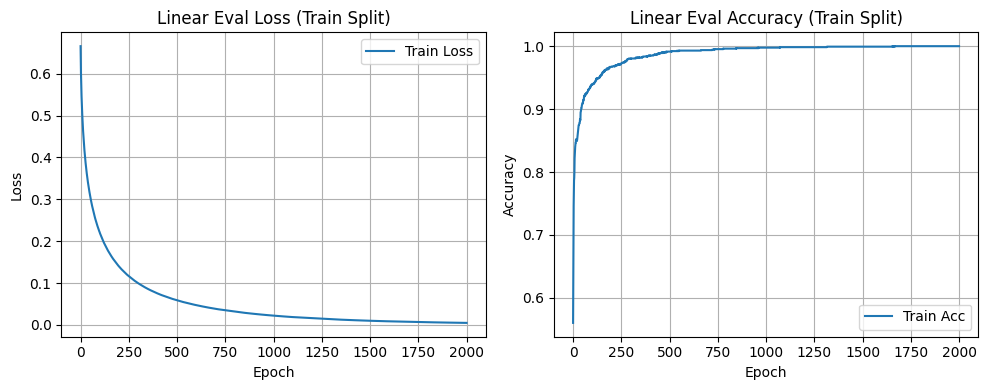

In [15]:
# Cell 15: Linear Eval Curves (Train Split Only)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.title('Linear Eval Loss (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.title('Linear Eval Accuracy (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


In [16]:
# Cell 16: Testing on 80% Test Split

classifier.eval()
test_labels_all, test_probs_all, test_preds_all = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all  = np.concatenate(test_preds_all)

print("\nTest (80%) Classification Report:")
print(classification_report(test_labels_all, test_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test (80%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.98      0.91      0.94       853
   Others_augmented       0.93      0.99      0.96      1063

           accuracy                           0.95      1916
          macro avg       0.96      0.95      0.95      1916
       weighted avg       0.95      0.95      0.95      1916



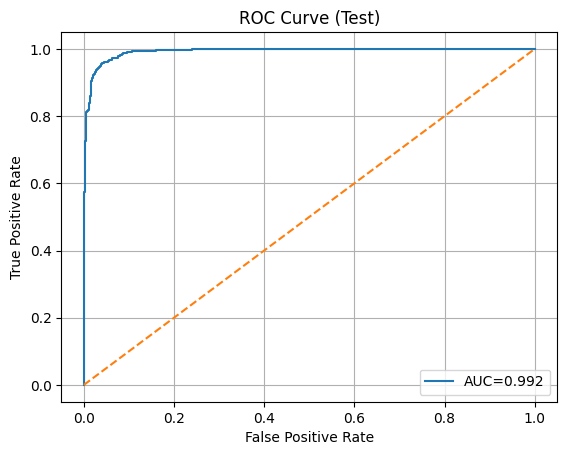

In [17]:
# Cell 17: ROC Curves (Multi-class or Binary)

if NUM_CLASSES == 2:
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
    auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.grid(True); plt.legend(); plt.show()
else:
    # One-vs-Rest ROC
    y_bin = label_binarize(test_labels_all, classes=list(range(NUM_CLASSES)))
    aucs = []
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], test_probs_all[:,i])
        auc_i = roc_auc_score(y_bin[:,i], test_probs_all[:,i])
        aucs.append(auc_i)
        plt.plot(fpr, tpr, label=f"{IDX_TO_CLASS[i]} (AUC={auc_i:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (OvR) - Test")
    plt.grid(True); plt.legend(); plt.show()
    print("Per-class AUCs:", {IDX_TO_CLASS[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})


Computing t-SNE on TEST features...


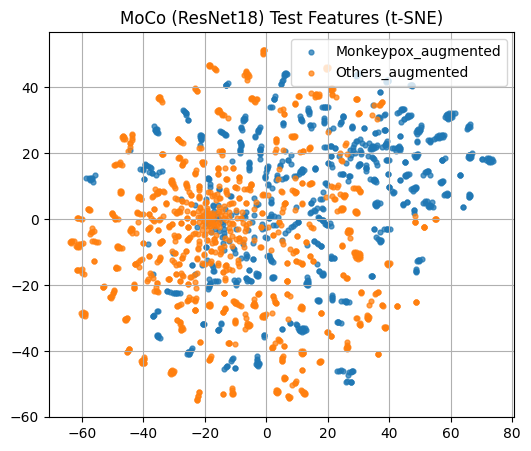

In [18]:
# Cell 18: t-SNE on TEST Features (Separability Check)

print("Computing t-SNE on TEST features...")
# Reuse the same frozen encoder (encoder_linear) for features
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("MoCo (ResNet18) Test Features (t-SNE)"); plt.grid(True); plt.show()
